# Load libraries

In [1]:
#activate tensor environment first!
#import warnings #filtering out warnings so homework looks pretty
#warnings.filterwarnings('ignore') #i do not recommend this for actual work 
import os
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import tensorflow as tf
from tensorflow import keras  
from sklearn.model_selection import train_test_split

C:\Users\Kat\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Kat\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Kat\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Kat\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\frame

# Load data

In [2]:
blue=pd.read_csv('fad_blue_rnadata.csv').rename(columns={"Unnamed: 0": "Cells"})
blue.set_index("Cells", drop=True,inplace=True)
blue=blue.T
#^transpose because we want genes to be features

In [3]:
idx=blue.index 
Y=blue['BlueFP']
x=blue.drop(['BlueFP'],axis=1)
#get top 200 genes from linear reg
genestokeep=pd.read_csv('data/top200_genes.csv').drop("Unnamed: 0",axis=1)['Genes']
x2=x.loc[:, x.columns.isin(genestokeep)]
genes=x2.columns
#set x and y
X=x2.to_numpy()

# Try different model architectures

Referenced this tutorial: https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

## Code (Qi's tune_cnn.py, modified) and all outputs are shown below

In [4]:
#using Qi's posted tune_cnn.py as reference
from skopt import gp_minimize, dump, load
from skopt.space import Real, Integer
from skopt.plots import plot_convergence
from skopt.utils import use_named_args 
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import datetime

In [5]:
#using Qi's posted tune_cnn.py as reference
#set kernel size to 3 and change filter_num to be a variable
batch_size=500
epochs=100
def create_model(dropout, filter_num, num_dense_layers): 
    # Start construction of a Keras Sequential model.
    model = Sequential()
    model.add(Dense(X.shape[1], input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(int(filter_num), kernel_initializer='normal', activation='relu')) 
    model.add(Dropout(dropout))
    for i in range(num_dense_layers):
        
        # Add the dense / fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes and the activation function.
        model.add(keras.layers.Dense(int(filter_num),
                        activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(int(filter_num), kernel_initializer='normal', activation='relu'))  
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam') 
    return model

log_path = './mnist_skopt_log'
if not os.path.exists(log_path):
    os.makedirs(log_path)
result_path = './mnist_skopt_result'
if not os.path.exists(result_path):
    os.makedirs(result_path)

def log_dir_name(dropout,
                 filter_num,
                 num_dense_layers):
    # The dir-name for the TensorBoard log-dir.
    s = os.path.join(log_path, "dropout_{0:.0e}_filternum_{1}_dense_{2}/")
    
    log_dir = s.format(dropout,
                       filter_num,
                       num_dense_layers)
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
   # plugins\profile/datetime
#had to make these folders manually due to windows issues
    s2 = os.path.join(log_dir, "plugins/")
    if not os.path.exists(s2):
        os.makedirs(s2)
    s3 = os.path.join(s2, "profile/")
    if not os.path.exists(s3):
        os.makedirs(s3)
    datenow=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    s4 = os.path.join(s3, datenow)
    if not os.path.exists(s4):
        os.makedirs(s4)
    return log_dir
dim_dropout= Real(low=0.2, high=0.8, prior='log-uniform',
                             name='dropout')
dim_filter_num = Integer(low=10, high=300, name='filter_num')
dim_num_dense_layers = Integer(low=1, high=20, name='num_dense_layers')
dimensions = [dim_dropout, dim_filter_num, dim_num_dense_layers]
@use_named_args(dimensions=dimensions)
def fitness(dropout,filter_num, num_dense_layers):
    # Print the hyper-parameters.
    print('dropout: {0:.1e}'.format(dropout))
    print('filter_num:', filter_num)
    print('num_dense_layers:', num_dense_layers)
    print()
    # Create the neural network with these hyper-parameters.
    model = create_model(dropout, filter_num,  num_dense_layers)
     
    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(dropout,filter_num,  num_dense_layers)
     
    callback_log = keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        batch_size=200,
        write_graph=True,
        write_grads=False,
        write_images=False)
    
    # Use Keras to train the model.
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_split=0.1,
                        callbacks=[callback_log])
    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    m_s_e = history.history['loss'][-1]

    # Print the classification accuracy.
    print()
    print("Mean squared error: {0:.2}".format(m_s_e))
    print()
    
    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_mean_squared_error

    # If the classification accuracy of the saved model is improved ...
    if m_s_e < best_mean_squared_error:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_mean_squared_error = m_s_e

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return m_s_e

In [6]:
path_best_model = os.path.join(result_path+'best_model.keras')
def print_and_plot(default_parameters):

    # initial hyperparameters for search 

    # search by Gaussian Process Optimization
    search_result = gp_minimize(func=fitness,
                                dimensions=dimensions,
                                acq_func='EI', # Expected Improvement.
                                n_calls=50, # min n_calls=11
                                x0=default_parameters)

    # save the search result for future use
    dump(search_result,result_path+'search_result.gz', compress=9)
    # if you need to reload the optimization history, use the following command
    #res_load = load(result_path+'search_result.gz')

    # check the optimization result
    plot_convergence(search_result)

    # check the optimized solution
    print('Best solution:')
    print(search_result.x)

    # Evaluate the performance of the best model on the test set
    model_best = load_model(path_best_model)
    score = model_best.evaluate(x_test, y_test, verbose=0)
    #print('Test loss:', score[0])
    #print('Test mse:', score[1])
    print()
    print('Score:')
    print(score)
    # check the optimization history by listing the combination of all x and 
    # its corresponding funtion value
    #print(sorted(zip(search_result.func_vals, search_result.x_iters)))

# Initial conditions try 1

In [7]:
#load and split data
x_train_pre, x_test_pre, y_train, y_test = train_test_split(X, Y, test_size=0.15)
scaler = StandardScaler().fit(x_train_pre) 
x_train = scaler.transform(x_train_pre) 
scaler = StandardScaler().fit(x_test_pre) 
x_test = scaler.transform(x_test_pre) 

dropout: 5.0e-01
filter_num: 50
num_dense_layers: 2

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 0s 117us/sample - loss: 59.1655 - val_loss: 54.4682
Epoch 2/100
2529/2529 [==============================] - 0s 15us/sample - loss: 57.8161 - val_loss: 52.4831
Epoch 3/100
2529/2529 [==============================] - 0s 12us/sample - loss: 54.6309 - val_loss: 47.1189
Epoch 4/100
2529/2529 [==============================] - 0s 12us/sample - loss: 47.0500 - val_loss: 36.0384
Epoch 5/100
2529/2529 [==============================] - 0s 12us/sample - loss: 40.0864 - val_loss: 28.6142
Epoch 6/100
2529/2529 [==============================] - 0s 11us/sample - loss: 37.2398 - val_loss: 28.8027
Epoch 7/100
252

2529/2529 [==============================] - 0s 12us/sample - loss: 8.5302 - val_loss: 300.8495
Epoch 69/100
2529/2529 [==============================] - 0s 12us/sample - loss: 8.6013 - val_loss: 306.1015
Epoch 70/100
2529/2529 [==============================] - 0s 12us/sample - loss: 7.7621 - val_loss: 379.6442
Epoch 71/100
2529/2529 [==============================] - 0s 11us/sample - loss: 9.1582 - val_loss: 391.2026
Epoch 72/100
2529/2529 [==============================] - 0s 11us/sample - loss: 8.3512 - val_loss: 311.8145
Epoch 73/100
2529/2529 [==============================] - 0s 11us/sample - loss: 10.2642 - val_loss: 340.2305
Epoch 74/100
2529/2529 [==============================] - 0s 12us/sample - loss: 8.9411 - val_loss: 360.1995
Epoch 75/100
2529/2529 [==============================] - 0s 11us/sample - loss: 12.0601 - val_loss: 305.7825
Epoch 76/100
2529/2529 [==============================] - 0s 11us/sample - loss: 8.3265 - val_loss: 292.0211
Epoch 77/100
2529/2529 [======

2529/2529 [==============================] - 0s 45us/sample - loss: 14.1650 - val_loss: 32.5772
Epoch 43/100
2529/2529 [==============================] - 0s 45us/sample - loss: 14.7834 - val_loss: 40.6126
Epoch 44/100
2529/2529 [==============================] - 0s 46us/sample - loss: 15.0150 - val_loss: 34.7437
Epoch 45/100
2529/2529 [==============================] - 0s 44us/sample - loss: 15.9436 - val_loss: 40.4515
Epoch 46/100
2529/2529 [==============================] - 0s 45us/sample - loss: 29.4264 - val_loss: 45.7122
Epoch 47/100
2529/2529 [==============================] - 0s 44us/sample - loss: 30.6589 - val_loss: 31.0925
Epoch 48/100
2529/2529 [==============================] - 0s 45us/sample - loss: 18.5227 - val_loss: 35.1493
Epoch 49/100
2529/2529 [==============================] - 0s 45us/sample - loss: 18.0384 - val_loss: 33.9232
Epoch 50/100
2529/2529 [==============================] - 0s 45us/sample - loss: 16.6239 - val_loss: 36.0549
Epoch 51/100
2529/2529 [========

2529/2529 [==============================] - 0s 69us/sample - loss: 38.7295 - val_loss: 51.1487
Epoch 9/100
2529/2529 [==============================] - 0s 69us/sample - loss: 36.7479 - val_loss: 50.0830
Epoch 10/100
2529/2529 [==============================] - 0s 69us/sample - loss: 36.9962 - val_loss: 50.2232
Epoch 11/100
2529/2529 [==============================] - 0s 69us/sample - loss: 35.4582 - val_loss: 50.3424
Epoch 12/100
2529/2529 [==============================] - 0s 68us/sample - loss: 33.5410 - val_loss: 49.9002
Epoch 13/100
2529/2529 [==============================] - 0s 68us/sample - loss: 34.1058 - val_loss: 50.1778
Epoch 14/100
2529/2529 [==============================] - 0s 69us/sample - loss: 31.8958 - val_loss: 49.7055
Epoch 15/100
2529/2529 [==============================] - 0s 62us/sample - loss: 29.7115 - val_loss: 49.5801
Epoch 16/100
2529/2529 [==============================] - 0s 69us/sample - loss: 28.7845 - val_loss: 49.0363
Epoch 17/100
2529/2529 [=========

2529/2529 [==============================] - 0s 68us/sample - loss: 17.7373 - val_loss: 41.9579
Epoch 84/100
2529/2529 [==============================] - 0s 69us/sample - loss: 15.1803 - val_loss: 41.4379
Epoch 85/100
2529/2529 [==============================] - 0s 68us/sample - loss: 14.4826 - val_loss: 41.5656
Epoch 86/100
2529/2529 [==============================] - 0s 69us/sample - loss: 18.5507 - val_loss: 44.0234
Epoch 87/100
2529/2529 [==============================] - 0s 67us/sample - loss: 16.9769 - val_loss: 40.7289
Epoch 88/100
2529/2529 [==============================] - 0s 71us/sample - loss: 21.0332 - val_loss: 44.3516
Epoch 89/100
2529/2529 [==============================] - 0s 72us/sample - loss: 16.5943 - val_loss: 42.1448
Epoch 90/100
2529/2529 [==============================] - 0s 74us/sample - loss: 14.9613 - val_loss: 40.8435
Epoch 91/100
2529/2529 [==============================] - 0s 75us/sample - loss: 15.2646 - val_loss: 41.4694
Epoch 92/100
2529/2529 [========

2529/2529 [==============================] - 0s 50us/sample - loss: 6.6470 - val_loss: 31.9034
Epoch 58/100
2529/2529 [==============================] - 0s 50us/sample - loss: 6.7787 - val_loss: 32.5688
Epoch 59/100
2529/2529 [==============================] - 0s 49us/sample - loss: 6.7349 - val_loss: 32.1284
Epoch 60/100
2529/2529 [==============================] - 0s 49us/sample - loss: 8.1839 - val_loss: 31.0977
Epoch 61/100
2529/2529 [==============================] - 0s 51us/sample - loss: 7.6995 - val_loss: 32.5349
Epoch 62/100
2529/2529 [==============================] - 0s 52us/sample - loss: 9.1888 - val_loss: 31.8072
Epoch 63/100
2529/2529 [==============================] - 0s 50us/sample - loss: 7.2672 - val_loss: 32.0127
Epoch 64/100
2529/2529 [==============================] - 0s 50us/sample - loss: 7.4823 - val_loss: 31.8934
Epoch 65/100
2529/2529 [==============================] - 0s 49us/sample - loss: 7.8321 - val_loss: 31.8799
Epoch 66/100
2529/2529 [=================

2529/2529 [==============================] - 0s 122us/sample - loss: 14.0395 - val_loss: 30.7808
Epoch 32/100
2529/2529 [==============================] - 0s 122us/sample - loss: 14.2793 - val_loss: 28.2736
Epoch 33/100
2529/2529 [==============================] - 0s 123us/sample - loss: 12.4204 - val_loss: 31.3030
Epoch 34/100
2529/2529 [==============================] - 0s 123us/sample - loss: 14.0373 - val_loss: 30.2953
Epoch 35/100
2529/2529 [==============================] - 0s 123us/sample - loss: 10.7343 - val_loss: 29.9123
Epoch 36/100
2529/2529 [==============================] - 0s 126us/sample - loss: 10.6995 - val_loss: 31.2280
Epoch 37/100
2529/2529 [==============================] - 0s 121us/sample - loss: 11.7652 - val_loss: 29.1869
Epoch 38/100
2529/2529 [==============================] - 0s 125us/sample - loss: 11.7141 - val_loss: 29.5096
Epoch 39/100
2529/2529 [==============================] - 0s 120us/sample - loss: 12.6945 - val_loss: 36.2182
Epoch 40/100
2529/2529 

2529/2529 [==============================] - 0s 26us/sample - loss: 40.9400 - val_loss: 38.7360
Epoch 5/100
2529/2529 [==============================] - 0s 26us/sample - loss: 39.6580 - val_loss: 31.9090
Epoch 6/100
2529/2529 [==============================] - 0s 28us/sample - loss: 36.5745 - val_loss: 28.7441
Epoch 7/100
2529/2529 [==============================] - 0s 26us/sample - loss: 33.7404 - val_loss: 32.8979
Epoch 8/100
2529/2529 [==============================] - 0s 26us/sample - loss: 32.1173 - val_loss: 27.3620
Epoch 9/100
2529/2529 [==============================] - 0s 26us/sample - loss: 29.5244 - val_loss: 26.3318
Epoch 10/100
2529/2529 [==============================] - 0s 26us/sample - loss: 30.3700 - val_loss: 29.0777
Epoch 11/100
2529/2529 [==============================] - 0s 26us/sample - loss: 30.3532 - val_loss: 31.5963
Epoch 12/100
2529/2529 [==============================] - 0s 26us/sample - loss: 26.1042 - val_loss: 26.6303
Epoch 13/100
2529/2529 [=============

2529/2529 [==============================] - 0s 29us/sample - loss: 12.0005 - val_loss: 45.2846
Epoch 80/100
2529/2529 [==============================] - 0s 27us/sample - loss: 10.4751 - val_loss: 42.8241
Epoch 81/100
2529/2529 [==============================] - 0s 27us/sample - loss: 9.8085 - val_loss: 44.3796
Epoch 82/100
2529/2529 [==============================] - 0s 28us/sample - loss: 6.2563 - val_loss: 42.1647
Epoch 83/100
2529/2529 [==============================] - 0s 27us/sample - loss: 6.7472 - val_loss: 47.7306
Epoch 84/100
2529/2529 [==============================] - 0s 26us/sample - loss: 5.5536 - val_loss: 45.3613
Epoch 85/100
2529/2529 [==============================] - 0s 26us/sample - loss: 5.7341 - val_loss: 46.3441
Epoch 86/100
2529/2529 [==============================] - 0s 25us/sample - loss: 5.0243 - val_loss: 50.8166
Epoch 87/100
2529/2529 [==============================] - 0s 26us/sample - loss: 5.5598 - val_loss: 45.7465
Epoch 88/100
2529/2529 [===============

Epoch 53/100
2529/2529 [==============================] - 0s 142us/sample - loss: 26.8137 - val_loss: 37.1689
Epoch 54/100
2529/2529 [==============================] - 0s 139us/sample - loss: 29.3846 - val_loss: 31.0873
Epoch 55/100
2529/2529 [==============================] - 0s 135us/sample - loss: 25.7178 - val_loss: 36.5760
Epoch 56/100
2529/2529 [==============================] - 0s 127us/sample - loss: 26.0497 - val_loss: 28.8082
Epoch 57/100
2529/2529 [==============================] - 0s 136us/sample - loss: 25.8181 - val_loss: 37.5170
Epoch 58/100
2529/2529 [==============================] - 0s 137us/sample - loss: 23.3199 - val_loss: 31.4769
Epoch 59/100
2529/2529 [==============================] - 0s 145us/sample - loss: 20.4048 - val_loss: 30.2443
Epoch 60/100
2529/2529 [==============================] - 0s 143us/sample - loss: 19.1047 - val_loss: 36.5544
Epoch 61/100
2529/2529 [==============================] - 0s 140us/sample - loss: 23.8490 - val_loss: 34.3095
Epoch 62/1

2529/2529 [==============================] - 0s 32us/sample - loss: 10.5807 - val_loss: 30.3361
Epoch 27/100
2529/2529 [==============================] - 0s 33us/sample - loss: 10.9008 - val_loss: 31.6834
Epoch 28/100
2529/2529 [==============================] - 0s 33us/sample - loss: 10.6145 - val_loss: 31.6304
Epoch 29/100
2529/2529 [==============================] - 0s 32us/sample - loss: 9.4906 - val_loss: 31.0918
Epoch 30/100
2529/2529 [==============================] - 0s 31us/sample - loss: 8.6967 - val_loss: 30.2118
Epoch 31/100
2529/2529 [==============================] - 0s 33us/sample - loss: 8.9066 - val_loss: 30.2077
Epoch 32/100
2529/2529 [==============================] - 0s 32us/sample - loss: 8.5734 - val_loss: 30.6979
Epoch 33/100
2529/2529 [==============================] - 0s 32us/sample - loss: 9.2564 - val_loss: 29.6645
Epoch 34/100
2529/2529 [==============================] - 0s 33us/sample - loss: 7.2513 - val_loss: 29.8458
Epoch 35/100
2529/2529 [==============

Epoch 1/100
2529/2529 [==============================] - 1s 490us/sample - loss: 54.6891 - val_loss: 49.4801
Epoch 2/100
2529/2529 [==============================] - 0s 114us/sample - loss: 44.2501 - val_loss: 44.3852
Epoch 3/100
2529/2529 [==============================] - 0s 113us/sample - loss: 40.2465 - val_loss: 44.4801
Epoch 4/100
2529/2529 [==============================] - 0s 112us/sample - loss: 38.5792 - val_loss: 33.1156
Epoch 5/100
2529/2529 [==============================] - 0s 114us/sample - loss: 35.1385 - val_loss: 33.2710
Epoch 6/100
2529/2529 [==============================] - 0s 118us/sample - loss: 33.3774 - val_loss: 40.1196
Epoch 7/100
2529/2529 [==============================] - 0s 120us/sample - loss: 30.1461 - val_loss: 38.6457
Epoch 8/100
2529/2529 [==============================] - 0s 122us/sample - loss: 29.4996 - val_loss: 32.1204
Epoch 9/100
2529/2529 [==============================] - 0s 122us/sample - loss: 24.3127 - val_loss: 32.3556
Epoch 10/100
2529/2

2529/2529 [==============================] - 0s 110us/sample - loss: 18.7522 - val_loss: 36.5450
Epoch 76/100
2529/2529 [==============================] - 0s 110us/sample - loss: 60.1496 - val_loss: 47.0189
Epoch 77/100
2529/2529 [==============================] - 0s 109us/sample - loss: 50.0969 - val_loss: 46.8727
Epoch 78/100
2529/2529 [==============================] - 0s 114us/sample - loss: 49.3635 - val_loss: 44.0079
Epoch 79/100
2529/2529 [==============================] - 0s 111us/sample - loss: 44.6524 - val_loss: 37.2728
Epoch 80/100
2529/2529 [==============================] - 0s 111us/sample - loss: 36.1846 - val_loss: 29.9649
Epoch 81/100
2529/2529 [==============================] - 0s 108us/sample - loss: 20.2250 - val_loss: 32.2173
Epoch 82/100
2529/2529 [==============================] - 0s 109us/sample - loss: 17.4905 - val_loss: 34.2890
Epoch 83/100
2529/2529 [==============================] - 0s 112us/sample - loss: 17.2451 - val_loss: 33.2011
Epoch 84/100
2529/2529 

Epoch 49/100
2529/2529 [==============================] - 0s 84us/sample - loss: 11.6384 - val_loss: 33.4187
Epoch 50/100
2529/2529 [==============================] - 0s 84us/sample - loss: 13.2405 - val_loss: 33.3825
Epoch 51/100
2529/2529 [==============================] - 0s 80us/sample - loss: 14.3249 - val_loss: 31.1810
Epoch 52/100
2529/2529 [==============================] - 0s 81us/sample - loss: 10.8794 - val_loss: 34.1905
Epoch 53/100
2529/2529 [==============================] - 0s 81us/sample - loss: 11.4394 - val_loss: 31.6983
Epoch 54/100
2529/2529 [==============================] - 0s 83us/sample - loss: 10.7197 - val_loss: 32.6853
Epoch 55/100
2529/2529 [==============================] - 0s 75us/sample - loss: 9.7893 - val_loss: 31.3379
Epoch 56/100
2529/2529 [==============================] - 0s 86us/sample - loss: 8.5907 - val_loss: 32.5719
Epoch 57/100
2529/2529 [==============================] - 0s 83us/sample - loss: 8.8626 - val_loss: 31.0713
Epoch 58/100
2529/2529

Epoch 23/100
2529/2529 [==============================] - 0s 106us/sample - loss: 29.4154 - val_loss: 44.5891
Epoch 24/100
2529/2529 [==============================] - 0s 98us/sample - loss: 23.2022 - val_loss: 43.2557
Epoch 25/100
2529/2529 [==============================] - 0s 103us/sample - loss: 26.2553 - val_loss: 43.1875
Epoch 26/100
2529/2529 [==============================] - 0s 104us/sample - loss: 44.6436 - val_loss: 46.6639
Epoch 27/100
2529/2529 [==============================] - 0s 102us/sample - loss: 34.0262 - val_loss: 44.5351
Epoch 28/100
2529/2529 [==============================] - 0s 102us/sample - loss: 26.6011 - val_loss: 43.7642
Epoch 29/100
2529/2529 [==============================] - 0s 99us/sample - loss: 28.9767 - val_loss: 43.3948
Epoch 30/100
2529/2529 [==============================] - 0s 107us/sample - loss: 24.6487 - val_loss: 43.4914
Epoch 31/100
2529/2529 [==============================] - 0s 104us/sample - loss: 20.7657 - val_loss: 37.7250
Epoch 32/100

2529/2529 [==============================] - 0s 103us/sample - loss: 38.8791 - val_loss: 42.7648
Epoch 98/100
2529/2529 [==============================] - 0s 106us/sample - loss: 33.9501 - val_loss: 42.1245
Epoch 99/100
2529/2529 [==============================] - 0s 102us/sample - loss: 30.3080 - val_loss: 40.2401
Epoch 100/100
2529/2529 [==============================] - 0s 102us/sample - loss: 31.7347 - val_loss: 44.5996

Mean squared error: 3.2e+01

dropout: 2.0e-01
filter_num: 300
num_dense_layers: 1

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 0s 113us/sample - loss: 50.4356 - val_loss: 32.0676
Epoch 2/100
2529/2529 [==============================] - 0s 31us/sample - loss: 41.2632 - val_loss: 30.8990
Epoch 3/100
2529/2529 [==============================] - 0s 25us/sample - loss: 37.5883 - val_loss: 30.0634
Epoch 4/100
2529/2529 [==============================] - 0s 25us/sample - loss: 34.0202 - val_loss: 27.8571
Epoch 5/

2529/2529 [==============================] - 0s 25us/sample - loss: 1.8137 - val_loss: 39.8486
Epoch 72/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.8273 - val_loss: 37.5000
Epoch 73/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.8562 - val_loss: 37.6717
Epoch 74/100
2529/2529 [==============================] - 0s 24us/sample - loss: 1.4829 - val_loss: 38.9467
Epoch 75/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.4639 - val_loss: 39.0232
Epoch 76/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.3706 - val_loss: 39.5255
Epoch 77/100
2529/2529 [==============================] - 0s 27us/sample - loss: 1.2955 - val_loss: 39.3326
Epoch 78/100
2529/2529 [==============================] - 0s 24us/sample - loss: 1.1981 - val_loss: 37.2005
Epoch 79/100
2529/2529 [==============================] - 0s 24us/sample - loss: 1.1080 - val_loss: 37.6705
Epoch 80/100
2529/2529 [=================

2529/2529 [==============================] - 0s 9us/sample - loss: 21.0408 - val_loss: 33.2319
Epoch 46/100
2529/2529 [==============================] - 0s 10us/sample - loss: 20.0696 - val_loss: 34.6488
Epoch 47/100
2529/2529 [==============================] - 0s 10us/sample - loss: 19.2509 - val_loss: 36.1485
Epoch 48/100
2529/2529 [==============================] - 0s 10us/sample - loss: 19.3334 - val_loss: 37.3524
Epoch 49/100
2529/2529 [==============================] - 0s 10us/sample - loss: 18.8093 - val_loss: 37.7976
Epoch 50/100
2529/2529 [==============================] - 0s 10us/sample - loss: 18.6540 - val_loss: 39.0361
Epoch 51/100
2529/2529 [==============================] - 0s 10us/sample - loss: 18.9804 - val_loss: 41.2104
Epoch 52/100
2529/2529 [==============================] - 0s 9us/sample - loss: 18.0129 - val_loss: 43.2072
Epoch 53/100
2529/2529 [==============================] - 0s 10us/sample - loss: 16.7314 - val_loss: 45.7237
Epoch 54/100
2529/2529 [==========

C:\Users\Kat\anaconda3\envs\tensor\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/100
2529/2529 [==============================] - 0s 112us/sample - loss: 51.7759 - val_loss: 31.9532
Epoch 2/100
2529/2529 [==============================] - 0s 26us/sample - loss: 39.8983 - val_loss: 29.7963
Epoch 3/100
2529/2529 [==============================] - 0s 25us/sample - loss: 35.8988 - val_loss: 28.0847
Epoch 4/100
2529/2529 [==============================] - 0s 25us/sample - loss: 33.0093 - val_loss: 27.1023
Epoch 5/100
2529/2529 [==============================] - 0s 25us/sample - loss: 30.0069 - val_loss: 26.6018
Epoch 6/100
2529/2529 [==============================] - 0s 26us/sample - loss: 26.6898 - val_loss: 27.3068
Epoch 7/100
2529/2529 [==============================] - 0s 28us/sample - loss: 23.9030 - val_loss: 29.9346
Epoch 8/100
2529/2529 [==============================] - 0s 25us/sample - loss: 21.8219 - val_loss: 29.8298
Epoch 9/100
2529/2529 [==============================] - 0s 25us/sample - loss: 20.0362 - val_loss: 35.2509
Epoch 10/100
2529/2529 [===

Epoch 77/100
2529/2529 [==============================] - 0s 22us/sample - loss: 1.7299 - val_loss: 50.3409
Epoch 78/100
2529/2529 [==============================] - 0s 29us/sample - loss: 1.3708 - val_loss: 49.9438
Epoch 79/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.8452 - val_loss: 52.2134
Epoch 80/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.7744 - val_loss: 50.1463
Epoch 81/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.3185 - val_loss: 52.2331
Epoch 82/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.5984 - val_loss: 49.0660
Epoch 83/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.5355 - val_loss: 49.8062
Epoch 84/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.4533 - val_loss: 47.2400
Epoch 85/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.1538 - val_loss: 47.8754
Epoch 86/100
2529/2529 [====

C:\Users\Kat\anaconda3\envs\tensor\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/100
2529/2529 [==============================] - 0s 110us/sample - loss: 53.2248 - val_loss: 32.3167
Epoch 2/100
2529/2529 [==============================] - 0s 22us/sample - loss: 39.7436 - val_loss: 29.2839
Epoch 3/100
2529/2529 [==============================] - 0s 29us/sample - loss: 36.3736 - val_loss: 28.2304
Epoch 4/100
2529/2529 [==============================] - 0s 25us/sample - loss: 33.6701 - val_loss: 26.0726
Epoch 5/100
2529/2529 [==============================] - 0s 25us/sample - loss: 30.9075 - val_loss: 25.8707
Epoch 6/100
2529/2529 [==============================] - 0s 25us/sample - loss: 28.4335 - val_loss: 26.3067
Epoch 7/100
2529/2529 [==============================] - 0s 25us/sample - loss: 25.5220 - val_loss: 27.6146
Epoch 8/100
2529/2529 [==============================] - 0s 25us/sample - loss: 23.4398 - val_loss: 30.5360
Epoch 9/100
2529/2529 [==============================] - 0s 25us/sample - loss: 21.1392 - val_loss: 30.7841
Epoch 10/100
2529/2529 [===

Epoch 77/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.1662 - val_loss: 38.0570
Epoch 78/100
2529/2529 [==============================] - 0s 21us/sample - loss: 0.9993 - val_loss: 38.8352
Epoch 79/100
2529/2529 [==============================] - 0s 30us/sample - loss: 1.1045 - val_loss: 38.5243
Epoch 80/100
2529/2529 [==============================] - 0s 24us/sample - loss: 1.0653 - val_loss: 39.2700
Epoch 81/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.2451 - val_loss: 38.1541
Epoch 82/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.1104 - val_loss: 38.2963
Epoch 83/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.0918 - val_loss: 42.0170
Epoch 84/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.7361 - val_loss: 38.3717
Epoch 85/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.1635 - val_loss: 42.8044
Epoch 86/100
2529/2529 [====

C:\Users\Kat\anaconda3\envs\tensor\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


dropout: 2.0e-01
filter_num: 300
num_dense_layers: 1

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 0s 111us/sample - loss: 53.9591 - val_loss: 33.7542
Epoch 2/100
2529/2529 [==============================] - 0s 26us/sample - loss: 41.3397 - val_loss: 30.5167
Epoch 3/100
2529/2529 [==============================] - 0s 26us/sample - loss: 38.3407 - val_loss: 30.4475
Epoch 4/100
2529/2529 [==============================] - 0s 25us/sample - loss: 34.3811 - val_loss: 28.2716
Epoch 5/100
2529/2529 [==============================] - 0s 25us/sample - loss: 31.9806 - val_loss: 26.8558
Epoch 6/100
2529/2529 [==============================] - 0s 25us/sample - loss: 28.7127 - val_loss: 27.3757
Epoch 7/100
2529/2529 [==============================] - 0s 25us/sample - loss: 25.8084 - val_loss: 30.3431
Epoch 8/100
2529/2529 [==============================] - 0s 25us/sample - loss: 24.0008 - val_loss: 30.7014
Epoch 9/100
2529/2529 [===========

Epoch 76/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.3574 - val_loss: 44.7529
Epoch 77/100
2529/2529 [==============================] - 0s 27us/sample - loss: 1.1160 - val_loss: 44.8095
Epoch 78/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.2149 - val_loss: 44.7322
Epoch 79/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.1813 - val_loss: 45.6947
Epoch 80/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.3756 - val_loss: 44.3278
Epoch 81/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.2260 - val_loss: 40.6980
Epoch 82/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.6302 - val_loss: 43.6482
Epoch 83/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.7090 - val_loss: 42.3852
Epoch 84/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.4873 - val_loss: 46.8475
Epoch 85/100
2529/2529 [====

2529/2529 [==============================] - 0s 20us/sample - loss: 2.2799 - val_loss: 49.0780
Epoch 51/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.3678 - val_loss: 44.7339
Epoch 52/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.1607 - val_loss: 48.3949
Epoch 53/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.1284 - val_loss: 43.3205
Epoch 54/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.3733 - val_loss: 51.3037
Epoch 55/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.3434 - val_loss: 46.8900
Epoch 56/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.5704 - val_loss: 53.7476
Epoch 57/100
2529/2529 [==============================] - 0s 18us/sample - loss: 2.1390 - val_loss: 47.8022
Epoch 58/100
2529/2529 [==============================] - 0s 19us/sample - loss: 1.8126 - val_loss: 49.8531
Epoch 59/100
2529/2529 [=================

2529/2529 [==============================] - 0s 33us/sample - loss: 5.3399 - val_loss: 37.6921
Epoch 25/100
2529/2529 [==============================] - 0s 34us/sample - loss: 5.4802 - val_loss: 33.2404
Epoch 26/100
2529/2529 [==============================] - 0s 32us/sample - loss: 5.2397 - val_loss: 39.8448
Epoch 27/100
2529/2529 [==============================] - 0s 32us/sample - loss: 5.6880 - val_loss: 33.5586
Epoch 28/100
2529/2529 [==============================] - 0s 32us/sample - loss: 4.5181 - val_loss: 37.4650
Epoch 29/100
2529/2529 [==============================] - 0s 32us/sample - loss: 4.1818 - val_loss: 34.7849
Epoch 30/100
2529/2529 [==============================] - 0s 32us/sample - loss: 4.3997 - val_loss: 36.7114
Epoch 31/100
2529/2529 [==============================] - 0s 33us/sample - loss: 4.3231 - val_loss: 35.1529
Epoch 32/100
2529/2529 [==============================] - 0s 32us/sample - loss: 4.1911 - val_loss: 34.4090
Epoch 33/100
2529/2529 [=================

Epoch 100/100
2529/2529 [==============================] - 0s 32us/sample - loss: 2.1271 - val_loss: 42.0866

Mean squared error: 2.1

dropout: 3.3e-01
filter_num: 300
num_dense_layers: 1

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 0s 112us/sample - loss: 51.3537 - val_loss: 31.7666
Epoch 2/100
2529/2529 [==============================] - 0s 26us/sample - loss: 41.9596 - val_loss: 30.7822
Epoch 3/100
2529/2529 [==============================] - 0s 25us/sample - loss: 37.2886 - val_loss: 29.5988
Epoch 4/100
2529/2529 [==============================] - 0s 26us/sample - loss: 34.6984 - val_loss: 27.0335
Epoch 5/100
2529/2529 [==============================] - 0s 25us/sample - loss: 31.2174 - val_loss: 26.6288
Epoch 6/100
2529/2529 [==============================] - 0s 28us/sample - loss: 29.5067 - val_loss: 26.6553
Epoch 7/100
2529/2529 [==============================] - 0s 27us/sample - loss: 26.4140 - val_loss: 30.2061
Epoch 8

2529/2529 [==============================] - 0s 25us/sample - loss: 3.5528 - val_loss: 39.7959
Epoch 75/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.9195 - val_loss: 38.9542
Epoch 76/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.5077 - val_loss: 42.6031
Epoch 77/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.5806 - val_loss: 41.7452
Epoch 78/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.3382 - val_loss: 43.7788
Epoch 79/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.3025 - val_loss: 41.8752
Epoch 80/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.8329 - val_loss: 41.4158
Epoch 81/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.9586 - val_loss: 39.9776
Epoch 82/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.0141 - val_loss: 43.9861
Epoch 83/100
2529/2529 [=================

2529/2529 [==============================] - 0s 17us/sample - loss: 54.0972 - val_loss: 49.9351
Epoch 49/100
2529/2529 [==============================] - 0s 17us/sample - loss: 54.0247 - val_loss: 49.6826
Epoch 50/100
2529/2529 [==============================] - 0s 17us/sample - loss: 53.9637 - val_loss: 49.4328
Epoch 51/100
2529/2529 [==============================] - 0s 17us/sample - loss: 52.4981 - val_loss: 49.1683
Epoch 52/100
2529/2529 [==============================] - 0s 17us/sample - loss: 53.1902 - val_loss: 48.8702
Epoch 53/100
2529/2529 [==============================] - 0s 17us/sample - loss: 53.1773 - val_loss: 48.6458
Epoch 54/100
2529/2529 [==============================] - 0s 17us/sample - loss: 53.8363 - val_loss: 48.5550
Epoch 55/100
2529/2529 [==============================] - 0s 17us/sample - loss: 52.7452 - val_loss: 48.3952
Epoch 56/100
2529/2529 [==============================] - 0s 17us/sample - loss: 52.7155 - val_loss: 48.1258
Epoch 57/100
2529/2529 [========

2529/2529 [==============================] - 0s 12us/sample - loss: 33.0233 - val_loss: 31.5909
Epoch 23/100
2529/2529 [==============================] - 0s 12us/sample - loss: 34.7480 - val_loss: 31.7547
Epoch 24/100
2529/2529 [==============================] - 0s 11us/sample - loss: 32.2505 - val_loss: 30.1910
Epoch 25/100
2529/2529 [==============================] - 0s 11us/sample - loss: 32.0994 - val_loss: 30.2983
Epoch 26/100
2529/2529 [==============================] - 0s 12us/sample - loss: 32.1310 - val_loss: 31.0989
Epoch 27/100
2529/2529 [==============================] - 0s 12us/sample - loss: 28.3982 - val_loss: 31.5109
Epoch 28/100
2529/2529 [==============================] - 0s 12us/sample - loss: 33.9042 - val_loss: 31.3437
Epoch 29/100
2529/2529 [==============================] - 0s 12us/sample - loss: 30.4049 - val_loss: 31.2474
Epoch 30/100
2529/2529 [==============================] - 0s 11us/sample - loss: 30.0153 - val_loss: 31.2738
Epoch 31/100
2529/2529 [========

Epoch 97/100
2529/2529 [==============================] - 0s 11us/sample - loss: 13.9397 - val_loss: 107.3966
Epoch 98/100
2529/2529 [==============================] - 0s 11us/sample - loss: 11.7072 - val_loss: 110.5892
Epoch 99/100
2529/2529 [==============================] - 0s 12us/sample - loss: 12.5759 - val_loss: 116.9497
Epoch 100/100
2529/2529 [==============================] - 0s 11us/sample - loss: 13.0941 - val_loss: 127.7880

Mean squared error: 1.3e+01

dropout: 2.0e-01
filter_num: 300
num_dense_layers: 13

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 1s 423us/sample - loss: 68.4099 - val_loss: 45.3402
Epoch 2/100
2529/2529 [==============================] - 0s 121us/sample - loss: 53.5334 - val_loss: 54.2341
Epoch 3/100
2529/2529 [==============================] - 0s 114us/sample - loss: 58.2464 - val_loss: 54.0665
Epoch 4/100
2529/2529 [==============================] - 0s 111us/sample - loss: 58.0378 - val_loss:

2529/2529 [==============================] - 0s 116us/sample - loss: 10.3236 - val_loss: 30.1212
Epoch 71/100
2529/2529 [==============================] - 0s 121us/sample - loss: 6.9156 - val_loss: 35.4684
Epoch 72/100
2529/2529 [==============================] - 0s 122us/sample - loss: 10.4106 - val_loss: 31.0866
Epoch 73/100
2529/2529 [==============================] - 0s 118us/sample - loss: 8.2926 - val_loss: 34.1085
Epoch 74/100
2529/2529 [==============================] - 0s 121us/sample - loss: 8.4212 - val_loss: 31.0012
Epoch 75/100
2529/2529 [==============================] - 0s 118us/sample - loss: 8.1352 - val_loss: 29.2596
Epoch 76/100
2529/2529 [==============================] - 0s 115us/sample - loss: 6.2425 - val_loss: 31.5183
Epoch 77/100
2529/2529 [==============================] - 0s 114us/sample - loss: 6.3894 - val_loss: 30.8596
Epoch 78/100
2529/2529 [==============================] - 0s 113us/sample - loss: 6.9743 - val_loss: 30.8202
Epoch 79/100
2529/2529 [======

2529/2529 [==============================] - 0s 32us/sample - loss: 4.0238 - val_loss: 38.0253
Epoch 45/100
2529/2529 [==============================] - 0s 32us/sample - loss: 3.8088 - val_loss: 43.4401
Epoch 46/100
2529/2529 [==============================] - 0s 32us/sample - loss: 3.9412 - val_loss: 39.0328
Epoch 47/100
2529/2529 [==============================] - 0s 32us/sample - loss: 3.1632 - val_loss: 43.2647
Epoch 48/100
2529/2529 [==============================] - 0s 31us/sample - loss: 3.9121 - val_loss: 38.6126
Epoch 49/100
2529/2529 [==============================] - 0s 32us/sample - loss: 3.5414 - val_loss: 40.2548
Epoch 50/100
2529/2529 [==============================] - 0s 31us/sample - loss: 3.1951 - val_loss: 40.4961
Epoch 51/100
2529/2529 [==============================] - 0s 31us/sample - loss: 3.1328 - val_loss: 38.2718
Epoch 52/100
2529/2529 [==============================] - 0s 32us/sample - loss: 2.8231 - val_loss: 41.0332
Epoch 53/100
2529/2529 [=================

2529/2529 [==============================] - 0s 13us/sample - loss: 58.8463 - val_loss: 53.9306
Epoch 19/100
2529/2529 [==============================] - 0s 14us/sample - loss: 58.3786 - val_loss: 53.8730
Epoch 20/100
2529/2529 [==============================] - 0s 13us/sample - loss: 62.4331 - val_loss: 53.8367
Epoch 21/100
2529/2529 [==============================] - 0s 12us/sample - loss: 57.9836 - val_loss: 53.7825
Epoch 22/100
2529/2529 [==============================] - 0s 12us/sample - loss: 58.0579 - val_loss: 53.7219
Epoch 23/100
2529/2529 [==============================] - 0s 13us/sample - loss: 58.1166 - val_loss: 53.6634
Epoch 24/100
2529/2529 [==============================] - 0s 12us/sample - loss: 60.5909 - val_loss: 53.6124
Epoch 25/100
2529/2529 [==============================] - 0s 12us/sample - loss: 58.5809 - val_loss: 53.5795
Epoch 26/100
2529/2529 [==============================] - 0s 12us/sample - loss: 57.9336 - val_loss: 53.5368
Epoch 27/100
2529/2529 [========

2529/2529 [==============================] - 0s 13us/sample - loss: 50.9907 - val_loss: 44.0498
Epoch 94/100
2529/2529 [==============================] - 0s 13us/sample - loss: 50.2348 - val_loss: 43.8213
Epoch 95/100
2529/2529 [==============================] - 0s 12us/sample - loss: 49.7156 - val_loss: 43.5673
Epoch 96/100
2529/2529 [==============================] - 0s 13us/sample - loss: 49.5961 - val_loss: 43.2826
Epoch 97/100
2529/2529 [==============================] - 0s 13us/sample - loss: 49.9589 - val_loss: 42.9999
Epoch 98/100
2529/2529 [==============================] - 0s 13us/sample - loss: 49.3451 - val_loss: 42.7785
Epoch 99/100
2529/2529 [==============================] - 0s 12us/sample - loss: 46.8183 - val_loss: 42.5344
Epoch 100/100
2529/2529 [==============================] - 0s 13us/sample - loss: 49.3296 - val_loss: 42.2306

Mean squared error: 4.9e+01

dropout: 3.8e-01
filter_num: 300
num_dense_layers: 1

Train on 2529 samples, validate on 281 samples
Epoch 1/1

2529/2529 [==============================] - 0s 26us/sample - loss: 3.1198 - val_loss: 51.3222
Epoch 68/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.4219 - val_loss: 52.9283
Epoch 69/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.1597 - val_loss: 53.2018
Epoch 70/100
2529/2529 [==============================] - 0s 24us/sample - loss: 2.1251 - val_loss: 52.1520
Epoch 71/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.2052 - val_loss: 54.3418
Epoch 72/100
2529/2529 [==============================] - 0s 25us/sample - loss: 3.0564 - val_loss: 49.9250
Epoch 73/100
2529/2529 [==============================] - 0s 28us/sample - loss: 2.6412 - val_loss: 53.7477
Epoch 74/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.7530 - val_loss: 49.2687
Epoch 75/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.2791 - val_loss: 50.3842
Epoch 76/100
2529/2529 [=================

2529/2529 [==============================] - 0s 13us/sample - loss: 5.3372 - val_loss: 115.5325
Epoch 42/100
2529/2529 [==============================] - 0s 13us/sample - loss: 4.9865 - val_loss: 125.4676
Epoch 43/100
2529/2529 [==============================] - 0s 13us/sample - loss: 4.5537 - val_loss: 124.3021
Epoch 44/100
2529/2529 [==============================] - 0s 13us/sample - loss: 4.6107 - val_loss: 138.6474
Epoch 45/100
2529/2529 [==============================] - 0s 13us/sample - loss: 5.3867 - val_loss: 163.5194
Epoch 46/100
2529/2529 [==============================] - 0s 13us/sample - loss: 6.1198 - val_loss: 151.3164
Epoch 47/100
2529/2529 [==============================] - 0s 14us/sample - loss: 5.7819 - val_loss: 151.7592
Epoch 48/100
2529/2529 [==============================] - 0s 13us/sample - loss: 5.8776 - val_loss: 134.4147
Epoch 49/100
2529/2529 [==============================] - 0s 13us/sample - loss: 4.8508 - val_loss: 138.6292
Epoch 50/100
2529/2529 [========

2529/2529 [==============================] - 0s 25us/sample - loss: 12.8736 - val_loss: 38.3861
Epoch 16/100
2529/2529 [==============================] - 0s 25us/sample - loss: 12.3746 - val_loss: 36.9515
Epoch 17/100
2529/2529 [==============================] - 0s 25us/sample - loss: 10.6342 - val_loss: 39.1492
Epoch 18/100
2529/2529 [==============================] - 0s 24us/sample - loss: 8.8193 - val_loss: 38.8660
Epoch 19/100
2529/2529 [==============================] - 0s 25us/sample - loss: 7.8637 - val_loss: 39.2196
Epoch 20/100
2529/2529 [==============================] - 0s 25us/sample - loss: 7.3379 - val_loss: 35.3036
Epoch 21/100
2529/2529 [==============================] - 0s 25us/sample - loss: 9.2403 - val_loss: 39.1194
Epoch 22/100
2529/2529 [==============================] - 0s 25us/sample - loss: 8.2018 - val_loss: 34.7732
Epoch 23/100
2529/2529 [==============================] - 0s 21us/sample - loss: 7.7390 - val_loss: 38.3008
Epoch 24/100
2529/2529 [==============

Epoch 91/100
2529/2529 [==============================] - 0s 24us/sample - loss: 1.8618 - val_loss: 38.2700
Epoch 92/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.5801 - val_loss: 37.7768
Epoch 93/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.2956 - val_loss: 40.0238
Epoch 94/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.4877 - val_loss: 37.6494
Epoch 95/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.2376 - val_loss: 38.7588
Epoch 96/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.8488 - val_loss: 38.6418
Epoch 97/100
2529/2529 [==============================] - 0s 24us/sample - loss: 2.1245 - val_loss: 39.0201
Epoch 98/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.7376 - val_loss: 40.6448
Epoch 99/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.0571 - val_loss: 38.8561
Epoch 100/100
2529/2529 [===

2529/2529 [==============================] - 0s 25us/sample - loss: 1.7775 - val_loss: 59.6288
Epoch 66/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.6732 - val_loss: 65.5653
Epoch 67/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.5184 - val_loss: 61.5007
Epoch 68/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.5861 - val_loss: 66.0302
Epoch 69/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.5842 - val_loss: 61.0588
Epoch 70/100
2529/2529 [==============================] - 0s 24us/sample - loss: 1.9690 - val_loss: 65.9073
Epoch 71/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.8031 - val_loss: 59.7744
Epoch 72/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.6021 - val_loss: 62.1291
Epoch 73/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.5083 - val_loss: 61.5280
Epoch 74/100
2529/2529 [=================

2529/2529 [==============================] - 0s 67us/sample - loss: 6.0620 - val_loss: 32.2901
Epoch 40/100
2529/2529 [==============================] - 0s 67us/sample - loss: 5.6091 - val_loss: 32.7348
Epoch 41/100
2529/2529 [==============================] - 0s 66us/sample - loss: 5.4748 - val_loss: 33.1245
Epoch 42/100
2529/2529 [==============================] - 0s 67us/sample - loss: 4.9944 - val_loss: 32.8137
Epoch 43/100
2529/2529 [==============================] - 0s 67us/sample - loss: 6.6330 - val_loss: 38.7794
Epoch 44/100
2529/2529 [==============================] - 0s 66us/sample - loss: 9.3034 - val_loss: 32.2921
Epoch 45/100
2529/2529 [==============================] - 0s 68us/sample - loss: 7.6476 - val_loss: 31.4454
Epoch 46/100
2529/2529 [==============================] - 0s 66us/sample - loss: 10.9496 - val_loss: 31.4588
Epoch 47/100
2529/2529 [==============================] - 0s 66us/sample - loss: 6.7070 - val_loss: 31.2836
Epoch 48/100
2529/2529 [================

2529/2529 [==============================] - 0s 26us/sample - loss: 26.8948 - val_loss: 31.4186
Epoch 14/100
2529/2529 [==============================] - 0s 25us/sample - loss: 26.4777 - val_loss: 32.8124
Epoch 15/100
2529/2529 [==============================] - 0s 25us/sample - loss: 24.4027 - val_loss: 34.0958
Epoch 16/100
2529/2529 [==============================] - 0s 25us/sample - loss: 24.5966 - val_loss: 33.9924
Epoch 17/100
2529/2529 [==============================] - 0s 25us/sample - loss: 23.6036 - val_loss: 33.7478
Epoch 18/100
2529/2529 [==============================] - 0s 26us/sample - loss: 23.7600 - val_loss: 33.7105
Epoch 19/100
2529/2529 [==============================] - 0s 24us/sample - loss: 20.6378 - val_loss: 34.1098
Epoch 20/100
2529/2529 [==============================] - 0s 25us/sample - loss: 22.3487 - val_loss: 35.1516
Epoch 21/100
2529/2529 [==============================] - 0s 25us/sample - loss: 20.5232 - val_loss: 35.4865
Epoch 22/100
2529/2529 [========

2529/2529 [==============================] - 0s 24us/sample - loss: 10.8625 - val_loss: 98.1318
Epoch 89/100
2529/2529 [==============================] - 0s 24us/sample - loss: 7.6063 - val_loss: 92.9244
Epoch 90/100
2529/2529 [==============================] - 0s 25us/sample - loss: 6.5700 - val_loss: 94.7676
Epoch 91/100
2529/2529 [==============================] - 0s 25us/sample - loss: 7.7850 - val_loss: 104.2413
Epoch 92/100
2529/2529 [==============================] - 0s 24us/sample - loss: 7.7806 - val_loss: 104.5446
Epoch 93/100
2529/2529 [==============================] - 0s 25us/sample - loss: 6.8981 - val_loss: 94.3882
Epoch 94/100
2529/2529 [==============================] - 0s 25us/sample - loss: 6.4136 - val_loss: 100.0068
Epoch 95/100
2529/2529 [==============================] - 0s 24us/sample - loss: 6.9131 - val_loss: 113.8540
Epoch 96/100
2529/2529 [==============================] - 0s 21us/sample - loss: 6.3150 - val_loss: 114.6983
Epoch 97/100
2529/2529 [===========

2529/2529 [==============================] - 0s 23us/sample - loss: 2.0704 - val_loss: 35.2733
Epoch 63/100
2529/2529 [==============================] - 0s 23us/sample - loss: 2.5149 - val_loss: 36.4856
Epoch 64/100
2529/2529 [==============================] - 0s 23us/sample - loss: 2.7557 - val_loss: 34.1905
Epoch 65/100
2529/2529 [==============================] - 0s 23us/sample - loss: 2.4905 - val_loss: 36.7755
Epoch 66/100
2529/2529 [==============================] - 0s 23us/sample - loss: 2.1745 - val_loss: 34.2705
Epoch 67/100
2529/2529 [==============================] - 0s 23us/sample - loss: 1.7052 - val_loss: 37.5227
Epoch 68/100
2529/2529 [==============================] - 0s 22us/sample - loss: 2.2856 - val_loss: 35.7098
Epoch 69/100
2529/2529 [==============================] - 0s 22us/sample - loss: 2.0955 - val_loss: 38.9071
Epoch 70/100
2529/2529 [==============================] - 0s 21us/sample - loss: 1.6330 - val_loss: 35.7450
Epoch 71/100
2529/2529 [=================

2529/2529 [==============================] - 0s 12us/sample - loss: 9.6239 - val_loss: 149.1194
Epoch 37/100
2529/2529 [==============================] - 0s 12us/sample - loss: 8.6072 - val_loss: 177.6656
Epoch 38/100
2529/2529 [==============================] - 0s 11us/sample - loss: 7.6019 - val_loss: 162.3519
Epoch 39/100
2529/2529 [==============================] - 0s 12us/sample - loss: 9.0200 - val_loss: 196.8313
Epoch 40/100
2529/2529 [==============================] - 0s 12us/sample - loss: 7.7352 - val_loss: 209.3831
Epoch 41/100
2529/2529 [==============================] - 0s 11us/sample - loss: 6.8481 - val_loss: 199.0730
Epoch 42/100
2529/2529 [==============================] - 0s 11us/sample - loss: 6.1709 - val_loss: 238.0788
Epoch 43/100
2529/2529 [==============================] - 0s 12us/sample - loss: 6.2339 - val_loss: 240.6751
Epoch 44/100
2529/2529 [==============================] - 0s 11us/sample - loss: 5.7210 - val_loss: 233.6630
Epoch 45/100
2529/2529 [========

2529/2529 [==============================] - 0s 14us/sample - loss: 26.1241 - val_loss: 25.3677
Epoch 11/100
2529/2529 [==============================] - 0s 15us/sample - loss: 24.9554 - val_loss: 25.9207
Epoch 12/100
2529/2529 [==============================] - 0s 15us/sample - loss: 23.5917 - val_loss: 26.6859
Epoch 13/100
2529/2529 [==============================] - 0s 14us/sample - loss: 21.4711 - val_loss: 28.1646
Epoch 14/100
2529/2529 [==============================] - 0s 14us/sample - loss: 21.5358 - val_loss: 29.3182
Epoch 15/100
2529/2529 [==============================] - 0s 14us/sample - loss: 19.0111 - val_loss: 33.4075
Epoch 16/100
2529/2529 [==============================] - 0s 14us/sample - loss: 18.4666 - val_loss: 34.2267
Epoch 17/100
2529/2529 [==============================] - 0s 14us/sample - loss: 17.8115 - val_loss: 37.9450
Epoch 18/100
2529/2529 [==============================] - 0s 15us/sample - loss: 15.6753 - val_loss: 40.3240
Epoch 19/100
2529/2529 [========

2529/2529 [==============================] - 0s 14us/sample - loss: 2.1547 - val_loss: 118.6216
Epoch 86/100
2529/2529 [==============================] - 0s 14us/sample - loss: 2.0593 - val_loss: 121.5424
Epoch 87/100
2529/2529 [==============================] - 0s 14us/sample - loss: 1.8413 - val_loss: 122.8042
Epoch 88/100
2529/2529 [==============================] - 0s 14us/sample - loss: 1.8572 - val_loss: 123.4594
Epoch 89/100
2529/2529 [==============================] - 0s 14us/sample - loss: 1.6140 - val_loss: 122.7757
Epoch 90/100
2529/2529 [==============================] - 0s 14us/sample - loss: 1.6859 - val_loss: 126.2573
Epoch 91/100
2529/2529 [==============================] - 0s 14us/sample - loss: 1.5255 - val_loss: 121.2552
Epoch 92/100
2529/2529 [==============================] - 0s 14us/sample - loss: 1.5415 - val_loss: 120.4239
Epoch 93/100
2529/2529 [==============================] - 0s 14us/sample - loss: 1.4618 - val_loss: 120.6103
Epoch 94/100
2529/2529 [========

2529/2529 [==============================] - 0s 38us/sample - loss: 2.4393 - val_loss: 35.9464
Epoch 60/100
2529/2529 [==============================] - 0s 40us/sample - loss: 2.9073 - val_loss: 37.5618
Epoch 61/100
2529/2529 [==============================] - 0s 39us/sample - loss: 2.4468 - val_loss: 34.4908
Epoch 62/100
2529/2529 [==============================] - 0s 39us/sample - loss: 2.2090 - val_loss: 38.2546
Epoch 63/100
2529/2529 [==============================] - 0s 40us/sample - loss: 2.1383 - val_loss: 35.7862
Epoch 64/100
2529/2529 [==============================] - 0s 40us/sample - loss: 2.1971 - val_loss: 40.4646
Epoch 65/100
2529/2529 [==============================] - 0s 38us/sample - loss: 2.3281 - val_loss: 40.6094
Epoch 66/100
2529/2529 [==============================] - 0s 40us/sample - loss: 1.8599 - val_loss: 37.5751
Epoch 67/100
2529/2529 [==============================] - 0s 38us/sample - loss: 2.1697 - val_loss: 38.9356
Epoch 68/100
2529/2529 [=================

2529/2529 [==============================] - 0s 45us/sample - loss: 10.1499 - val_loss: 32.8109
Epoch 34/100
2529/2529 [==============================] - 0s 45us/sample - loss: 7.3179 - val_loss: 34.9031
Epoch 35/100
2529/2529 [==============================] - 0s 45us/sample - loss: 6.4843 - val_loss: 35.5915
Epoch 36/100
2529/2529 [==============================] - 0s 45us/sample - loss: 7.2316 - val_loss: 38.4142
Epoch 37/100
2529/2529 [==============================] - 0s 45us/sample - loss: 6.0632 - val_loss: 41.7442
Epoch 38/100
2529/2529 [==============================] - 0s 45us/sample - loss: 6.2952 - val_loss: 38.6481
Epoch 39/100
2529/2529 [==============================] - 0s 46us/sample - loss: 5.7059 - val_loss: 42.5120
Epoch 40/100
2529/2529 [==============================] - 0s 45us/sample - loss: 5.6531 - val_loss: 39.6440
Epoch 41/100
2529/2529 [==============================] - 0s 45us/sample - loss: 5.8937 - val_loss: 38.8544
Epoch 42/100
2529/2529 [================

2529/2529 [==============================] - 0s 19us/sample - loss: 26.3532 - val_loss: 26.5653
Epoch 8/100
2529/2529 [==============================] - 0s 19us/sample - loss: 25.1316 - val_loss: 27.1864
Epoch 9/100
2529/2529 [==============================] - 0s 20us/sample - loss: 23.0887 - val_loss: 28.6370
Epoch 10/100
2529/2529 [==============================] - 0s 19us/sample - loss: 21.2439 - val_loss: 29.6844
Epoch 11/100
2529/2529 [==============================] - 0s 19us/sample - loss: 19.2124 - val_loss: 31.6849
Epoch 12/100
2529/2529 [==============================] - 0s 19us/sample - loss: 19.5821 - val_loss: 30.4706
Epoch 13/100
2529/2529 [==============================] - 0s 20us/sample - loss: 19.1688 - val_loss: 29.6325
Epoch 14/100
2529/2529 [==============================] - 0s 19us/sample - loss: 15.9459 - val_loss: 40.0096
Epoch 15/100
2529/2529 [==============================] - 0s 20us/sample - loss: 14.2737 - val_loss: 31.3021
Epoch 16/100
2529/2529 [==========

Epoch 83/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.0574 - val_loss: 43.7468
Epoch 84/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.2749 - val_loss: 39.8491
Epoch 85/100
2529/2529 [==============================] - 0s 18us/sample - loss: 1.9583 - val_loss: 42.5830
Epoch 86/100
2529/2529 [==============================] - 0s 19us/sample - loss: 1.5761 - val_loss: 40.3439
Epoch 87/100
2529/2529 [==============================] - 0s 19us/sample - loss: 0.9656 - val_loss: 41.9975
Epoch 88/100
2529/2529 [==============================] - 0s 19us/sample - loss: 1.1670 - val_loss: 39.6197
Epoch 89/100
2529/2529 [==============================] - 0s 19us/sample - loss: 1.0550 - val_loss: 40.4035
Epoch 90/100
2529/2529 [==============================] - 0s 19us/sample - loss: 1.0941 - val_loss: 42.1474
Epoch 91/100
2529/2529 [==============================] - 0s 19us/sample - loss: 1.0386 - val_loss: 41.1487
Epoch 92/100
2529/2529 [====

2529/2529 [==============================] - 0s 14us/sample - loss: 5.6820 - val_loss: 245.7350
Epoch 58/100
2529/2529 [==============================] - 0s 14us/sample - loss: 5.2814 - val_loss: 249.6536
Epoch 59/100
2529/2529 [==============================] - 0s 14us/sample - loss: 5.1461 - val_loss: 229.4728
Epoch 60/100
2529/2529 [==============================] - 0s 14us/sample - loss: 4.9253 - val_loss: 199.8990
Epoch 61/100
2529/2529 [==============================] - 0s 14us/sample - loss: 4.9961 - val_loss: 218.8637
Epoch 62/100
2529/2529 [==============================] - 0s 14us/sample - loss: 5.3373 - val_loss: 220.1414
Epoch 63/100
2529/2529 [==============================] - 0s 14us/sample - loss: 4.6802 - val_loss: 254.9682
Epoch 64/100
2529/2529 [==============================] - 0s 14us/sample - loss: 5.6407 - val_loss: 271.7488
Epoch 65/100
2529/2529 [==============================] - 0s 14us/sample - loss: 4.7971 - val_loss: 255.0255
Epoch 66/100
2529/2529 [========

2529/2529 [==============================] - 0s 19us/sample - loss: 6.8419 - val_loss: 83.1328
Epoch 32/100
2529/2529 [==============================] - 0s 17us/sample - loss: 7.3324 - val_loss: 75.2763
Epoch 33/100
2529/2529 [==============================] - 0s 18us/sample - loss: 7.7585 - val_loss: 74.5583
Epoch 34/100
2529/2529 [==============================] - 0s 18us/sample - loss: 6.7069 - val_loss: 82.1539
Epoch 35/100
2529/2529 [==============================] - 0s 18us/sample - loss: 6.7614 - val_loss: 82.5976
Epoch 36/100
2529/2529 [==============================] - 0s 19us/sample - loss: 6.1092 - val_loss: 99.1283
Epoch 37/100
2529/2529 [==============================] - 0s 19us/sample - loss: 6.2637 - val_loss: 94.8661
Epoch 38/100
2529/2529 [==============================] - 0s 19us/sample - loss: 5.6934 - val_loss: 105.1731
Epoch 39/100
2529/2529 [==============================] - 0s 18us/sample - loss: 5.6169 - val_loss: 101.4388
Epoch 40/100
2529/2529 [===============

2529/2529 [==============================] - 0s 52us/sample - loss: 33.0161 - val_loss: 26.8115
Epoch 6/100
2529/2529 [==============================] - 0s 52us/sample - loss: 29.2281 - val_loss: 26.3540
Epoch 7/100
2529/2529 [==============================] - 0s 52us/sample - loss: 25.5724 - val_loss: 28.0304
Epoch 8/100
2529/2529 [==============================] - 0s 52us/sample - loss: 21.6257 - val_loss: 40.1654
Epoch 9/100
2529/2529 [==============================] - 0s 52us/sample - loss: 21.4041 - val_loss: 30.8265
Epoch 10/100
2529/2529 [==============================] - 0s 51us/sample - loss: 16.6114 - val_loss: 32.5076
Epoch 11/100
2529/2529 [==============================] - 0s 53us/sample - loss: 14.1770 - val_loss: 39.8147
Epoch 12/100
2529/2529 [==============================] - 0s 54us/sample - loss: 12.7665 - val_loss: 34.4319
Epoch 13/100
2529/2529 [==============================] - 0s 52us/sample - loss: 12.2145 - val_loss: 31.4497
Epoch 14/100
2529/2529 [============

Epoch 81/100
2529/2529 [==============================] - 0s 56us/sample - loss: 2.6530 - val_loss: 34.7631
Epoch 82/100
2529/2529 [==============================] - 0s 57us/sample - loss: 3.0927 - val_loss: 31.5102
Epoch 83/100
2529/2529 [==============================] - 0s 52us/sample - loss: 2.4910 - val_loss: 35.5763
Epoch 84/100
2529/2529 [==============================] - 0s 52us/sample - loss: 3.8287 - val_loss: 31.5405
Epoch 85/100
2529/2529 [==============================] - 0s 52us/sample - loss: 3.4326 - val_loss: 34.5585
Epoch 86/100
2529/2529 [==============================] - 0s 52us/sample - loss: 4.3404 - val_loss: 30.2308
Epoch 87/100
2529/2529 [==============================] - 0s 53us/sample - loss: 4.0745 - val_loss: 33.8535
Epoch 88/100
2529/2529 [==============================] - 0s 52us/sample - loss: 4.3805 - val_loss: 29.3681
Epoch 89/100
2529/2529 [==============================] - 0s 53us/sample - loss: 4.6106 - val_loss: 37.2126
Epoch 90/100
2529/2529 [====

Epoch 55/100
2529/2529 [==============================] - 0s 103us/sample - loss: 12.7502 - val_loss: 36.2671
Epoch 56/100
2529/2529 [==============================] - 0s 103us/sample - loss: 11.3936 - val_loss: 33.3987
Epoch 57/100
2529/2529 [==============================] - 0s 103us/sample - loss: 12.0020 - val_loss: 36.4777
Epoch 58/100
2529/2529 [==============================] - 0s 103us/sample - loss: 12.1088 - val_loss: 36.8107
Epoch 59/100
2529/2529 [==============================] - 0s 104us/sample - loss: 12.7958 - val_loss: 31.0206
Epoch 60/100
2529/2529 [==============================] - 0s 99us/sample - loss: 10.2896 - val_loss: 36.8282
Epoch 61/100
2529/2529 [==============================] - 0s 106us/sample - loss: 10.8046 - val_loss: 31.3448
Epoch 62/100
2529/2529 [==============================] - 0s 103us/sample - loss: 11.8435 - val_loss: 35.4052
Epoch 63/100
2529/2529 [==============================] - 0s 104us/sample - loss: 9.8047 - val_loss: 33.3960
Epoch 64/100

2529/2529 [==============================] - 0s 16us/sample - loss: 9.4032 - val_loss: 132.7635
Epoch 29/100
2529/2529 [==============================] - 0s 17us/sample - loss: 9.1500 - val_loss: 146.1860
Epoch 30/100
2529/2529 [==============================] - 0s 15us/sample - loss: 8.0809 - val_loss: 153.5233
Epoch 31/100
2529/2529 [==============================] - 0s 14us/sample - loss: 7.3671 - val_loss: 158.4179
Epoch 32/100
2529/2529 [==============================] - 0s 14us/sample - loss: 6.6326 - val_loss: 176.5634
Epoch 33/100
2529/2529 [==============================] - 0s 16us/sample - loss: 7.1259 - val_loss: 158.9544
Epoch 34/100
2529/2529 [==============================] - 0s 15us/sample - loss: 6.7153 - val_loss: 178.8240
Epoch 35/100
2529/2529 [==============================] - 0s 15us/sample - loss: 6.5929 - val_loss: 173.6614
Epoch 36/100
2529/2529 [==============================] - 0s 14us/sample - loss: 6.3774 - val_loss: 193.0418
Epoch 37/100
2529/2529 [========

Epoch 2/100
2529/2529 [==============================] - 0s 46us/sample - loss: 42.6411 - val_loss: 39.3880
Epoch 3/100
2529/2529 [==============================] - 0s 38us/sample - loss: 39.9600 - val_loss: 33.6462
Epoch 4/100
2529/2529 [==============================] - 0s 40us/sample - loss: 36.5373 - val_loss: 29.8560
Epoch 5/100
2529/2529 [==============================] - 0s 39us/sample - loss: 33.4359 - val_loss: 29.8477
Epoch 6/100
2529/2529 [==============================] - 0s 40us/sample - loss: 31.9923 - val_loss: 27.8877
Epoch 7/100
2529/2529 [==============================] - 0s 39us/sample - loss: 29.4219 - val_loss: 29.2328
Epoch 8/100
2529/2529 [==============================] - 0s 40us/sample - loss: 27.0861 - val_loss: 29.3938
Epoch 9/100
2529/2529 [==============================] - 0s 39us/sample - loss: 24.8802 - val_loss: 31.4660
Epoch 10/100
2529/2529 [==============================] - 0s 40us/sample - loss: 23.5590 - val_loss: 32.2467
Epoch 11/100
2529/2529 [===

2529/2529 [==============================] - 0s 40us/sample - loss: 7.3902 - val_loss: 45.5949
Epoch 78/100
2529/2529 [==============================] - 0s 40us/sample - loss: 6.8961 - val_loss: 51.0126
Epoch 79/100
2529/2529 [==============================] - 0s 40us/sample - loss: 7.8272 - val_loss: 45.0417
Epoch 80/100
2529/2529 [==============================] - 0s 39us/sample - loss: 7.6217 - val_loss: 55.9972
Epoch 81/100
2529/2529 [==============================] - 0s 40us/sample - loss: 6.3260 - val_loss: 47.8438
Epoch 82/100
2529/2529 [==============================] - 0s 39us/sample - loss: 7.4673 - val_loss: 59.1065
Epoch 83/100
2529/2529 [==============================] - 0s 38us/sample - loss: 6.0217 - val_loss: 57.0222
Epoch 84/100
2529/2529 [==============================] - 0s 41us/sample - loss: 5.5437 - val_loss: 60.8096
Epoch 85/100
2529/2529 [==============================] - 0s 40us/sample - loss: 6.2379 - val_loss: 52.4062
Epoch 86/100
2529/2529 [=================

2529/2529 [==============================] - 0s 13us/sample - loss: 18.7373 - val_loss: 35.5730
Epoch 52/100
2529/2529 [==============================] - 0s 13us/sample - loss: 21.2466 - val_loss: 37.1755
Epoch 53/100
2529/2529 [==============================] - 0s 13us/sample - loss: 18.9639 - val_loss: 39.3003
Epoch 54/100
2529/2529 [==============================] - 0s 13us/sample - loss: 17.7940 - val_loss: 40.8456
Epoch 55/100
2529/2529 [==============================] - 0s 13us/sample - loss: 24.5790 - val_loss: 40.4192
Epoch 56/100
2529/2529 [==============================] - 0s 13us/sample - loss: 20.6609 - val_loss: 38.8513
Epoch 57/100
2529/2529 [==============================] - 0s 13us/sample - loss: 20.1117 - val_loss: 36.5082
Epoch 58/100
2529/2529 [==============================] - 0s 13us/sample - loss: 21.6500 - val_loss: 35.5465
Epoch 59/100
2529/2529 [==============================] - 0s 13us/sample - loss: 19.6696 - val_loss: 37.6548
Epoch 60/100
2529/2529 [========

2529/2529 [==============================] - 0s 15us/sample - loss: 6.5863 - val_loss: 119.7463
Epoch 26/100
2529/2529 [==============================] - 0s 15us/sample - loss: 6.3767 - val_loss: 151.7642
Epoch 27/100
2529/2529 [==============================] - 0s 14us/sample - loss: 5.9460 - val_loss: 147.1169
Epoch 28/100
2529/2529 [==============================] - 0s 15us/sample - loss: 6.3265 - val_loss: 145.3202
Epoch 29/100
2529/2529 [==============================] - 0s 14us/sample - loss: 5.7092 - val_loss: 140.5633
Epoch 30/100
2529/2529 [==============================] - 0s 15us/sample - loss: 5.1763 - val_loss: 153.3885
Epoch 31/100
2529/2529 [==============================] - 0s 14us/sample - loss: 4.6461 - val_loss: 158.4615
Epoch 32/100
2529/2529 [==============================] - 0s 15us/sample - loss: 4.5458 - val_loss: 175.9141
Epoch 33/100
2529/2529 [==============================] - 0s 14us/sample - loss: 4.3328 - val_loss: 166.8512
Epoch 34/100
2529/2529 [========

2529/2529 [==============================] - 0s 15us/sample - loss: 1.8687 - val_loss: 232.0033

Mean squared error: 1.9

dropout: 2.0e-01
filter_num: 160
num_dense_layers: 3

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 0s 139us/sample - loss: 56.7353 - val_loss: 42.9668
Epoch 2/100
2529/2529 [==============================] - 0s 24us/sample - loss: 43.1468 - val_loss: 30.5719
Epoch 3/100
2529/2529 [==============================] - 0s 22us/sample - loss: 38.4598 - val_loss: 32.6591
Epoch 4/100
2529/2529 [==============================] - 0s 21us/sample - loss: 36.5275 - val_loss: 27.9456
Epoch 5/100
2529/2529 [==============================] - 0s 23us/sample - loss: 32.7549 - val_loss: 26.8350
Epoch 6/100
2529/2529 [==============================] - 0s 22us/sample - loss: 30.3205 - val_loss: 26.6250
Epoch 7/100
2529/2529 [==============================] - 0s 22us/sample - loss: 27.3619 - val_loss: 26.5272
Epoch 8/100
2529/252

2529/2529 [==============================] - 0s 22us/sample - loss: 2.4897 - val_loss: 80.8826
Epoch 75/100
2529/2529 [==============================] - 0s 22us/sample - loss: 2.6345 - val_loss: 66.6186
Epoch 76/100
2529/2529 [==============================] - 0s 22us/sample - loss: 2.9249 - val_loss: 82.6017
Epoch 77/100
2529/2529 [==============================] - 0s 22us/sample - loss: 3.0875 - val_loss: 67.2981
Epoch 78/100
2529/2529 [==============================] - 0s 21us/sample - loss: 2.3752 - val_loss: 75.1694
Epoch 79/100
2529/2529 [==============================] - 0s 22us/sample - loss: 2.6110 - val_loss: 76.3296
Epoch 80/100
2529/2529 [==============================] - 0s 21us/sample - loss: 3.2402 - val_loss: 72.1733
Epoch 81/100
2529/2529 [==============================] - 0s 22us/sample - loss: 3.3875 - val_loss: 76.4345
Epoch 82/100
2529/2529 [==============================] - 0s 22us/sample - loss: 3.1001 - val_loss: 77.6758
Epoch 83/100
2529/2529 [=================

2529/2529 [==============================] - 0s 25us/sample - loss: 1.9590 - val_loss: 52.3566
Epoch 49/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.9720 - val_loss: 51.6366
Epoch 50/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.4449 - val_loss: 54.8504
Epoch 51/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.2108 - val_loss: 58.1461
Epoch 52/100
2529/2529 [==============================] - 0s 24us/sample - loss: 2.2008 - val_loss: 56.6239
Epoch 53/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.4942 - val_loss: 57.5670
Epoch 54/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.3799 - val_loss: 55.5070
Epoch 55/100
2529/2529 [==============================] - 0s 24us/sample - loss: 2.1755 - val_loss: 56.0690
Epoch 56/100
2529/2529 [==============================] - 0s 24us/sample - loss: 2.1503 - val_loss: 56.2238
Epoch 57/100
2529/2529 [=================

2529/2529 [==============================] - 0s 38us/sample - loss: 8.6828 - val_loss: 33.4835
Epoch 23/100
2529/2529 [==============================] - 0s 39us/sample - loss: 8.0585 - val_loss: 35.9640
Epoch 24/100
2529/2529 [==============================] - 0s 39us/sample - loss: 7.2637 - val_loss: 34.3044
Epoch 25/100
2529/2529 [==============================] - 0s 39us/sample - loss: 6.6660 - val_loss: 34.6873
Epoch 26/100
2529/2529 [==============================] - 0s 40us/sample - loss: 8.1654 - val_loss: 32.1517
Epoch 27/100
2529/2529 [==============================] - ETA: 0s - loss: 8.148 - 0s 39us/sample - loss: 8.2043 - val_loss: 36.6693
Epoch 28/100
2529/2529 [==============================] - 0s 39us/sample - loss: 7.2741 - val_loss: 32.6296
Epoch 29/100
2529/2529 [==============================] - 0s 39us/sample - loss: 6.5065 - val_loss: 40.8759
Epoch 30/100
2529/2529 [==============================] - 0s 40us/sample - loss: 8.7064 - val_loss: 33.7501
Epoch 31/100
2529

2529/2529 [==============================] - 0s 40us/sample - loss: 4.7322 - val_loss: 35.5778
Epoch 98/100
2529/2529 [==============================] - 0s 39us/sample - loss: 3.8451 - val_loss: 38.2307
Epoch 99/100
2529/2529 [==============================] - 0s 39us/sample - loss: 3.5234 - val_loss: 35.5600
Epoch 100/100
2529/2529 [==============================] - 0s 40us/sample - loss: 3.5204 - val_loss: 40.4675

Mean squared error: 3.5

dropout: 2.0e-01
filter_num: 10
num_dense_layers: 10

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 1s 258us/sample - loss: 59.3824 - val_loss: 55.1717
Epoch 2/100
2529/2529 [==============================] - 0s 16us/sample - loss: 59.3201 - val_loss: 55.0991
Epoch 3/100
2529/2529 [==============================] - 0s 15us/sample - loss: 59.2497 - val_loss: 55.0179
Epoch 4/100
2529/2529 [==============================] - 0s 15us/sample - loss: 59.1725 - val_loss: 54.9258
Epoch 5/100
2529/252

2529/2529 [==============================] - 0s 15us/sample - loss: 20.2226 - val_loss: 36.0112
Epoch 72/100
2529/2529 [==============================] - 0s 15us/sample - loss: 21.9145 - val_loss: 35.9970
Epoch 73/100
2529/2529 [==============================] - 0s 15us/sample - loss: 20.8509 - val_loss: 35.9686
Epoch 74/100
2529/2529 [==============================] - 0s 15us/sample - loss: 22.9469 - val_loss: 35.1276
Epoch 75/100
2529/2529 [==============================] - 0s 14us/sample - loss: 20.1891 - val_loss: 34.1479
Epoch 76/100
2529/2529 [==============================] - 0s 15us/sample - loss: 21.1109 - val_loss: 34.0969
Epoch 77/100
2529/2529 [==============================] - 0s 15us/sample - loss: 22.0574 - val_loss: 35.0015
Epoch 78/100
2529/2529 [==============================] - 0s 15us/sample - loss: 19.8833 - val_loss: 35.8744
Epoch 79/100
2529/2529 [==============================] - 0s 15us/sample - loss: 16.5789 - val_loss: 36.4072
Epoch 80/100
2529/2529 [========

2529/2529 [==============================] - 0s 17us/sample - loss: 2.6771 - val_loss: 59.6220
Epoch 46/100
2529/2529 [==============================] - 0s 18us/sample - loss: 2.4187 - val_loss: 64.1017
Epoch 47/100
2529/2529 [==============================] - 0s 18us/sample - loss: 3.2201 - val_loss: 56.9610
Epoch 48/100
2529/2529 [==============================] - 0s 17us/sample - loss: 2.2298 - val_loss: 59.9583
Epoch 49/100
2529/2529 [==============================] - 0s 18us/sample - loss: 2.5431 - val_loss: 57.8744
Epoch 50/100
2529/2529 [==============================] - 0s 18us/sample - loss: 2.3788 - val_loss: 63.5806
Epoch 51/100
2529/2529 [==============================] - 0s 18us/sample - loss: 2.5098 - val_loss: 63.4196
Epoch 52/100
2529/2529 [==============================] - 0s 18us/sample - loss: 2.7474 - val_loss: 62.0917
Epoch 53/100
2529/2529 [==============================] - 0s 17us/sample - loss: 2.5408 - val_loss: 57.8888
Epoch 54/100
2529/2529 [=================

2529/2529 [==============================] - 0s 25us/sample - loss: 10.5831 - val_loss: 47.5688
Epoch 20/100
2529/2529 [==============================] - 0s 25us/sample - loss: 9.3577 - val_loss: 45.3426
Epoch 21/100
2529/2529 [==============================] - 0s 25us/sample - loss: 8.9317 - val_loss: 56.6008
Epoch 22/100
2529/2529 [==============================] - 0s 25us/sample - loss: 8.7105 - val_loss: 52.6799
Epoch 23/100
2529/2529 [==============================] - 0s 25us/sample - loss: 8.7757 - val_loss: 64.9481
Epoch 24/100
2529/2529 [==============================] - 0s 25us/sample - loss: 8.6111 - val_loss: 70.0731
Epoch 25/100
2529/2529 [==============================] - 0s 26us/sample - loss: 8.5011 - val_loss: 72.3839
Epoch 26/100
2529/2529 [==============================] - 0s 21us/sample - loss: 9.3112 - val_loss: 72.7398
Epoch 27/100
2529/2529 [==============================] - 0s 30us/sample - loss: 9.3117 - val_loss: 75.4818
Epoch 28/100
2529/2529 [================

2529/2529 [==============================] - 0s 25us/sample - loss: 4.8893 - val_loss: 138.5267
Epoch 95/100
2529/2529 [==============================] - 0s 24us/sample - loss: 3.7186 - val_loss: 113.2524
Epoch 96/100
2529/2529 [==============================] - 0s 26us/sample - loss: 3.9687 - val_loss: 130.6935
Epoch 97/100
2529/2529 [==============================] - 0s 25us/sample - loss: 3.4161 - val_loss: 125.6199
Epoch 98/100
2529/2529 [==============================] - 0s 25us/sample - loss: 3.1615 - val_loss: 123.4194
Epoch 99/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.7019 - val_loss: 138.8485
Epoch 100/100
2529/2529 [==============================] - 0s 24us/sample - loss: 2.7634 - val_loss: 129.1554

Mean squared error: 2.8

Best solution:
[0.20000000000000004, 300, 1]
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with th

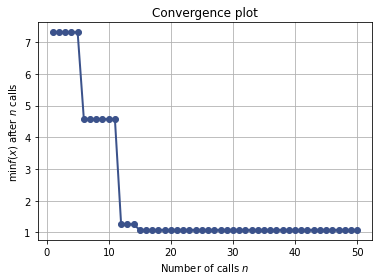

In [8]:
best_mean_squared_error = 9999999999999999
default_parameters =[0.5, 50, 2]
#dropout, filter_num, num_dense_layers
print_and_plot(default_parameters)

# Initial conditions try 2

In [9]:
#load and split data
x_train_pre, x_test_pre, y_train, y_test = train_test_split(X, Y, test_size=0.15)
scaler = StandardScaler().fit(x_train_pre) 
x_train = scaler.transform(x_train_pre) 
scaler = StandardScaler().fit(x_test_pre) 
x_test = scaler.transform(x_test_pre) 

dropout: 6.0e-01
filter_num: 200
num_dense_layers: 5

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 1s 213us/sample - loss: 58.0074 - val_loss: 31.3154
Epoch 2/100
2529/2529 [==============================] - 0s 40us/sample - loss: 48.0330 - val_loss: 32.3033
Epoch 3/100
2529/2529 [==============================] - 0s 35us/sample - loss: 44.9351 - val_loss: 32.8246
Epoch 4/100
2529/2529 [==============================] - 0s 34us/sample - loss: 42.4627 - val_loss: 30.3939
Epoch 5/100
2529/2529 [==============================] - 0s 35us/sample - loss: 39.9504 - val_loss: 30.8511
Epoch 6/100
2529/2529 [==============================] - 0s 35us/sample - loss: 39.5297 - val_loss: 31.0915
Epoch 7/100
2529/2529 [==============================] - 0s 35us/sample - loss: 37.2679 - val_loss: 28.6328
Epoch 8/100
2529/2529 [==============================] - 0s 35us/sample - loss: 35.8229 - val_loss: 28.6983
Epoch 9/100
2529/2529 [===========

2529/2529 [==============================] - 0s 34us/sample - loss: 10.5890 - val_loss: 26.0194
Epoch 76/100
2529/2529 [==============================] - 0s 36us/sample - loss: 9.4018 - val_loss: 26.5272
Epoch 77/100
2529/2529 [==============================] - 0s 34us/sample - loss: 9.8682 - val_loss: 26.6261
Epoch 78/100
2529/2529 [==============================] - 0s 34us/sample - loss: 15.4827 - val_loss: 26.3915
Epoch 79/100
2529/2529 [==============================] - 0s 34us/sample - loss: 12.2046 - val_loss: 26.6702
Epoch 80/100
2529/2529 [==============================] - 0s 35us/sample - loss: 13.0115 - val_loss: 26.6776
Epoch 81/100
2529/2529 [==============================] - 0s 34us/sample - loss: 14.0020 - val_loss: 26.7815
Epoch 82/100
2529/2529 [==============================] - 0s 36us/sample - loss: 14.0208 - val_loss: 25.5978
Epoch 83/100
2529/2529 [==============================] - 0s 35us/sample - loss: 11.5762 - val_loss: 25.7262
Epoch 84/100
2529/2529 [==========

2529/2529 [==============================] - 0s 13us/sample - loss: 37.1273 - val_loss: 30.4517
Epoch 50/100
2529/2529 [==============================] - 0s 14us/sample - loss: 38.8144 - val_loss: 30.1919
Epoch 51/100
2529/2529 [==============================] - 0s 14us/sample - loss: 42.1965 - val_loss: 29.8794
Epoch 52/100
2529/2529 [==============================] - 0s 13us/sample - loss: 38.5522 - val_loss: 29.5558
Epoch 53/100
2529/2529 [==============================] - 0s 13us/sample - loss: 37.0780 - val_loss: 29.4175
Epoch 54/100
2529/2529 [==============================] - 0s 13us/sample - loss: 38.4994 - val_loss: 29.5245
Epoch 55/100
2529/2529 [==============================] - 0s 13us/sample - loss: 38.3900 - val_loss: 29.4931
Epoch 56/100
2529/2529 [==============================] - 0s 13us/sample - loss: 38.1319 - val_loss: 29.4613
Epoch 57/100
2529/2529 [==============================] - 0s 13us/sample - loss: 36.7808 - val_loss: 29.2687
Epoch 58/100
2529/2529 [========

2529/2529 [==============================] - 0s 22us/sample - loss: 37.5812 - val_loss: 34.3051
Epoch 24/100
2529/2529 [==============================] - 0s 23us/sample - loss: 38.8615 - val_loss: 34.0336
Epoch 25/100
2529/2529 [==============================] - 0s 23us/sample - loss: 38.2022 - val_loss: 33.8947
Epoch 26/100
2529/2529 [==============================] - 0s 23us/sample - loss: 30.8064 - val_loss: 33.7240
Epoch 27/100
2529/2529 [==============================] - 0s 22us/sample - loss: 36.6645 - val_loss: 33.4849
Epoch 28/100
2529/2529 [==============================] - 0s 23us/sample - loss: 31.9359 - val_loss: 33.4603
Epoch 29/100
2529/2529 [==============================] - 0s 23us/sample - loss: 33.3555 - val_loss: 33.2510
Epoch 30/100
2529/2529 [==============================] - 0s 23us/sample - loss: 36.5202 - val_loss: 33.0945
Epoch 31/100
2529/2529 [==============================] - 0s 23us/sample - loss: 36.3138 - val_loss: 32.9122
Epoch 32/100
2529/2529 [========

2529/2529 [==============================] - 0s 23us/sample - loss: 25.2110 - val_loss: 26.8558
Epoch 99/100
2529/2529 [==============================] - 0s 23us/sample - loss: 21.6331 - val_loss: 27.1333
Epoch 100/100
2529/2529 [==============================] - 0s 23us/sample - loss: 23.5314 - val_loss: 27.0861

Mean squared error: 2.4e+01

dropout: 7.7e-01
filter_num: 67
num_dense_layers: 5

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 0s 170us/sample - loss: 59.6078 - val_loss: 37.6079
Epoch 2/100
2529/2529 [==============================] - 0s 21us/sample - loss: 53.4710 - val_loss: 36.9670
Epoch 3/100
2529/2529 [==============================] - 0s 19us/sample - loss: 51.8988 - val_loss: 36.9144
Epoch 4/100
2529/2529 [==============================] - 0s 19us/sample - loss: 51.9559 - val_loss: 37.0639
Epoch 5/100
2529/2529 [==============================] - 0s 18us/sample - loss: 51.0035 - val_loss: 37.0367
Epoch 6/100
25

2529/2529 [==============================] - 0s 19us/sample - loss: 29.9240 - val_loss: 27.3880
Epoch 73/100
2529/2529 [==============================] - 0s 19us/sample - loss: 28.3727 - val_loss: 27.3289
Epoch 74/100
2529/2529 [==============================] - 0s 19us/sample - loss: 27.7863 - val_loss: 27.0243
Epoch 75/100
2529/2529 [==============================] - 0s 19us/sample - loss: 29.2687 - val_loss: 26.7991
Epoch 76/100
2529/2529 [==============================] - 0s 19us/sample - loss: 33.1151 - val_loss: 27.2212
Epoch 77/100
2529/2529 [==============================] - 0s 19us/sample - loss: 31.3538 - val_loss: 27.4764
Epoch 78/100
2529/2529 [==============================] - 0s 18us/sample - loss: 25.4335 - val_loss: 27.2928
Epoch 79/100
2529/2529 [==============================] - 0s 19us/sample - loss: 28.8575 - val_loss: 26.9973
Epoch 80/100
2529/2529 [==============================] - 0s 19us/sample - loss: 25.1077 - val_loss: 26.7764
Epoch 81/100
2529/2529 [========

2529/2529 [==============================] - 0s 78us/sample - loss: 24.3147 - val_loss: 27.9458
Epoch 47/100
2529/2529 [==============================] - 0s 79us/sample - loss: 24.0134 - val_loss: 29.3035
Epoch 48/100
2529/2529 [==============================] - 0s 87us/sample - loss: 27.9113 - val_loss: 28.6066
Epoch 49/100
2529/2529 [==============================] - 0s 79us/sample - loss: 24.2404 - val_loss: 27.5224
Epoch 50/100
2529/2529 [==============================] - 0s 83us/sample - loss: 23.5656 - val_loss: 27.9377
Epoch 51/100
2529/2529 [==============================] - 0s 77us/sample - loss: 20.3334 - val_loss: 26.7525
Epoch 52/100
2529/2529 [==============================] - 0s 79us/sample - loss: 37.7335 - val_loss: 30.9874
Epoch 53/100
2529/2529 [==============================] - 0s 77us/sample - loss: 36.5878 - val_loss: 30.8858
Epoch 54/100
2529/2529 [==============================] - 0s 77us/sample - loss: 28.8122 - val_loss: 26.8799
Epoch 55/100
2529/2529 [========

2529/2529 [==============================] - 0s 25us/sample - loss: 47.6252 - val_loss: 34.5178
Epoch 21/100
2529/2529 [==============================] - 0s 26us/sample - loss: 45.2870 - val_loss: 34.3436
Epoch 22/100
2529/2529 [==============================] - 0s 25us/sample - loss: 45.5109 - val_loss: 34.4503
Epoch 23/100
2529/2529 [==============================] - 0s 25us/sample - loss: 44.4603 - val_loss: 34.3053
Epoch 24/100
2529/2529 [==============================] - 0s 25us/sample - loss: 43.9314 - val_loss: 33.9394
Epoch 25/100
2529/2529 [==============================] - 0s 25us/sample - loss: 42.9188 - val_loss: 33.7643
Epoch 26/100
2529/2529 [==============================] - 0s 25us/sample - loss: 43.9950 - val_loss: 33.8985
Epoch 27/100
2529/2529 [==============================] - 0s 25us/sample - loss: 44.4557 - val_loss: 33.6516
Epoch 28/100
2529/2529 [==============================] - 0s 26us/sample - loss: 43.3332 - val_loss: 33.2267
Epoch 29/100
2529/2529 [========

2529/2529 [==============================] - 0s 26us/sample - loss: 31.2792 - val_loss: 27.9050
Epoch 96/100
2529/2529 [==============================] - 0s 26us/sample - loss: 35.2587 - val_loss: 27.6191
Epoch 97/100
2529/2529 [==============================] - 0s 25us/sample - loss: 33.5883 - val_loss: 27.2294
Epoch 98/100
2529/2529 [==============================] - 0s 25us/sample - loss: 37.1316 - val_loss: 27.4564
Epoch 99/100
2529/2529 [==============================] - 0s 25us/sample - loss: 34.0502 - val_loss: 27.6970
Epoch 100/100
2529/2529 [==============================] - 0s 25us/sample - loss: 33.9894 - val_loss: 27.6474

Mean squared error: 3.4e+01

dropout: 5.6e-01
filter_num: 34
num_dense_layers: 16

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 1s 386us/sample - loss: 63.7835 - val_loss: 38.0012
Epoch 2/100
2529/2529 [==============================] - 0s 31us/sample - loss: 62.0934 - val_loss: 37.7727
Epoch 3/10

2529/2529 [==============================] - 0s 26us/sample - loss: 39.1571 - val_loss: 30.1575
Epoch 70/100
2529/2529 [==============================] - 0s 25us/sample - loss: 45.0505 - val_loss: 29.6255
Epoch 71/100
2529/2529 [==============================] - 0s 24us/sample - loss: 38.9714 - val_loss: 29.0706
Epoch 72/100
2529/2529 [==============================] - 0s 25us/sample - loss: 40.2238 - val_loss: 28.8316
Epoch 73/100
2529/2529 [==============================] - 0s 25us/sample - loss: 42.7341 - val_loss: 28.7189
Epoch 74/100
2529/2529 [==============================] - 0s 25us/sample - loss: 46.3277 - val_loss: 29.3545
Epoch 75/100
2529/2529 [==============================] - 0s 25us/sample - loss: 43.0449 - val_loss: 29.3714
Epoch 76/100
2529/2529 [==============================] - 0s 25us/sample - loss: 40.9437 - val_loss: 29.1813
Epoch 77/100
2529/2529 [==============================] - 0s 24us/sample - loss: 43.6620 - val_loss: 28.6981
Epoch 78/100
2529/2529 [========

2529/2529 [==============================] - 0s 25us/sample - loss: 24.8033 - val_loss: 29.4167
Epoch 44/100
2529/2529 [==============================] - 0s 26us/sample - loss: 28.3280 - val_loss: 29.4897
Epoch 45/100
2529/2529 [==============================] - 0s 25us/sample - loss: 22.1529 - val_loss: 29.3172
Epoch 46/100
2529/2529 [==============================] - 0s 25us/sample - loss: 24.6282 - val_loss: 28.9732
Epoch 47/100
2529/2529 [==============================] - 0s 24us/sample - loss: 24.8879 - val_loss: 28.7213
Epoch 48/100
2529/2529 [==============================] - 0s 24us/sample - loss: 24.0877 - val_loss: 28.6727
Epoch 49/100
2529/2529 [==============================] - 0s 26us/sample - loss: 23.1082 - val_loss: 27.9747
Epoch 50/100
2529/2529 [==============================] - 0s 24us/sample - loss: 30.3388 - val_loss: 27.8459
Epoch 51/100
2529/2529 [==============================] - 0s 24us/sample - loss: 26.2021 - val_loss: 28.6789
Epoch 52/100
2529/2529 [========

2529/2529 [==============================] - 0s 34us/sample - loss: 31.5228 - val_loss: 34.4164
Epoch 18/100
2529/2529 [==============================] - 0s 32us/sample - loss: 31.1770 - val_loss: 34.2753
Epoch 19/100
2529/2529 [==============================] - 0s 34us/sample - loss: 31.8537 - val_loss: 34.2280
Epoch 20/100
2529/2529 [==============================] - 0s 33us/sample - loss: 28.9661 - val_loss: 34.2934
Epoch 21/100
2529/2529 [==============================] - 0s 33us/sample - loss: 30.3249 - val_loss: 33.5034
Epoch 22/100
2529/2529 [==============================] - 0s 33us/sample - loss: 28.6105 - val_loss: 33.4545
Epoch 23/100
2529/2529 [==============================] - 0s 34us/sample - loss: 27.6065 - val_loss: 33.6218
Epoch 24/100
2529/2529 [==============================] - 0s 34us/sample - loss: 29.6507 - val_loss: 33.5327
Epoch 25/100
2529/2529 [==============================] - 0s 33us/sample - loss: 29.7985 - val_loss: 32.8550
Epoch 26/100
2529/2529 [========

2529/2529 [==============================] - 0s 29us/sample - loss: 16.4897 - val_loss: 27.6466
Epoch 93/100
2529/2529 [==============================] - 0s 40us/sample - loss: 14.5455 - val_loss: 27.2248
Epoch 94/100
2529/2529 [==============================] - 0s 33us/sample - loss: 14.1212 - val_loss: 26.9437
Epoch 95/100
2529/2529 [==============================] - 0s 33us/sample - loss: 14.6978 - val_loss: 27.0681
Epoch 96/100
2529/2529 [==============================] - 0s 33us/sample - loss: 16.3420 - val_loss: 27.4150
Epoch 97/100
2529/2529 [==============================] - 0s 33us/sample - loss: 16.5089 - val_loss: 27.2026
Epoch 98/100
2529/2529 [==============================] - 0s 33us/sample - loss: 15.8663 - val_loss: 27.0121
Epoch 99/100
2529/2529 [==============================] - 0s 33us/sample - loss: 17.0865 - val_loss: 27.4252
Epoch 100/100
2529/2529 [==============================] - 0s 33us/sample - loss: 17.1366 - val_loss: 27.8357

Mean squared error: 1.7e+01

d

2529/2529 [==============================] - 0s 21us/sample - loss: 16.2035 - val_loss: 24.7629
Epoch 67/100
2529/2529 [==============================] - 0s 21us/sample - loss: 15.6379 - val_loss: 24.2600
Epoch 68/100
2529/2529 [==============================] - 0s 21us/sample - loss: 14.4673 - val_loss: 23.9478
Epoch 69/100
2529/2529 [==============================] - 0s 20us/sample - loss: 11.9852 - val_loss: 22.9744
Epoch 70/100
2529/2529 [==============================] - 0s 21us/sample - loss: 12.8821 - val_loss: 23.7502
Epoch 71/100
2529/2529 [==============================] - 0s 21us/sample - loss: 12.0694 - val_loss: 24.1304
Epoch 72/100
2529/2529 [==============================] - 0s 21us/sample - loss: 10.3444 - val_loss: 24.3718
Epoch 73/100
2529/2529 [==============================] - 0s 21us/sample - loss: 12.0830 - val_loss: 25.1497
Epoch 74/100
2529/2529 [==============================] - 0s 20us/sample - loss: 12.0336 - val_loss: 25.3996
Epoch 75/100
2529/2529 [========

2529/2529 [==============================] - 0s 44us/sample - loss: 34.2571 - val_loss: 30.3557
Epoch 41/100
2529/2529 [==============================] - 0s 44us/sample - loss: 35.4155 - val_loss: 30.0616
Epoch 42/100
2529/2529 [==============================] - 0s 43us/sample - loss: 35.4690 - val_loss: 29.9253
Epoch 43/100
2529/2529 [==============================] - 0s 43us/sample - loss: 35.5098 - val_loss: 29.9348
Epoch 44/100
2529/2529 [==============================] - 0s 44us/sample - loss: 32.2257 - val_loss: 29.4636
Epoch 45/100
2529/2529 [==============================] - 0s 43us/sample - loss: 43.0384 - val_loss: 30.3717
Epoch 46/100
2529/2529 [==============================] - 0s 42us/sample - loss: 33.3239 - val_loss: 30.0089
Epoch 47/100
2529/2529 [==============================] - 0s 46us/sample - loss: 30.9788 - val_loss: 29.3966
Epoch 48/100
2529/2529 [==============================] - 0s 42us/sample - loss: 36.2052 - val_loss: 30.0806
Epoch 49/100
2529/2529 [========

2529/2529 [==============================] - 0s 17us/sample - loss: 24.3843 - val_loss: 22.9033
Epoch 15/100
2529/2529 [==============================] - 0s 16us/sample - loss: 22.3347 - val_loss: 22.0773
Epoch 16/100
2529/2529 [==============================] - 0s 17us/sample - loss: 21.5750 - val_loss: 23.9551
Epoch 17/100
2529/2529 [==============================] - 0s 16us/sample - loss: 19.9137 - val_loss: 24.3288
Epoch 18/100
2529/2529 [==============================] - 0s 17us/sample - loss: 18.8384 - val_loss: 30.0151
Epoch 19/100
2529/2529 [==============================] - 0s 16us/sample - loss: 18.2229 - val_loss: 27.5746
Epoch 20/100
2529/2529 [==============================] - 0s 16us/sample - loss: 18.2405 - val_loss: 24.3090
Epoch 21/100
2529/2529 [==============================] - 0s 17us/sample - loss: 14.9249 - val_loss: 37.5541
Epoch 22/100
2529/2529 [==============================] - 0s 16us/sample - loss: 17.7816 - val_loss: 30.3300
Epoch 23/100
2529/2529 [========

Epoch 90/100
2529/2529 [==============================] - 0s 15us/sample - loss: 3.6153 - val_loss: 27.7735
Epoch 91/100
2529/2529 [==============================] - 0s 15us/sample - loss: 2.5105 - val_loss: 32.4267
Epoch 92/100
2529/2529 [==============================] - 0s 15us/sample - loss: 4.9935 - val_loss: 32.4180
Epoch 93/100
2529/2529 [==============================] - 0s 15us/sample - loss: 6.7182 - val_loss: 31.1262
Epoch 94/100
2529/2529 [==============================] - 0s 15us/sample - loss: 5.1835 - val_loss: 32.2841
Epoch 95/100
2529/2529 [==============================] - 0s 15us/sample - loss: 3.6562 - val_loss: 29.6292
Epoch 96/100
2529/2529 [==============================] - 0s 15us/sample - loss: 3.3398 - val_loss: 31.2028
Epoch 97/100
2529/2529 [==============================] - 0s 15us/sample - loss: 4.1100 - val_loss: 30.1784
Epoch 98/100
2529/2529 [==============================] - 0s 15us/sample - loss: 3.6146 - val_loss: 29.1615
Epoch 99/100
2529/2529 [====

2529/2529 [==============================] - 0s 9us/sample - loss: 21.1347 - val_loss: 33.8646
Epoch 65/100
2529/2529 [==============================] - 0s 9us/sample - loss: 19.9716 - val_loss: 35.4675
Epoch 66/100
2529/2529 [==============================] - 0s 10us/sample - loss: 19.7283 - val_loss: 37.1818
Epoch 67/100
2529/2529 [==============================] - 0s 9us/sample - loss: 20.7539 - val_loss: 38.9500
Epoch 68/100
2529/2529 [==============================] - 0s 10us/sample - loss: 22.8796 - val_loss: 41.9380
Epoch 69/100
2529/2529 [==============================] - 0s 9us/sample - loss: 20.6304 - val_loss: 49.2603
Epoch 70/100
2529/2529 [==============================] - 0s 10us/sample - loss: 19.6650 - val_loss: 53.1010
Epoch 71/100
2529/2529 [==============================] - 0s 9us/sample - loss: 19.4840 - val_loss: 52.6002
Epoch 72/100
2529/2529 [==============================] - 0s 9us/sample - loss: 17.7711 - val_loss: 56.1182
Epoch 73/100
2529/2529 [==============

2529/2529 [==============================] - 0s 16us/sample - loss: 6.4106 - val_loss: 72.8361
Epoch 39/100
2529/2529 [==============================] - 0s 16us/sample - loss: 5.1231 - val_loss: 63.2388
Epoch 40/100
2529/2529 [==============================] - 0s 16us/sample - loss: 5.2970 - val_loss: 70.3580
Epoch 41/100
2529/2529 [==============================] - 0s 16us/sample - loss: 5.1819 - val_loss: 63.7707
Epoch 42/100
2529/2529 [==============================] - 0s 16us/sample - loss: 4.5004 - val_loss: 65.7919
Epoch 43/100
2529/2529 [==============================] - 0s 15us/sample - loss: 4.6666 - val_loss: 67.1920
Epoch 44/100
2529/2529 [==============================] - 0s 16us/sample - loss: 4.3812 - val_loss: 65.3406
Epoch 45/100
2529/2529 [==============================] - 0s 16us/sample - loss: 3.8941 - val_loss: 64.5209
Epoch 46/100
2529/2529 [==============================] - 0s 16us/sample - loss: 3.9590 - val_loss: 67.2169
Epoch 47/100
2529/2529 [=================

Epoch 13/100
2529/2529 [==============================] - 0s 28us/sample - loss: 19.0961 - val_loss: 27.7348
Epoch 14/100
2529/2529 [==============================] - 0s 28us/sample - loss: 16.1909 - val_loss: 26.4592
Epoch 15/100
2529/2529 [==============================] - 0s 27us/sample - loss: 14.4350 - val_loss: 28.5815
Epoch 16/100
2529/2529 [==============================] - 0s 27us/sample - loss: 12.1316 - val_loss: 26.9312
Epoch 17/100
2529/2529 [==============================] - 0s 28us/sample - loss: 10.4072 - val_loss: 29.4358
Epoch 18/100
2529/2529 [==============================] - 0s 27us/sample - loss: 9.4209 - val_loss: 24.5847
Epoch 19/100
2529/2529 [==============================] - 0s 27us/sample - loss: 8.1521 - val_loss: 30.3613
Epoch 20/100
2529/2529 [==============================] - 0s 27us/sample - loss: 7.0833 - val_loss: 24.5611
Epoch 21/100
2529/2529 [==============================] - 0s 28us/sample - loss: 6.7836 - val_loss: 29.6669
Epoch 22/100
2529/2529 

Epoch 89/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.6671 - val_loss: 25.5949
Epoch 90/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.5376 - val_loss: 28.6712
Epoch 91/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.5577 - val_loss: 24.0444
Epoch 92/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.2269 - val_loss: 27.1817
Epoch 93/100
2529/2529 [==============================] - 0s 28us/sample - loss: 1.7943 - val_loss: 26.0015
Epoch 94/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.5025 - val_loss: 28.7985
Epoch 95/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.4882 - val_loss: 26.2380
Epoch 96/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.2023 - val_loss: 26.4062
Epoch 97/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.2298 - val_loss: 25.3063
Epoch 98/100
2529/2529 [====

2529/2529 [==============================] - 0s 56us/sample - loss: 5.5505 - val_loss: 23.0827
Epoch 64/100
2529/2529 [==============================] - 0s 51us/sample - loss: 4.8898 - val_loss: 22.1997
Epoch 65/100
2529/2529 [==============================] - 0s 45us/sample - loss: 4.9658 - val_loss: 21.5082
Epoch 66/100
2529/2529 [==============================] - 0s 56us/sample - loss: 4.5581 - val_loss: 22.3697
Epoch 67/100
2529/2529 [==============================] - 0s 52us/sample - loss: 4.8057 - val_loss: 23.2388
Epoch 68/100
2529/2529 [==============================] - 0s 52us/sample - loss: 4.5453 - val_loss: 22.5725
Epoch 69/100
2529/2529 [==============================] - 0s 51us/sample - loss: 4.8807 - val_loss: 22.3070
Epoch 70/100
2529/2529 [==============================] - 0s 51us/sample - loss: 13.7151 - val_loss: 22.2844
Epoch 71/100
2529/2529 [==============================] - 0s 45us/sample - loss: 9.2676 - val_loss: 22.0619
Epoch 72/100
2529/2529 [================

2529/2529 [==============================] - 0s 25us/sample - loss: 4.5489 - val_loss: 23.1452
Epoch 38/100
2529/2529 [==============================] - 0s 26us/sample - loss: 4.7824 - val_loss: 25.9416
Epoch 39/100
2529/2529 [==============================] - 0s 26us/sample - loss: 4.2805 - val_loss: 25.4996
Epoch 40/100
2529/2529 [==============================] - 0s 26us/sample - loss: 3.5004 - val_loss: 26.7080
Epoch 41/100
2529/2529 [==============================] - 0s 25us/sample - loss: 3.4727 - val_loss: 25.0110
Epoch 42/100
2529/2529 [==============================] - 0s 25us/sample - loss: 3.8990 - val_loss: 24.5460
Epoch 43/100
2529/2529 [==============================] - 0s 25us/sample - loss: 3.3881 - val_loss: 23.8792
Epoch 44/100
2529/2529 [==============================] - 0s 25us/sample - loss: 3.0520 - val_loss: 25.1710
Epoch 45/100
2529/2529 [==============================] - 0s 25us/sample - loss: 3.1636 - val_loss: 25.1915
Epoch 46/100
2529/2529 [=================

Epoch 12/100
2529/2529 [==============================] - 0s 20us/sample - loss: 21.1722 - val_loss: 26.3128
Epoch 13/100
2529/2529 [==============================] - 0s 19us/sample - loss: 19.3193 - val_loss: 26.1009
Epoch 14/100
2529/2529 [==============================] - 0s 20us/sample - loss: 17.0874 - val_loss: 27.8336
Epoch 15/100
2529/2529 [==============================] - 0s 19us/sample - loss: 15.2407 - val_loss: 27.5165
Epoch 16/100
2529/2529 [==============================] - 0s 20us/sample - loss: 14.0300 - val_loss: 30.5917
Epoch 17/100
2529/2529 [==============================] - 0s 20us/sample - loss: 11.3820 - val_loss: 32.2364
Epoch 18/100
2529/2529 [==============================] - 0s 19us/sample - loss: 10.1476 - val_loss: 31.3321
Epoch 19/100
2529/2529 [==============================] - 0s 19us/sample - loss: 9.4535 - val_loss: 28.8748
Epoch 20/100
2529/2529 [==============================] - 0s 19us/sample - loss: 7.5901 - val_loss: 34.5582
Epoch 21/100
2529/252

2529/2529 [==============================] - 0s 20us/sample - loss: 1.3597 - val_loss: 30.4803
Epoch 88/100
2529/2529 [==============================] - 0s 20us/sample - loss: 1.5256 - val_loss: 29.3692
Epoch 89/100
2529/2529 [==============================] - 0s 20us/sample - loss: 1.7350 - val_loss: 31.0853
Epoch 90/100
2529/2529 [==============================] - 0s 21us/sample - loss: 1.4327 - val_loss: 31.0604
Epoch 91/100
2529/2529 [==============================] - 0s 20us/sample - loss: 1.2928 - val_loss: 32.1641
Epoch 92/100
2529/2529 [==============================] - 0s 19us/sample - loss: 1.4001 - val_loss: 28.8555
Epoch 93/100
2529/2529 [==============================] - 0s 20us/sample - loss: 1.3683 - val_loss: 30.3132
Epoch 94/100
2529/2529 [==============================] - 0s 20us/sample - loss: 1.2746 - val_loss: 29.5718
Epoch 95/100
2529/2529 [==============================] - 0s 20us/sample - loss: 1.3995 - val_loss: 29.6974
Epoch 96/100
2529/2529 [=================

2529/2529 [==============================] - 0s 54us/sample - loss: 5.8583 - val_loss: 24.1429
Epoch 62/100
2529/2529 [==============================] - 0s 56us/sample - loss: 4.9782 - val_loss: 25.7777
Epoch 63/100
2529/2529 [==============================] - 0s 52us/sample - loss: 3.8784 - val_loss: 26.1658
Epoch 64/100
2529/2529 [==============================] - 0s 57us/sample - loss: 5.5167 - val_loss: 22.7074
Epoch 65/100
2529/2529 [==============================] - 0s 53us/sample - loss: 5.4940 - val_loss: 27.9597
Epoch 66/100
2529/2529 [==============================] - 0s 53us/sample - loss: 4.2677 - val_loss: 25.8807
Epoch 67/100
2529/2529 [==============================] - 0s 54us/sample - loss: 4.3781 - val_loss: 27.5261
Epoch 68/100
2529/2529 [==============================] - 0s 51us/sample - loss: 5.5102 - val_loss: 27.1897
Epoch 69/100
2529/2529 [==============================] - 0s 56us/sample - loss: 3.4301 - val_loss: 26.5956
Epoch 70/100
2529/2529 [=================

2529/2529 [==============================] - 0s 35us/sample - loss: 12.4522 - val_loss: 22.4909
Epoch 36/100
2529/2529 [==============================] - 0s 36us/sample - loss: 10.9277 - val_loss: 21.2167
Epoch 37/100
2529/2529 [==============================] - 0s 35us/sample - loss: 11.4559 - val_loss: 21.5359
Epoch 38/100
2529/2529 [==============================] - 0s 36us/sample - loss: 12.0176 - val_loss: 20.8821
Epoch 39/100
2529/2529 [==============================] - 0s 36us/sample - loss: 11.4468 - val_loss: 20.0848
Epoch 40/100
2529/2529 [==============================] - 0s 36us/sample - loss: 10.8894 - val_loss: 20.4236
Epoch 41/100
2529/2529 [==============================] - 0s 35us/sample - loss: 13.4086 - val_loss: 22.4638
Epoch 42/100
2529/2529 [==============================] - 0s 37us/sample - loss: 11.8154 - val_loss: 19.7824
Epoch 43/100
2529/2529 [==============================] - 0s 39us/sample - loss: 10.5603 - val_loss: 21.6100
Epoch 44/100
2529/2529 [========

2529/2529 [==============================] - 0s 19us/sample - loss: 22.6993 - val_loss: 22.5270
Epoch 10/100
2529/2529 [==============================] - 0s 20us/sample - loss: 20.1949 - val_loss: 26.2830
Epoch 11/100
2529/2529 [==============================] - 0s 20us/sample - loss: 18.0436 - val_loss: 28.5374
Epoch 12/100
2529/2529 [==============================] - 0s 20us/sample - loss: 17.2454 - val_loss: 24.5908
Epoch 13/100
2529/2529 [==============================] - 0s 20us/sample - loss: 13.9364 - val_loss: 30.7868
Epoch 14/100
2529/2529 [==============================] - 0s 19us/sample - loss: 12.2561 - val_loss: 25.1936
Epoch 15/100
2529/2529 [==============================] - 0s 19us/sample - loss: 10.2841 - val_loss: 24.9244
Epoch 16/100
2529/2529 [==============================] - 0s 20us/sample - loss: 12.6580 - val_loss: 25.8540
Epoch 17/100
2529/2529 [==============================] - 0s 20us/sample - loss: 12.9898 - val_loss: 29.2325
Epoch 18/100
2529/2529 [========

Epoch 85/100
2529/2529 [==============================] - 0s 20us/sample - loss: 1.0773 - val_loss: 25.4485
Epoch 86/100
2529/2529 [==============================] - 0s 20us/sample - loss: 1.1278 - val_loss: 23.9630
Epoch 87/100
2529/2529 [==============================] - 0s 20us/sample - loss: 1.5924 - val_loss: 24.2276
Epoch 88/100
2529/2529 [==============================] - 0s 20us/sample - loss: 1.6364 - val_loss: 23.1017
Epoch 89/100
2529/2529 [==============================] - 0s 20us/sample - loss: 1.6333 - val_loss: 23.3479
Epoch 90/100
2529/2529 [==============================] - 0s 20us/sample - loss: 1.2829 - val_loss: 22.3101
Epoch 91/100
2529/2529 [==============================] - 0s 19us/sample - loss: 1.4125 - val_loss: 23.3733
Epoch 92/100
2529/2529 [==============================] - 0s 20us/sample - loss: 1.2601 - val_loss: 23.2401
Epoch 93/100
2529/2529 [==============================] - 0s 19us/sample - loss: 1.3485 - val_loss: 23.7902
Epoch 94/100
2529/2529 [====

2529/2529 [==============================] - 0s 22us/sample - loss: 1.8265 - val_loss: 25.9970
Epoch 60/100
2529/2529 [==============================] - 0s 22us/sample - loss: 1.7709 - val_loss: 25.5423
Epoch 61/100
2529/2529 [==============================] - 0s 21us/sample - loss: 1.6812 - val_loss: 24.0463
Epoch 62/100
2529/2529 [==============================] - 0s 22us/sample - loss: 2.0594 - val_loss: 25.8087
Epoch 63/100
2529/2529 [==============================] - 0s 21us/sample - loss: 2.0595 - val_loss: 24.2324
Epoch 64/100
2529/2529 [==============================] - 0s 21us/sample - loss: 2.1572 - val_loss: 25.2743
Epoch 65/100
2529/2529 [==============================] - 0s 21us/sample - loss: 2.0374 - val_loss: 26.2642
Epoch 66/100
2529/2529 [==============================] - 0s 21us/sample - loss: 1.7160 - val_loss: 25.6235
Epoch 67/100
2529/2529 [==============================] - 0s 21us/sample - loss: 1.6512 - val_loss: 24.1509
Epoch 68/100
2529/2529 [=================

2529/2529 [==============================] - 0s 19us/sample - loss: 4.9903 - val_loss: 34.2212
Epoch 34/100
2529/2529 [==============================] - 0s 20us/sample - loss: 4.6386 - val_loss: 29.5632
Epoch 35/100
2529/2529 [==============================] - 0s 20us/sample - loss: 4.7955 - val_loss: 32.5930
Epoch 36/100
2529/2529 [==============================] - 0s 19us/sample - loss: 4.4376 - val_loss: 31.7090
Epoch 37/100
2529/2529 [==============================] - 0s 19us/sample - loss: 4.2842 - val_loss: 31.4747
Epoch 38/100
2529/2529 [==============================] - 0s 19us/sample - loss: 4.0934 - val_loss: 32.2480
Epoch 39/100
2529/2529 [==============================] - 0s 19us/sample - loss: 4.3250 - val_loss: 30.3969
Epoch 40/100
2529/2529 [==============================] - 0s 19us/sample - loss: 3.9058 - val_loss: 33.7302
Epoch 41/100
2529/2529 [==============================] - 0s 19us/sample - loss: 3.9590 - val_loss: 34.6280
Epoch 42/100
2529/2529 [=================

Epoch 8/100
2529/2529 [==============================] - 0s 16us/sample - loss: 56.3918 - val_loss: 30.7670
Epoch 9/100
2529/2529 [==============================] - 0s 16us/sample - loss: 50.6367 - val_loss: 24.8550
Epoch 10/100
2529/2529 [==============================] - 0s 16us/sample - loss: 46.5108 - val_loss: 23.3282
Epoch 11/100
2529/2529 [==============================] - 0s 16us/sample - loss: 46.9270 - val_loss: 25.8634
Epoch 12/100
2529/2529 [==============================] - 0s 16us/sample - loss: 45.8855 - val_loss: 26.4172
Epoch 13/100
2529/2529 [==============================] - 0s 16us/sample - loss: 46.1984 - val_loss: 25.2605
Epoch 14/100
2529/2529 [==============================] - 0s 16us/sample - loss: 44.5885 - val_loss: 23.6995
Epoch 15/100
2529/2529 [==============================] - 0s 16us/sample - loss: 42.6647 - val_loss: 23.9673
Epoch 16/100
2529/2529 [==============================] - 0s 15us/sample - loss: 40.8266 - val_loss: 23.1222
Epoch 17/100
2529/252

2529/2529 [==============================] - 0s 14us/sample - loss: 21.4095 - val_loss: 36.4438
Epoch 84/100
2529/2529 [==============================] - 0s 15us/sample - loss: 24.8909 - val_loss: 36.2862
Epoch 85/100
2529/2529 [==============================] - 0s 14us/sample - loss: 18.8605 - val_loss: 38.1721
Epoch 86/100
2529/2529 [==============================] - 0s 15us/sample - loss: 21.8704 - val_loss: 37.1577
Epoch 87/100
2529/2529 [==============================] - 0s 15us/sample - loss: 23.9720 - val_loss: 36.6056
Epoch 88/100
2529/2529 [==============================] - 0s 13us/sample - loss: 18.2041 - val_loss: 38.8141
Epoch 89/100
2529/2529 [==============================] - 0s 14us/sample - loss: 17.9583 - val_loss: 43.3688
Epoch 90/100
2529/2529 [==============================] - 0s 14us/sample - loss: 19.7545 - val_loss: 43.8819
Epoch 91/100
2529/2529 [==============================] - 0s 15us/sample - loss: 19.5944 - val_loss: 44.2799
Epoch 92/100
2529/2529 [========

2529/2529 [==============================] - 0s 18us/sample - loss: 1.9281 - val_loss: 40.2411
Epoch 58/100
2529/2529 [==============================] - 0s 18us/sample - loss: 2.0993 - val_loss: 39.1578
Epoch 59/100
2529/2529 [==============================] - 0s 18us/sample - loss: 1.8564 - val_loss: 42.1143
Epoch 60/100
2529/2529 [==============================] - 0s 18us/sample - loss: 1.9077 - val_loss: 42.6366
Epoch 61/100
2529/2529 [==============================] - 0s 17us/sample - loss: 1.7946 - val_loss: 44.7520
Epoch 62/100
2529/2529 [==============================] - 0s 17us/sample - loss: 1.9868 - val_loss: 42.7092
Epoch 63/100
2529/2529 [==============================] - 0s 18us/sample - loss: 1.8381 - val_loss: 40.5259
Epoch 64/100
2529/2529 [==============================] - 0s 18us/sample - loss: 1.6890 - val_loss: 43.8375
Epoch 65/100
2529/2529 [==============================] - 0s 17us/sample - loss: 2.0150 - val_loss: 46.7698
Epoch 66/100
2529/2529 [=================

2529/2529 [==============================] - 0s 34us/sample - loss: 11.9127 - val_loss: 26.6537
Epoch 32/100
2529/2529 [==============================] - 0s 33us/sample - loss: 11.3837 - val_loss: 24.1120
Epoch 33/100
2529/2529 [==============================] - 0s 34us/sample - loss: 10.1139 - val_loss: 27.6414
Epoch 34/100
2529/2529 [==============================] - 0s 34us/sample - loss: 9.0360 - val_loss: 26.7564
Epoch 35/100
2529/2529 [==============================] - 0s 34us/sample - loss: 7.9808 - val_loss: 29.6585
Epoch 36/100
2529/2529 [==============================] - 0s 33us/sample - loss: 9.9318 - val_loss: 29.4222
Epoch 37/100
2529/2529 [==============================] - 0s 34us/sample - loss: 9.8065 - val_loss: 29.1301
Epoch 38/100
2529/2529 [==============================] - 0s 33us/sample - loss: 8.9619 - val_loss: 26.3907
Epoch 39/100
2529/2529 [==============================] - 0s 33us/sample - loss: 13.2779 - val_loss: 23.2496
Epoch 40/100
2529/2529 [=============

2529/2529 [==============================] - 0s 13us/sample - loss: 41.6369 - val_loss: 23.6754
Epoch 6/100
2529/2529 [==============================] - 0s 12us/sample - loss: 37.6073 - val_loss: 19.9851
Epoch 7/100
2529/2529 [==============================] - 0s 13us/sample - loss: 35.8793 - val_loss: 18.9678
Epoch 8/100
2529/2529 [==============================] - 0s 13us/sample - loss: 33.7388 - val_loss: 18.4883
Epoch 9/100
2529/2529 [==============================] - 0s 12us/sample - loss: 31.4053 - val_loss: 19.0541
Epoch 10/100
2529/2529 [==============================] - 0s 12us/sample - loss: 29.9180 - val_loss: 18.6724
Epoch 11/100
2529/2529 [==============================] - 0s 12us/sample - loss: 30.9483 - val_loss: 18.4639
Epoch 12/100
2529/2529 [==============================] - 0s 12us/sample - loss: 29.0102 - val_loss: 19.9856
Epoch 13/100
2529/2529 [==============================] - 0s 13us/sample - loss: 28.9330 - val_loss: 19.6134
Epoch 14/100
2529/2529 [============

2529/2529 [==============================] - 0s 12us/sample - loss: 3.7993 - val_loss: 126.0343
Epoch 81/100
2529/2529 [==============================] - 0s 13us/sample - loss: 3.9827 - val_loss: 118.1921
Epoch 82/100
2529/2529 [==============================] - 0s 12us/sample - loss: 4.0029 - val_loss: 128.6692
Epoch 83/100
2529/2529 [==============================] - 0s 12us/sample - loss: 4.6350 - val_loss: 110.9656
Epoch 84/100
2529/2529 [==============================] - 0s 12us/sample - loss: 4.6907 - val_loss: 92.7501
Epoch 85/100
2529/2529 [==============================] - 0s 12us/sample - loss: 5.3622 - val_loss: 106.9655
Epoch 86/100
2529/2529 [==============================] - 0s 12us/sample - loss: 5.4509 - val_loss: 108.7127
Epoch 87/100
2529/2529 [==============================] - 0s 12us/sample - loss: 4.2481 - val_loss: 107.8367
Epoch 88/100
2529/2529 [==============================] - 0s 12us/sample - loss: 5.1681 - val_loss: 128.8452
Epoch 89/100
2529/2529 [=========

2529/2529 [==============================] - 0s 167us/sample - loss: 16.2197 - val_loss: 21.3569
Epoch 54/100
2529/2529 [==============================] - 0s 167us/sample - loss: 21.5066 - val_loss: 20.8601
Epoch 55/100
2529/2529 [==============================] - 0s 167us/sample - loss: 20.6341 - val_loss: 21.5394
Epoch 56/100
2529/2529 [==============================] - 0s 166us/sample - loss: 21.8522 - val_loss: 21.8303
Epoch 57/100
2529/2529 [==============================] - 0s 168us/sample - loss: 27.0794 - val_loss: 19.0383
Epoch 58/100
2529/2529 [==============================] - 0s 167us/sample - loss: 20.6163 - val_loss: 21.8361
Epoch 59/100
2529/2529 [==============================] - 0s 166us/sample - loss: 18.2583 - val_loss: 22.8096
Epoch 60/100
2529/2529 [==============================] - 0s 167us/sample - loss: 19.2205 - val_loss: 20.4860
Epoch 61/100
2529/2529 [==============================] - 0s 168us/sample - loss: 14.8432 - val_loss: 20.1834
Epoch 62/100
2529/2529 

Epoch 27/100
2529/2529 [==============================] - 0s 15us/sample - loss: 7.5423 - val_loss: 52.2345
Epoch 28/100
2529/2529 [==============================] - 0s 15us/sample - loss: 6.2181 - val_loss: 60.1927
Epoch 29/100
2529/2529 [==============================] - 0s 15us/sample - loss: 6.0194 - val_loss: 53.3538
Epoch 30/100
2529/2529 [==============================] - 0s 15us/sample - loss: 5.7849 - val_loss: 57.8369
Epoch 31/100
2529/2529 [==============================] - 0s 15us/sample - loss: 5.1524 - val_loss: 55.9810
Epoch 32/100
2529/2529 [==============================] - 0s 15us/sample - loss: 5.2200 - val_loss: 58.8550
Epoch 33/100
2529/2529 [==============================] - 0s 15us/sample - loss: 4.5748 - val_loss: 56.0677
Epoch 34/100
2529/2529 [==============================] - 0s 15us/sample - loss: 4.4358 - val_loss: 60.9239
Epoch 35/100
2529/2529 [==============================] - 0s 15us/sample - loss: 4.1476 - val_loss: 62.8934
Epoch 36/100
2529/2529 [====

2529/2529 [==============================] - 0s 117us/sample - loss: 54.1777 - val_loss: 23.2167
Epoch 2/100
2529/2529 [==============================] - 0s 26us/sample - loss: 43.5586 - val_loss: 21.5655
Epoch 3/100
2529/2529 [==============================] - 0s 26us/sample - loss: 39.9856 - val_loss: 20.4132
Epoch 4/100
2529/2529 [==============================] - 0s 25us/sample - loss: 36.8805 - val_loss: 19.7284
Epoch 5/100
2529/2529 [==============================] - 0s 26us/sample - loss: 34.1684 - val_loss: 21.1929
Epoch 6/100
2529/2529 [==============================] - 0s 26us/sample - loss: 29.9119 - val_loss: 19.1880
Epoch 7/100
2529/2529 [==============================] - 0s 25us/sample - loss: 27.9736 - val_loss: 20.8992
Epoch 8/100
2529/2529 [==============================] - 0s 26us/sample - loss: 25.3407 - val_loss: 21.4840
Epoch 9/100
2529/2529 [==============================] - 0s 26us/sample - loss: 23.3377 - val_loss: 22.5820
Epoch 10/100
2529/2529 [===============

2529/2529 [==============================] - 0s 25us/sample - loss: 2.7019 - val_loss: 27.0960
Epoch 77/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.6729 - val_loss: 27.5240
Epoch 78/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.7592 - val_loss: 28.6124
Epoch 79/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.5515 - val_loss: 25.5216
Epoch 80/100
2529/2529 [==============================] - 0s 21us/sample - loss: 2.6535 - val_loss: 26.2136
Epoch 81/100
2529/2529 [==============================] - 0s 30us/sample - loss: 3.2801 - val_loss: 26.5354
Epoch 82/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.6634 - val_loss: 27.4638
Epoch 83/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.5204 - val_loss: 29.4991
Epoch 84/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.1589 - val_loss: 26.6480
Epoch 85/100
2529/2529 [=================

2529/2529 [==============================] - 0s 18us/sample - loss: 4.1017 - val_loss: 33.7334
Epoch 51/100
2529/2529 [==============================] - 0s 18us/sample - loss: 3.7098 - val_loss: 30.1577
Epoch 52/100
2529/2529 [==============================] - 0s 19us/sample - loss: 4.3790 - val_loss: 36.0504
Epoch 53/100
2529/2529 [==============================] - 0s 19us/sample - loss: 5.5112 - val_loss: 29.6244
Epoch 54/100
2529/2529 [==============================] - 0s 19us/sample - loss: 5.4421 - val_loss: 32.4380
Epoch 55/100
2529/2529 [==============================] - 0s 19us/sample - loss: 4.3136 - val_loss: 32.1507
Epoch 56/100
2529/2529 [==============================] - 0s 18us/sample - loss: 3.8461 - val_loss: 31.9707
Epoch 57/100
2529/2529 [==============================] - 0s 18us/sample - loss: 4.3600 - val_loss: 36.8801
Epoch 58/100
2529/2529 [==============================] - 0s 19us/sample - loss: 3.6056 - val_loss: 36.6430
Epoch 59/100
2529/2529 [=================

2529/2529 [==============================] - 0s 14us/sample - loss: 14.7898 - val_loss: 27.9418
Epoch 25/100
2529/2529 [==============================] - 0s 15us/sample - loss: 12.8973 - val_loss: 32.1059
Epoch 26/100
2529/2529 [==============================] - 0s 15us/sample - loss: 12.9388 - val_loss: 31.3597
Epoch 27/100
2529/2529 [==============================] - 0s 14us/sample - loss: 11.4333 - val_loss: 35.4163
Epoch 28/100
2529/2529 [==============================] - 0s 14us/sample - loss: 10.4384 - val_loss: 35.0222
Epoch 29/100
2529/2529 [==============================] - 0s 14us/sample - loss: 9.3777 - val_loss: 37.9573
Epoch 30/100
2529/2529 [==============================] - 0s 14us/sample - loss: 7.9599 - val_loss: 36.4006
Epoch 31/100
2529/2529 [==============================] - 0s 15us/sample - loss: 7.7088 - val_loss: 36.3364
Epoch 32/100
2529/2529 [==============================] - 0s 14us/sample - loss: 7.3999 - val_loss: 36.5661
Epoch 33/100
2529/2529 [============

Epoch 100/100
2529/2529 [==============================] - 0s 15us/sample - loss: 2.5840 - val_loss: 61.6807

Mean squared error: 2.6

dropout: 2.0e-01
filter_num: 221
num_dense_layers: 1

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 0s 111us/sample - loss: 58.9422 - val_loss: 24.1994
Epoch 2/100
2529/2529 [==============================] - 0s 20us/sample - loss: 44.7586 - val_loss: 23.0042
Epoch 3/100
2529/2529 [==============================] - 0s 19us/sample - loss: 39.4299 - val_loss: 20.6109
Epoch 4/100
2529/2529 [==============================] - 0s 19us/sample - loss: 37.4524 - val_loss: 20.4444
Epoch 5/100
2529/2529 [==============================] - 0s 19us/sample - loss: 35.0701 - val_loss: 21.2877
Epoch 6/100
2529/2529 [==============================] - 0s 20us/sample - loss: 31.5954 - val_loss: 19.0908
Epoch 7/100
2529/2529 [==============================] - 0s 19us/sample - loss: 28.7264 - val_loss: 22.3126
Epoch 8

2529/2529 [==============================] - 0s 19us/sample - loss: 1.6223 - val_loss: 27.8350
Epoch 75/100
2529/2529 [==============================] - 0s 19us/sample - loss: 1.4874 - val_loss: 26.4176
Epoch 76/100
2529/2529 [==============================] - 0s 19us/sample - loss: 1.4308 - val_loss: 26.7298
Epoch 77/100
2529/2529 [==============================] - 0s 19us/sample - loss: 1.7853 - val_loss: 27.4112
Epoch 78/100
2529/2529 [==============================] - 0s 20us/sample - loss: 5.6873 - val_loss: 23.9715
Epoch 79/100
2529/2529 [==============================] - 0s 19us/sample - loss: 5.0363 - val_loss: 27.5296
Epoch 80/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.6062 - val_loss: 25.2906
Epoch 81/100
2529/2529 [==============================] - 0s 20us/sample - loss: 2.8100 - val_loss: 28.5125
Epoch 82/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.0600 - val_loss: 25.0560
Epoch 83/100
2529/2529 [=================

2529/2529 [==============================] - 0s 23us/sample - loss: 2.8937 - val_loss: 24.8564
Epoch 49/100
2529/2529 [==============================] - 0s 22us/sample - loss: 2.8700 - val_loss: 28.5647
Epoch 50/100
2529/2529 [==============================] - 0s 23us/sample - loss: 2.9587 - val_loss: 26.5116
Epoch 51/100
2529/2529 [==============================] - 0s 22us/sample - loss: 2.8765 - val_loss: 30.1636
Epoch 52/100
2529/2529 [==============================] - 0s 22us/sample - loss: 3.6504 - val_loss: 25.9621
Epoch 53/100
2529/2529 [==============================] - 0s 23us/sample - loss: 2.6037 - val_loss: 29.3660
Epoch 54/100
2529/2529 [==============================] - 0s 22us/sample - loss: 2.6086 - val_loss: 25.2701
Epoch 55/100
2529/2529 [==============================] - 0s 23us/sample - loss: 3.5017 - val_loss: 30.8775
Epoch 56/100
2529/2529 [==============================] - 0s 23us/sample - loss: 2.9922 - val_loss: 25.7508
Epoch 57/100
2529/2529 [=================

2529/2529 [==============================] - 0s 21us/sample - loss: 7.1404 - val_loss: 28.2829
Epoch 23/100
2529/2529 [==============================] - 0s 25us/sample - loss: 6.7421 - val_loss: 26.9495
Epoch 24/100
2529/2529 [==============================] - 0s 22us/sample - loss: 6.1527 - val_loss: 27.3582
Epoch 25/100
2529/2529 [==============================] - 0s 22us/sample - loss: 5.5684 - val_loss: 26.3831
Epoch 26/100
2529/2529 [==============================] - 0s 22us/sample - loss: 5.1529 - val_loss: 25.7725
Epoch 27/100
2529/2529 [==============================] - 0s 23us/sample - loss: 5.0973 - val_loss: 25.7385
Epoch 28/100
2529/2529 [==============================] - 0s 23us/sample - loss: 5.0162 - val_loss: 25.0377
Epoch 29/100
2529/2529 [==============================] - 0s 23us/sample - loss: 4.6663 - val_loss: 25.5902
Epoch 30/100
2529/2529 [==============================] - 0s 23us/sample - loss: 4.9130 - val_loss: 23.6640
Epoch 31/100
2529/2529 [=================

Epoch 98/100
2529/2529 [==============================] - 0s 24us/sample - loss: 1.6019 - val_loss: 26.9728
Epoch 99/100
2529/2529 [==============================] - 0s 22us/sample - loss: 1.5956 - val_loss: 29.2896
Epoch 100/100
2529/2529 [==============================] - 0s 22us/sample - loss: 1.6668 - val_loss: 26.4537

Mean squared error: 1.7

dropout: 2.2e-01
filter_num: 231
num_dense_layers: 1

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 0s 110us/sample - loss: 59.9704 - val_loss: 25.0651
Epoch 2/100
2529/2529 [==============================] - 0s 20us/sample - loss: 44.7956 - val_loss: 23.3123
Epoch 3/100
2529/2529 [==============================] - 0s 19us/sample - loss: 41.1674 - val_loss: 20.9529
Epoch 4/100
2529/2529 [==============================] - 0s 20us/sample - loss: 38.8450 - val_loss: 19.7502
Epoch 5/100
2529/2529 [==============================] - 0s 19us/sample - loss: 34.2315 - val_loss: 20.3195
Epoch 6

2529/2529 [==============================] - 0s 20us/sample - loss: 1.7859 - val_loss: 31.1733
Epoch 73/100
2529/2529 [==============================] - 0s 20us/sample - loss: 1.6877 - val_loss: 32.8008
Epoch 74/100
2529/2529 [==============================] - 0s 20us/sample - loss: 1.5379 - val_loss: 31.4431
Epoch 75/100
2529/2529 [==============================] - 0s 20us/sample - loss: 1.9039 - val_loss: 30.0036
Epoch 76/100
2529/2529 [==============================] - 0s 20us/sample - loss: 2.3177 - val_loss: 31.6150
Epoch 77/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.0064 - val_loss: 31.1774
Epoch 78/100
2529/2529 [==============================] - 0s 20us/sample - loss: 1.7330 - val_loss: 28.5393
Epoch 79/100
2529/2529 [==============================] - 0s 20us/sample - loss: 1.4409 - val_loss: 30.7740
Epoch 80/100
2529/2529 [==============================] - 0s 20us/sample - loss: 1.6753 - val_loss: 28.7233
Epoch 81/100
2529/2529 [=================

2529/2529 [==============================] - 0s 17us/sample - loss: 2.8860 - val_loss: 40.4284
Epoch 47/100
2529/2529 [==============================] - 0s 17us/sample - loss: 2.7184 - val_loss: 39.4175
Epoch 48/100
2529/2529 [==============================] - 0s 17us/sample - loss: 2.5175 - val_loss: 40.3944
Epoch 49/100
2529/2529 [==============================] - 0s 17us/sample - loss: 2.6156 - val_loss: 40.5379
Epoch 50/100
2529/2529 [==============================] - 0s 17us/sample - loss: 2.5438 - val_loss: 40.2430
Epoch 51/100
2529/2529 [==============================] - 0s 16us/sample - loss: 2.4484 - val_loss: 40.3353
Epoch 52/100
2529/2529 [==============================] - 0s 17us/sample - loss: 2.2620 - val_loss: 39.7517
Epoch 53/100
2529/2529 [==============================] - 0s 17us/sample - loss: 2.2528 - val_loss: 43.1126
Epoch 54/100
2529/2529 [==============================] - 0s 17us/sample - loss: 2.4671 - val_loss: 40.9643
Epoch 55/100
2529/2529 [=================

2529/2529 [==============================] - 0s 24us/sample - loss: 7.7115 - val_loss: 39.3887
Epoch 21/100
2529/2529 [==============================] - 0s 23us/sample - loss: 7.1412 - val_loss: 35.0358
Epoch 22/100
2529/2529 [==============================] - 0s 23us/sample - loss: 7.0239 - val_loss: 34.6433
Epoch 23/100
2529/2529 [==============================] - 0s 22us/sample - loss: 5.8721 - val_loss: 39.1954
Epoch 24/100
2529/2529 [==============================] - 0s 23us/sample - loss: 5.9234 - val_loss: 35.1898
Epoch 25/100
2529/2529 [==============================] - 0s 23us/sample - loss: 4.9696 - val_loss: 38.4781
Epoch 26/100
2529/2529 [==============================] - 0s 23us/sample - loss: 4.6561 - val_loss: 37.8862
Epoch 27/100
2529/2529 [==============================] - 0s 23us/sample - loss: 4.5358 - val_loss: 36.8211
Epoch 28/100
2529/2529 [==============================] - 0s 23us/sample - loss: 4.5023 - val_loss: 42.7579
Epoch 29/100
2529/2529 [=================

Epoch 96/100
2529/2529 [==============================] - 0s 25us/sample - loss: 3.9158 - val_loss: 35.5790
Epoch 97/100
2529/2529 [==============================] - 0s 25us/sample - loss: 3.0273 - val_loss: 38.1895
Epoch 98/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.4485 - val_loss: 35.6508
Epoch 99/100
2529/2529 [==============================] - 0s 22us/sample - loss: 2.4043 - val_loss: 38.3710
Epoch 100/100
2529/2529 [==============================] - 0s 23us/sample - loss: 1.8983 - val_loss: 40.6784

Mean squared error: 1.9

dropout: 2.0e-01
filter_num: 161
num_dense_layers: 1

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 0s 100us/sample - loss: 62.9288 - val_loss: 32.8808
Epoch 2/100
2529/2529 [==============================] - 0s 23us/sample - loss: 53.6280 - val_loss: 22.9389
Epoch 3/100
2529/2529 [==============================] - 0s 17us/sample - loss: 43.9844 - val_loss: 25.6582
Epoch 4

2529/2529 [==============================] - 0s 17us/sample - loss: 2.6947 - val_loss: 29.3691
Epoch 71/100
2529/2529 [==============================] - 0s 17us/sample - loss: 2.8052 - val_loss: 31.2192
Epoch 72/100
2529/2529 [==============================] - 0s 17us/sample - loss: 2.7728 - val_loss: 30.4653
Epoch 73/100
2529/2529 [==============================] - 0s 16us/sample - loss: 2.3607 - val_loss: 32.1317
Epoch 74/100
2529/2529 [==============================] - 0s 17us/sample - loss: 2.2601 - val_loss: 28.3888
Epoch 75/100
2529/2529 [==============================] - 0s 17us/sample - loss: 2.3739 - val_loss: 30.8392
Epoch 76/100
2529/2529 [==============================] - 0s 17us/sample - loss: 1.7880 - val_loss: 29.5808
Epoch 77/100
2529/2529 [==============================] - 0s 17us/sample - loss: 2.0130 - val_loss: 32.1882
Epoch 78/100
2529/2529 [==============================] - 0s 17us/sample - loss: 1.9365 - val_loss: 28.8044
Epoch 79/100
2529/2529 [=================

2529/2529 [==============================] - 0s 19us/sample - loss: 3.2679 - val_loss: 23.9744
Epoch 45/100
2529/2529 [==============================] - 0s 19us/sample - loss: 3.3126 - val_loss: 25.2964
Epoch 46/100
2529/2529 [==============================] - 0s 20us/sample - loss: 3.3172 - val_loss: 25.8322
Epoch 47/100
2529/2529 [==============================] - 0s 20us/sample - loss: 3.2774 - val_loss: 26.8562
Epoch 48/100
2529/2529 [==============================] - 0s 20us/sample - loss: 3.1737 - val_loss: 29.3437
Epoch 49/100
2529/2529 [==============================] - 0s 20us/sample - loss: 3.0851 - val_loss: 27.2938
Epoch 50/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.8049 - val_loss: 27.7885
Epoch 51/100
2529/2529 [==============================] - 0s 20us/sample - loss: 2.7982 - val_loss: 26.0997
Epoch 52/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.2975 - val_loss: 27.5070
Epoch 53/100
2529/2529 [=================

C:\Users\Kat\anaconda3\envs\tensor\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


dropout: 2.0e-01
filter_num: 300
num_dense_layers: 1

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 0s 127us/sample - loss: 58.1858 - val_loss: 22.1068
Epoch 2/100
2529/2529 [==============================] - 0s 28us/sample - loss: 43.4015 - val_loss: 20.8871
Epoch 3/100
2529/2529 [==============================] - 0s 29us/sample - loss: 39.8456 - val_loss: 19.9809
Epoch 4/100
2529/2529 [==============================] - 0s 27us/sample - loss: 36.0608 - val_loss: 21.3567
Epoch 5/100
2529/2529 [==============================] - 0s 27us/sample - loss: 32.9173 - val_loss: 20.6598
Epoch 6/100
2529/2529 [==============================] - 0s 31us/sample - loss: 29.2364 - val_loss: 18.6376
Epoch 7/100
2529/2529 [==============================] - 0s 27us/sample - loss: 26.6581 - val_loss: 21.6779
Epoch 8/100
2529/2529 [==============================] - 0s 27us/sample - loss: 23.9463 - val_loss: 22.4498
Epoch 9/100
2529/2529 [===========

Epoch 76/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.1929 - val_loss: 21.3522
Epoch 77/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.2561 - val_loss: 22.8830
Epoch 78/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.1999 - val_loss: 22.3337
Epoch 79/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.4271 - val_loss: 22.3989
Epoch 80/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.2884 - val_loss: 23.1052
Epoch 81/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.2030 - val_loss: 22.9870
Epoch 82/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.3167 - val_loss: 24.3672
Epoch 83/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.2959 - val_loss: 22.9808
Epoch 84/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.6451 - val_loss: 23.0952
Epoch 85/100
2529/2529 [====

2529/2529 [==============================] - 0s 21us/sample - loss: 3.7211 - val_loss: 34.8220
Epoch 51/100
2529/2529 [==============================] - 0s 21us/sample - loss: 3.3894 - val_loss: 35.0310
Epoch 52/100
2529/2529 [==============================] - 0s 22us/sample - loss: 3.3195 - val_loss: 36.7297
Epoch 53/100
2529/2529 [==============================] - 0s 21us/sample - loss: 3.4136 - val_loss: 34.3508
Epoch 54/100
2529/2529 [==============================] - 0s 22us/sample - loss: 3.4501 - val_loss: 35.0172
Epoch 55/100
2529/2529 [==============================] - 0s 21us/sample - loss: 3.8511 - val_loss: 34.2075
Epoch 56/100
2529/2529 [==============================] - 0s 21us/sample - loss: 3.2464 - val_loss: 34.9445
Epoch 57/100
2529/2529 [==============================] - 0s 21us/sample - loss: 3.3042 - val_loss: 36.9674
Epoch 58/100
2529/2529 [==============================] - 0s 21us/sample - loss: 4.3721 - val_loss: 35.3343
Epoch 59/100
2529/2529 [=================

C:\Users\Kat\anaconda3\envs\tensor\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


dropout: 2.0e-01
filter_num: 300
num_dense_layers: 1

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 0s 112us/sample - loss: 55.8143 - val_loss: 23.9484
Epoch 2/100
2529/2529 [==============================] - 0s 26us/sample - loss: 43.9315 - val_loss: 21.5737
Epoch 3/100
2529/2529 [==============================] - 0s 28us/sample - loss: 40.2187 - val_loss: 20.6000
Epoch 4/100
2529/2529 [==============================] - 0s 27us/sample - loss: 36.5522 - val_loss: 20.3434
Epoch 5/100
2529/2529 [==============================] - 0s 27us/sample - loss: 32.6661 - val_loss: 18.8431
Epoch 6/100
2529/2529 [==============================] - 0s 28us/sample - loss: 29.6165 - val_loss: 20.3978
Epoch 7/100
2529/2529 [==============================] - 0s 28us/sample - loss: 26.3181 - val_loss: 20.0678
Epoch 8/100
2529/2529 [==============================] - 0s 29us/sample - loss: 24.7400 - val_loss: 26.0062
Epoch 9/100
2529/2529 [===========

Epoch 76/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.6477 - val_loss: 26.8974
Epoch 77/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.9993 - val_loss: 23.4018
Epoch 78/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.7592 - val_loss: 24.9813
Epoch 79/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.8245 - val_loss: 24.0859
Epoch 80/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.3307 - val_loss: 22.8348
Epoch 81/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.0369 - val_loss: 21.3985
Epoch 82/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.2693 - val_loss: 22.0729
Epoch 83/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.0833 - val_loss: 23.4337
Epoch 84/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.5143 - val_loss: 23.1270
Epoch 85/100
2529/2529 [====

2529/2529 [==============================] - 0s 23us/sample - loss: 2.7752 - val_loss: 26.3258
Epoch 51/100
2529/2529 [==============================] - 0s 23us/sample - loss: 3.1053 - val_loss: 26.9421
Epoch 52/100
2529/2529 [==============================] - 0s 22us/sample - loss: 3.1566 - val_loss: 27.7250
Epoch 53/100
2529/2529 [==============================] - 0s 23us/sample - loss: 2.8071 - val_loss: 27.7049
Epoch 54/100
2529/2529 [==============================] - 0s 23us/sample - loss: 2.3357 - val_loss: 27.8079
Epoch 55/100
2529/2529 [==============================] - 0s 21us/sample - loss: 2.7655 - val_loss: 26.6524
Epoch 56/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.4805 - val_loss: 27.9646
Epoch 57/100
2529/2529 [==============================] - 0s 22us/sample - loss: 2.7126 - val_loss: 24.6206
Epoch 58/100
2529/2529 [==============================] - 0s 23us/sample - loss: 3.4808 - val_loss: 26.7843
Epoch 59/100
2529/2529 [=================

C:\Users\Kat\anaconda3\envs\tensor\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


dropout: 2.0e-01
filter_num: 300
num_dense_layers: 1

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 0s 119us/sample - loss: 55.0512 - val_loss: 25.6418
Epoch 2/100
2529/2529 [==============================] - 0s 26us/sample - loss: 44.2319 - val_loss: 21.9227
Epoch 3/100
2529/2529 [==============================] - 0s 26us/sample - loss: 40.2584 - val_loss: 20.7191
Epoch 4/100
2529/2529 [==============================] - 0s 28us/sample - loss: 36.7207 - val_loss: 20.1077
Epoch 5/100
2529/2529 [==============================] - 0s 27us/sample - loss: 32.1614 - val_loss: 18.8433
Epoch 6/100
2529/2529 [==============================] - 0s 28us/sample - loss: 28.8491 - val_loss: 19.7931
Epoch 7/100
2529/2529 [==============================] - 0s 27us/sample - loss: 26.9610 - val_loss: 19.0778
Epoch 8/100
2529/2529 [==============================] - 0s 29us/sample - loss: 24.4861 - val_loss: 24.8006
Epoch 9/100
2529/2529 [===========

Epoch 76/100
2529/2529 [==============================] - 0s 30us/sample - loss: 2.2770 - val_loss: 22.7242
Epoch 77/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.5538 - val_loss: 24.9321
Epoch 78/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.4782 - val_loss: 22.6989
Epoch 79/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.4380 - val_loss: 22.9150
Epoch 80/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.5698 - val_loss: 22.9295
Epoch 81/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.1396 - val_loss: 22.6118
Epoch 82/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.2077 - val_loss: 23.4989
Epoch 83/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.0746 - val_loss: 23.7840
Epoch 84/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.2658 - val_loss: 25.1050
Epoch 85/100
2529/2529 [====

2529/2529 [==============================] - 0s 14us/sample - loss: 4.7150 - val_loss: 41.1042
Epoch 51/100
2529/2529 [==============================] - 0s 14us/sample - loss: 4.7019 - val_loss: 51.8972
Epoch 52/100
2529/2529 [==============================] - 0s 14us/sample - loss: 4.7632 - val_loss: 47.9219
Epoch 53/100
2529/2529 [==============================] - 0s 14us/sample - loss: 4.6873 - val_loss: 48.7293
Epoch 54/100
2529/2529 [==============================] - 0s 14us/sample - loss: 7.7065 - val_loss: 36.4488
Epoch 55/100
2529/2529 [==============================] - 0s 14us/sample - loss: 6.2445 - val_loss: 48.8707
Epoch 56/100
2529/2529 [==============================] - 0s 14us/sample - loss: 6.4154 - val_loss: 35.8676
Epoch 57/100
2529/2529 [==============================] - 0s 14us/sample - loss: 4.9221 - val_loss: 42.9370
Epoch 58/100
2529/2529 [==============================] - 0s 13us/sample - loss: 5.2053 - val_loss: 46.1926
Epoch 59/100
2529/2529 [=================

C:\Users\Kat\anaconda3\envs\tensor\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


dropout: 2.0e-01
filter_num: 300
num_dense_layers: 1

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 0s 117us/sample - loss: 58.1773 - val_loss: 22.8887
Epoch 2/100
2529/2529 [==============================] - 0s 26us/sample - loss: 44.1232 - val_loss: 21.4261
Epoch 3/100
2529/2529 [==============================] - 0s 26us/sample - loss: 40.9330 - val_loss: 20.1248
Epoch 4/100
2529/2529 [==============================] - 0s 26us/sample - loss: 36.9772 - val_loss: 21.1766
Epoch 5/100
2529/2529 [==============================] - 0s 26us/sample - loss: 33.3079 - val_loss: 19.0621
Epoch 6/100
2529/2529 [==============================] - 0s 26us/sample - loss: 29.6931 - val_loss: 19.2299
Epoch 7/100
2529/2529 [==============================] - 0s 25us/sample - loss: 27.2079 - val_loss: 21.4766
Epoch 8/100
2529/2529 [==============================] - 0s 26us/sample - loss: 24.8026 - val_loss: 21.5415
Epoch 9/100
2529/2529 [===========

Epoch 76/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.9197 - val_loss: 24.9771
Epoch 77/100
2529/2529 [==============================] - 0s 29us/sample - loss: 1.5592 - val_loss: 25.4221
Epoch 78/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.5469 - val_loss: 25.9567
Epoch 79/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.3779 - val_loss: 24.8892
Epoch 80/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.3343 - val_loss: 23.7360
Epoch 81/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.3435 - val_loss: 25.8406
Epoch 82/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.6728 - val_loss: 25.8113
Epoch 83/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.7147 - val_loss: 26.2297
Epoch 84/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.7643 - val_loss: 24.9602
Epoch 85/100
2529/2529 [====

2529/2529 [==============================] - 0s 19us/sample - loss: 2.3865 - val_loss: 25.1173
Epoch 51/100
2529/2529 [==============================] - 0s 20us/sample - loss: 2.3197 - val_loss: 23.4503
Epoch 52/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.3129 - val_loss: 24.2772
Epoch 53/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.2028 - val_loss: 25.5175
Epoch 54/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.1233 - val_loss: 26.4631
Epoch 55/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.2357 - val_loss: 26.3443
Epoch 56/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.4497 - val_loss: 24.2304
Epoch 57/100
2529/2529 [==============================] - 0s 20us/sample - loss: 2.6845 - val_loss: 22.9361
Epoch 58/100
2529/2529 [==============================] - 0s 19us/sample - loss: 3.0009 - val_loss: 23.6706
Epoch 59/100
2529/2529 [=================

2529/2529 [==============================] - 0s 25us/sample - loss: 6.2711 - val_loss: 25.5244
Epoch 25/100
2529/2529 [==============================] - 0s 26us/sample - loss: 5.2980 - val_loss: 21.7058
Epoch 26/100
2529/2529 [==============================] - 0s 26us/sample - loss: 4.9039 - val_loss: 25.7004
Epoch 27/100
2529/2529 [==============================] - 0s 26us/sample - loss: 5.3931 - val_loss: 24.1777
Epoch 28/100
2529/2529 [==============================] - 0s 26us/sample - loss: 4.7521 - val_loss: 26.9529
Epoch 29/100
2529/2529 [==============================] - 0s 26us/sample - loss: 4.4458 - val_loss: 22.6345
Epoch 30/100
2529/2529 [==============================] - 0s 25us/sample - loss: 4.0678 - val_loss: 23.6719
Epoch 31/100
2529/2529 [==============================] - 0s 25us/sample - loss: 4.0882 - val_loss: 22.5656
Epoch 32/100
2529/2529 [==============================] - 0s 26us/sample - loss: 3.9537 - val_loss: 22.6135
Epoch 33/100
2529/2529 [=================

Epoch 100/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.3835 - val_loss: 21.9395

Mean squared error: 1.4

dropout: 2.5e-01
filter_num: 80
num_dense_layers: 1

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 0s 101us/sample - loss: 63.4727 - val_loss: 35.7689
Epoch 2/100
2529/2529 [==============================] - 0s 15us/sample - loss: 59.2701 - val_loss: 30.1754
Epoch 3/100
2529/2529 [==============================] - 0s 13us/sample - loss: 50.6169 - val_loss: 22.1630
Epoch 4/100
2529/2529 [==============================] - 0s 14us/sample - loss: 40.6644 - val_loss: 23.0658
Epoch 5/100
2529/2529 [==============================] - 0s 13us/sample - loss: 38.2239 - val_loss: 20.0163
Epoch 6/100
2529/2529 [==============================] - 0s 13us/sample - loss: 35.0294 - val_loss: 19.1312
Epoch 7/100
2529/2529 [==============================] - 0s 14us/sample - loss: 33.6882 - val_loss: 18.9390
Epoch 8/

2529/2529 [==============================] - 0s 13us/sample - loss: 2.9679 - val_loss: 131.9445
Epoch 75/100
2529/2529 [==============================] - 0s 13us/sample - loss: 2.6159 - val_loss: 139.2030
Epoch 76/100
2529/2529 [==============================] - 0s 13us/sample - loss: 2.8818 - val_loss: 143.6991
Epoch 77/100
2529/2529 [==============================] - 0s 13us/sample - loss: 3.0836 - val_loss: 129.4737
Epoch 78/100
2529/2529 [==============================] - 0s 12us/sample - loss: 3.0487 - val_loss: 133.9310
Epoch 79/100
2529/2529 [==============================] - 0s 13us/sample - loss: 2.5250 - val_loss: 135.4249
Epoch 80/100
2529/2529 [==============================] - 0s 13us/sample - loss: 2.6626 - val_loss: 143.2401
Epoch 81/100
2529/2529 [==============================] - 0s 13us/sample - loss: 2.5734 - val_loss: 143.4028
Epoch 82/100
2529/2529 [==============================] - 0s 13us/sample - loss: 2.5500 - val_loss: 133.9684
Epoch 83/100
2529/2529 [========

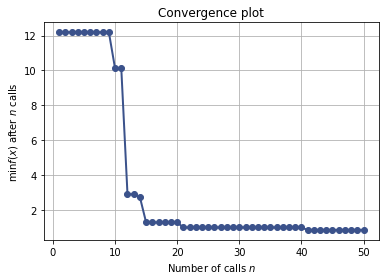

In [10]:
best_mean_squared_error = 9999999999999999
default_parameters =[0.6, 200, 5]
#dropout, filter_num, num_dense_layers
print_and_plot(default_parameters)

# Initial conditions try 3

In [11]:
#load and split data
x_train_pre, x_test_pre, y_train, y_test = train_test_split(X, Y, test_size=0.15)
scaler = StandardScaler().fit(x_train_pre) 
x_train = scaler.transform(x_train_pre) 
scaler = StandardScaler().fit(x_test_pre) 
x_test = scaler.transform(x_test_pre) 

dropout: 7.0e-01
filter_num: 150
num_dense_layers: 9

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 1s 304us/sample - loss: 55.8703 - val_loss: 59.5458
Epoch 2/100
2529/2529 [==============================] - 0s 52us/sample - loss: 51.2360 - val_loss: 59.4567
Epoch 3/100
2529/2529 [==============================] - 0s 42us/sample - loss: 49.5233 - val_loss: 59.2325
Epoch 4/100
2529/2529 [==============================] - 0s 42us/sample - loss: 51.5397 - val_loss: 58.9469
Epoch 5/100
2529/2529 [==============================] - 0s 41us/sample - loss: 45.1877 - val_loss: 58.6382
Epoch 6/100
2529/2529 [==============================] - 0s 42us/sample - loss: 47.6917 - val_loss: 58.4266
Epoch 7/100
2529/2529 [==============================] - 0s 42us/sample - loss: 46.6270 - val_loss: 58.2098
Epoch 8/100
2529/2529 [==============================] - 0s 42us/sample - loss: 45.0342 - val_loss: 58.0100
Epoch 9/100
2529/2529 [===========

2529/2529 [==============================] - 0s 40us/sample - loss: 26.8416 - val_loss: 48.1709
Epoch 76/100
2529/2529 [==============================] - 0s 40us/sample - loss: 25.6921 - val_loss: 48.3167
Epoch 77/100
2529/2529 [==============================] - 0s 40us/sample - loss: 26.0936 - val_loss: 47.9355
Epoch 78/100
2529/2529 [==============================] - 0s 41us/sample - loss: 25.5151 - val_loss: 48.0427
Epoch 79/100
2529/2529 [==============================] - 0s 39us/sample - loss: 25.6543 - val_loss: 48.6218
Epoch 80/100
2529/2529 [==============================] - 0s 40us/sample - loss: 27.5396 - val_loss: 48.6927
Epoch 81/100
2529/2529 [==============================] - 0s 41us/sample - loss: 26.1767 - val_loss: 48.6250
Epoch 82/100
2529/2529 [==============================] - 0s 41us/sample - loss: 24.3847 - val_loss: 48.0583
Epoch 83/100
2529/2529 [==============================] - 0s 41us/sample - loss: 24.5951 - val_loss: 47.7466
Epoch 84/100
2529/2529 [========

2529/2529 [==============================] - 0s 117us/sample - loss: 29.9513 - val_loss: 48.0650
Epoch 49/100
2529/2529 [==============================] - 0s 121us/sample - loss: 22.1092 - val_loss: 36.9585
Epoch 50/100
2529/2529 [==============================] - 0s 113us/sample - loss: 27.9448 - val_loss: 47.4420
Epoch 51/100
2529/2529 [==============================] - 0s 116us/sample - loss: 21.2376 - val_loss: 40.0274
Epoch 52/100
2529/2529 [==============================] - 0s 121us/sample - loss: 19.5716 - val_loss: 44.7359
Epoch 53/100
2529/2529 [==============================] - 0s 126us/sample - loss: 20.0511 - val_loss: 37.5284
Epoch 54/100
2529/2529 [==============================] - 0s 130us/sample - loss: 31.2294 - val_loss: 48.7496
Epoch 55/100
2529/2529 [==============================] - 0s 128us/sample - loss: 27.9038 - val_loss: 37.5868
Epoch 56/100
2529/2529 [==============================] - 0s 125us/sample - loss: 27.4375 - val_loss: 50.0311
Epoch 57/100
2529/2529 

2529/2529 [==============================] - 0s 56us/sample - loss: 24.7381 - val_loss: 43.6921
Epoch 22/100
2529/2529 [==============================] - 0s 55us/sample - loss: 24.4824 - val_loss: 43.2338
Epoch 23/100
2529/2529 [==============================] - 0s 55us/sample - loss: 30.0906 - val_loss: 41.9432
Epoch 24/100
2529/2529 [==============================] - 0s 54us/sample - loss: 21.0857 - val_loss: 41.7039
Epoch 25/100
2529/2529 [==============================] - 0s 54us/sample - loss: 18.4934 - val_loss: 38.3864
Epoch 26/100
2529/2529 [==============================] - 0s 55us/sample - loss: 17.9287 - val_loss: 45.0042
Epoch 27/100
2529/2529 [==============================] - 0s 54us/sample - loss: 19.5863 - val_loss: 37.4971
Epoch 28/100
2529/2529 [==============================] - 0s 54us/sample - loss: 23.0387 - val_loss: 44.1845
Epoch 29/100
2529/2529 [==============================] - 0s 55us/sample - loss: 18.0264 - val_loss: 37.5832
Epoch 30/100
2529/2529 [========

2529/2529 [==============================] - 0s 57us/sample - loss: 13.9750 - val_loss: 40.1328
Epoch 97/100
2529/2529 [==============================] - 0s 55us/sample - loss: 14.0639 - val_loss: 43.9497
Epoch 98/100
2529/2529 [==============================] - 0s 55us/sample - loss: 23.6201 - val_loss: 44.9322
Epoch 99/100
2529/2529 [==============================] - 0s 54us/sample - loss: 18.2659 - val_loss: 41.3241
Epoch 100/100
2529/2529 [==============================] - 0s 54us/sample - loss: 33.9665 - val_loss: 45.9970

Mean squared error: 3.4e+01

dropout: 2.1e-01
filter_num: 255
num_dense_layers: 13

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 1s 406us/sample - loss: 61.2223 - val_loss: 41.3046
Epoch 2/100
2529/2529 [==============================] - 0s 92us/sample - loss: 52.7933 - val_loss: 57.4697
Epoch 3/100
2529/2529 [==============================] - 0s 90us/sample - loss: 59.9960 - val_loss: 53.0089
Epoch 4/10

2529/2529 [==============================] - 0s 92us/sample - loss: 7.4123 - val_loss: 36.5115
Epoch 71/100
2529/2529 [==============================] - 0s 90us/sample - loss: 7.7005 - val_loss: 36.3891
Epoch 72/100
2529/2529 [==============================] - 0s 87us/sample - loss: 7.2526 - val_loss: 39.3616
Epoch 73/100
2529/2529 [==============================] - 0s 86us/sample - loss: 8.2771 - val_loss: 37.9145
Epoch 74/100
2529/2529 [==============================] - 0s 92us/sample - loss: 9.9497 - val_loss: 40.0127
Epoch 75/100
2529/2529 [==============================] - 0s 93us/sample - loss: 10.4981 - val_loss: 41.0662
Epoch 76/100
2529/2529 [==============================] - 0s 88us/sample - loss: 17.7109 - val_loss: 36.0283
Epoch 77/100
2529/2529 [==============================] - 0s 90us/sample - loss: 11.2712 - val_loss: 37.4548
Epoch 78/100
2529/2529 [==============================] - 0s 90us/sample - loss: 15.6281 - val_loss: 36.3680
Epoch 79/100
2529/2529 [=============

2529/2529 [==============================] - 0s 64us/sample - loss: 16.7995 - val_loss: 44.3404
Epoch 45/100
2529/2529 [==============================] - 0s 64us/sample - loss: 19.0673 - val_loss: 42.0353
Epoch 46/100
2529/2529 [==============================] - 0s 66us/sample - loss: 15.5855 - val_loss: 39.9271
Epoch 47/100
2529/2529 [==============================] - 0s 67us/sample - loss: 14.9684 - val_loss: 44.1881
Epoch 48/100
2529/2529 [==============================] - 0s 66us/sample - loss: 14.8100 - val_loss: 37.9448
Epoch 49/100
2529/2529 [==============================] - 0s 65us/sample - loss: 14.3841 - val_loss: 42.3547
Epoch 50/100
2529/2529 [==============================] - 0s 67us/sample - loss: 15.6031 - val_loss: 44.2090
Epoch 51/100
2529/2529 [==============================] - 0s 68us/sample - loss: 16.6272 - val_loss: 37.6034
Epoch 52/100
2529/2529 [==============================] - 0s 65us/sample - loss: 21.2742 - val_loss: 47.2163
Epoch 53/100
2529/2529 [========

2529/2529 [==============================] - 0s 38us/sample - loss: 47.9721 - val_loss: 55.1088
Epoch 19/100
2529/2529 [==============================] - 0s 37us/sample - loss: 48.0518 - val_loss: 54.7556
Epoch 20/100
2529/2529 [==============================] - 0s 36us/sample - loss: 54.1597 - val_loss: 55.4571
Epoch 21/100
2529/2529 [==============================] - 0s 37us/sample - loss: 50.8178 - val_loss: 55.2993
Epoch 22/100
2529/2529 [==============================] - 0s 36us/sample - loss: 49.2164 - val_loss: 54.5217
Epoch 23/100
2529/2529 [==============================] - 0s 35us/sample - loss: 47.1876 - val_loss: 53.4576
Epoch 24/100
2529/2529 [==============================] - 0s 37us/sample - loss: 45.0366 - val_loss: 52.5223
Epoch 25/100
2529/2529 [==============================] - 0s 36us/sample - loss: 46.0502 - val_loss: 52.7433
Epoch 26/100
2529/2529 [==============================] - 0s 37us/sample - loss: 57.8066 - val_loss: 53.4031
Epoch 27/100
2529/2529 [========

2529/2529 [==============================] - 0s 36us/sample - loss: 37.3086 - val_loss: 46.5543
Epoch 94/100
2529/2529 [==============================] - 0s 37us/sample - loss: 40.4438 - val_loss: 46.0497
Epoch 95/100
2529/2529 [==============================] - 0s 37us/sample - loss: 59.6277 - val_loss: 47.0943
Epoch 96/100
2529/2529 [==============================] - 0s 37us/sample - loss: 40.3893 - val_loss: 47.4092
Epoch 97/100
2529/2529 [==============================] - 0s 38us/sample - loss: 35.0926 - val_loss: 47.2653
Epoch 98/100
2529/2529 [==============================] - 0s 36us/sample - loss: 35.7955 - val_loss: 46.6872
Epoch 99/100
2529/2529 [==============================] - 0s 37us/sample - loss: 32.0946 - val_loss: 46.0289
Epoch 100/100
2529/2529 [==============================] - 0s 36us/sample - loss: 38.3184 - val_loss: 45.7851

Mean squared error: 3.8e+01

dropout: 3.4e-01
filter_num: 264
num_dense_layers: 15

Train on 2529 samples, validate on 281 samples
Epoch 1/

2529/2529 [==============================] - 0s 105us/sample - loss: 26.9651 - val_loss: 42.6174
Epoch 67/100
2529/2529 [==============================] - 0s 99us/sample - loss: 24.3960 - val_loss: 38.0314
Epoch 68/100
2529/2529 [==============================] - 0s 103us/sample - loss: 22.9047 - val_loss: 40.8480
Epoch 69/100
2529/2529 [==============================] - 0s 100us/sample - loss: 21.9079 - val_loss: 38.4039
Epoch 70/100
2529/2529 [==============================] - 0s 100us/sample - loss: 32.3807 - val_loss: 43.4530
Epoch 71/100
2529/2529 [==============================] - 0s 99us/sample - loss: 22.9300 - val_loss: 37.7167
Epoch 72/100
2529/2529 [==============================] - 0s 99us/sample - loss: 25.5161 - val_loss: 44.6827
Epoch 73/100
2529/2529 [==============================] - 0s 99us/sample - loss: 20.0069 - val_loss: 38.4236
Epoch 74/100
2529/2529 [==============================] - 0s 96us/sample - loss: 17.4196 - val_loss: 41.8076
Epoch 75/100
2529/2529 [====

Epoch 40/100
2529/2529 [==============================] - 0s 29us/sample - loss: 15.8307 - val_loss: 44.5264
Epoch 41/100
2529/2529 [==============================] - 0s 28us/sample - loss: 17.0928 - val_loss: 44.3863
Epoch 42/100
2529/2529 [==============================] - 0s 28us/sample - loss: 19.5103 - val_loss: 45.4412
Epoch 43/100
2529/2529 [==============================] - 0s 26us/sample - loss: 15.6381 - val_loss: 43.6905
Epoch 44/100
2529/2529 [==============================] - 0s 30us/sample - loss: 37.1653 - val_loss: 46.5858
Epoch 45/100
2529/2529 [==============================] - 0s 28us/sample - loss: 21.6723 - val_loss: 45.7502
Epoch 46/100
2529/2529 [==============================] - 0s 27us/sample - loss: 21.6586 - val_loss: 43.7434
Epoch 47/100
2529/2529 [==============================] - 0s 26us/sample - loss: 21.3164 - val_loss: 44.4216
Epoch 48/100
2529/2529 [==============================] - 0s 31us/sample - loss: 18.7432 - val_loss: 44.5916
Epoch 49/100
2529/2

2529/2529 [==============================] - 0s 31us/sample - loss: 15.4843 - val_loss: 55.8918
Epoch 15/100
2529/2529 [==============================] - 0s 31us/sample - loss: 13.8354 - val_loss: 42.1888
Epoch 16/100
2529/2529 [==============================] - 0s 31us/sample - loss: 11.7112 - val_loss: 48.7732
Epoch 17/100
2529/2529 [==============================] - 0s 30us/sample - loss: 11.4479 - val_loss: 39.0543
Epoch 18/100
2529/2529 [==============================] - 0s 30us/sample - loss: 10.4335 - val_loss: 43.1962
Epoch 19/100
2529/2529 [==============================] - 0s 29us/sample - loss: 10.2476 - val_loss: 41.5032
Epoch 20/100
2529/2529 [==============================] - 0s 30us/sample - loss: 8.6230 - val_loss: 45.6500
Epoch 21/100
2529/2529 [==============================] - 0s 30us/sample - loss: 8.0028 - val_loss: 43.5135
Epoch 22/100
2529/2529 [==============================] - 0s 30us/sample - loss: 7.4639 - val_loss: 43.9987
Epoch 23/100
2529/2529 [===========

Epoch 90/100
2529/2529 [==============================] - 0s 31us/sample - loss: 3.0553 - val_loss: 52.2568
Epoch 91/100
2529/2529 [==============================] - 0s 30us/sample - loss: 2.9096 - val_loss: 49.6197
Epoch 92/100
2529/2529 [==============================] - 0s 30us/sample - loss: 3.0192 - val_loss: 50.2364
Epoch 93/100
2529/2529 [==============================] - 0s 30us/sample - loss: 3.1044 - val_loss: 49.7492
Epoch 94/100
2529/2529 [==============================] - 0s 30us/sample - loss: 2.5844 - val_loss: 47.1670
Epoch 95/100
2529/2529 [==============================] - 0s 30us/sample - loss: 4.0387 - val_loss: 48.5981
Epoch 96/100
2529/2529 [==============================] - 0s 30us/sample - loss: 2.8322 - val_loss: 46.0586
Epoch 97/100
2529/2529 [==============================] - 0s 30us/sample - loss: 2.8626 - val_loss: 49.9179
Epoch 98/100
2529/2529 [==============================] - 0s 31us/sample - loss: 2.6320 - val_loss: 49.1014
Epoch 99/100
2529/2529 [====

2529/2529 [==============================] - 0s 69us/sample - loss: 17.9645 - val_loss: 46.7898
Epoch 65/100
2529/2529 [==============================] - 0s 69us/sample - loss: 14.0737 - val_loss: 47.4461
Epoch 66/100
2529/2529 [==============================] - 0s 70us/sample - loss: 19.4264 - val_loss: 49.0493
Epoch 67/100
2529/2529 [==============================] - 0s 68us/sample - loss: 21.1676 - val_loss: 48.0229
Epoch 68/100
2529/2529 [==============================] - 0s 70us/sample - loss: 17.0309 - val_loss: 44.9783
Epoch 69/100
2529/2529 [==============================] - 0s 69us/sample - loss: 41.0478 - val_loss: 49.9875
Epoch 70/100
2529/2529 [==============================] - 0s 68us/sample - loss: 26.4050 - val_loss: 49.8099
Epoch 71/100
2529/2529 [==============================] - 0s 69us/sample - loss: 20.5461 - val_loss: 44.6165
Epoch 72/100
2529/2529 [==============================] - 0s 69us/sample - loss: 18.9831 - val_loss: 49.2875
Epoch 73/100
2529/2529 [========

2529/2529 [==============================] - 0s 106us/sample - loss: 24.9423 - val_loss: 43.6839
Epoch 39/100
2529/2529 [==============================] - 0s 107us/sample - loss: 25.2512 - val_loss: 45.3547
Epoch 40/100
2529/2529 [==============================] - 0s 108us/sample - loss: 22.0375 - val_loss: 42.3840
Epoch 41/100
2529/2529 [==============================] - 0s 94us/sample - loss: 20.1397 - val_loss: 52.0520
Epoch 42/100
2529/2529 [==============================] - 0s 102us/sample - loss: 17.8156 - val_loss: 42.3232
Epoch 43/100
2529/2529 [==============================] - 0s 98us/sample - loss: 14.2061 - val_loss: 42.3983
Epoch 44/100
2529/2529 [==============================] - 0s 96us/sample - loss: 15.9023 - val_loss: 43.6339
Epoch 45/100
2529/2529 [==============================] - 0s 93us/sample - loss: 12.7836 - val_loss: 39.9416
Epoch 46/100
2529/2529 [==============================] - 0s 97us/sample - loss: 12.3323 - val_loss: 40.0391
Epoch 47/100
2529/2529 [====

Epoch 12/100
2529/2529 [==============================] - 0s 40us/sample - loss: 12.3366 - val_loss: 37.5325
Epoch 13/100
2529/2529 [==============================] - 0s 41us/sample - loss: 11.7013 - val_loss: 38.7821
Epoch 14/100
2529/2529 [==============================] - 0s 41us/sample - loss: 10.6045 - val_loss: 41.8078
Epoch 15/100
2529/2529 [==============================] - 0s 41us/sample - loss: 10.9770 - val_loss: 42.5147
Epoch 16/100
2529/2529 [==============================] - 0s 41us/sample - loss: 9.7765 - val_loss: 40.5143
Epoch 17/100
2529/2529 [==============================] - 0s 40us/sample - loss: 8.7997 - val_loss: 41.3719
Epoch 18/100
2529/2529 [==============================] - 0s 41us/sample - loss: 8.6856 - val_loss: 38.7160
Epoch 19/100
2529/2529 [==============================] - 0s 42us/sample - loss: 8.2338 - val_loss: 37.6736
Epoch 20/100
2529/2529 [==============================] - 0s 41us/sample - loss: 7.5339 - val_loss: 38.6912
Epoch 21/100
2529/2529 [

Epoch 88/100
2529/2529 [==============================] - 0s 41us/sample - loss: 4.4692 - val_loss: 41.9023
Epoch 89/100
2529/2529 [==============================] - 0s 40us/sample - loss: 3.1924 - val_loss: 41.5247
Epoch 90/100
2529/2529 [==============================] - 0s 42us/sample - loss: 3.9349 - val_loss: 44.5203
Epoch 91/100
2529/2529 [==============================] - 0s 40us/sample - loss: 3.0414 - val_loss: 43.8162
Epoch 92/100
2529/2529 [==============================] - 0s 40us/sample - loss: 4.0594 - val_loss: 43.4373
Epoch 93/100
2529/2529 [==============================] - 0s 41us/sample - loss: 4.4344 - val_loss: 45.1501
Epoch 94/100
2529/2529 [==============================] - 0s 41us/sample - loss: 3.9460 - val_loss: 41.9854
Epoch 95/100
2529/2529 [==============================] - 0s 41us/sample - loss: 3.6575 - val_loss: 43.1658
Epoch 96/100
2529/2529 [==============================] - 0s 40us/sample - loss: 2.9744 - val_loss: 42.5626
Epoch 97/100
2529/2529 [====

2529/2529 [==============================] - 0s 10us/sample - loss: 19.9451 - val_loss: 89.0086
Epoch 63/100
2529/2529 [==============================] - 0s 11us/sample - loss: 19.7139 - val_loss: 94.3721
Epoch 64/100
2529/2529 [==============================] - 0s 10us/sample - loss: 19.3947 - val_loss: 99.8219
Epoch 65/100
2529/2529 [==============================] - 0s 10us/sample - loss: 18.3609 - val_loss: 104.8641
Epoch 66/100
2529/2529 [==============================] - 0s 11us/sample - loss: 19.2538 - val_loss: 110.3402
Epoch 67/100
2529/2529 [==============================] - 0s 10us/sample - loss: 15.1833 - val_loss: 117.0235
Epoch 68/100
2529/2529 [==============================] - 0s 11us/sample - loss: 14.7732 - val_loss: 125.1238
Epoch 69/100
2529/2529 [==============================] - 0s 10us/sample - loss: 15.9477 - val_loss: 132.5256
Epoch 70/100
2529/2529 [==============================] - 0s 10us/sample - loss: 15.7982 - val_loss: 140.3761
Epoch 71/100
2529/2529 [==

Epoch 36/100
2529/2529 [==============================] - 0s 54us/sample - loss: 12.4468 - val_loss: 48.8405
Epoch 37/100
2529/2529 [==============================] - 0s 53us/sample - loss: 9.2291 - val_loss: 43.0970
Epoch 38/100
2529/2529 [==============================] - 0s 52us/sample - loss: 10.6415 - val_loss: 49.4247
Epoch 39/100
2529/2529 [==============================] - 0s 53us/sample - loss: 8.6952 - val_loss: 46.7960
Epoch 40/100
2529/2529 [==============================] - 0s 58us/sample - loss: 6.6874 - val_loss: 48.8078
Epoch 41/100
2529/2529 [==============================] - 0s 53us/sample - loss: 6.1157 - val_loss: 47.9196
Epoch 42/100
2529/2529 [==============================] - 0s 54us/sample - loss: 6.7593 - val_loss: 43.9684
Epoch 43/100
2529/2529 [==============================] - 0s 54us/sample - loss: 6.0210 - val_loss: 48.9777
Epoch 44/100
2529/2529 [==============================] - 0s 53us/sample - loss: 7.8444 - val_loss: 40.1773
Epoch 45/100
2529/2529 [==

2529/2529 [==============================] - 0s 26us/sample - loss: 23.2319 - val_loss: 38.7384
Epoch 11/100
2529/2529 [==============================] - 0s 29us/sample - loss: 20.0405 - val_loss: 41.0012
Epoch 12/100
2529/2529 [==============================] - 0s 26us/sample - loss: 18.7297 - val_loss: 42.4002
Epoch 13/100
2529/2529 [==============================] - 0s 25us/sample - loss: 16.4047 - val_loss: 44.1972
Epoch 14/100
2529/2529 [==============================] - 0s 25us/sample - loss: 14.1488 - val_loss: 44.9229
Epoch 15/100
2529/2529 [==============================] - 0s 26us/sample - loss: 11.8736 - val_loss: 49.4314
Epoch 16/100
2529/2529 [==============================] - 0s 25us/sample - loss: 11.0956 - val_loss: 48.4659
Epoch 17/100
2529/2529 [==============================] - 0s 26us/sample - loss: 9.5770 - val_loss: 54.7706
Epoch 18/100
2529/2529 [==============================] - 0s 26us/sample - loss: 9.0602 - val_loss: 48.9042
Epoch 19/100
2529/2529 [==========

Epoch 86/100
2529/2529 [==============================] - 0s 27us/sample - loss: 2.0982 - val_loss: 55.1754
Epoch 87/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.0500 - val_loss: 54.8188
Epoch 88/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.1725 - val_loss: 57.9476
Epoch 89/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.9201 - val_loss: 57.1207
Epoch 90/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.1869 - val_loss: 58.6029
Epoch 91/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.6128 - val_loss: 53.4078
Epoch 92/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.4095 - val_loss: 59.4075
Epoch 93/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.5569 - val_loss: 57.2992
Epoch 94/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.0770 - val_loss: 63.4885
Epoch 95/100
2529/2529 [====

2529/2529 [==============================] - 0s 28us/sample - loss: 1.6887 - val_loss: 44.9222
Epoch 61/100
2529/2529 [==============================] - 0s 29us/sample - loss: 1.4047 - val_loss: 43.3105
Epoch 62/100
2529/2529 [==============================] - 0s 30us/sample - loss: 1.3392 - val_loss: 47.1912
Epoch 63/100
2529/2529 [==============================] - 0s 28us/sample - loss: 1.9770 - val_loss: 44.5653
Epoch 64/100
2529/2529 [==============================] - 0s 28us/sample - loss: 1.9877 - val_loss: 51.0620
Epoch 65/100
2529/2529 [==============================] - 0s 27us/sample - loss: 2.0989 - val_loss: 44.0415
Epoch 66/100
2529/2529 [==============================] - 0s 28us/sample - loss: 1.7904 - val_loss: 49.2440
Epoch 67/100
2529/2529 [==============================] - 0s 27us/sample - loss: 2.1058 - val_loss: 44.1345
Epoch 68/100
2529/2529 [==============================] - 0s 28us/sample - loss: 1.5842 - val_loss: 46.4684
Epoch 69/100
2529/2529 [=================

C:\Users\Kat\anaconda3\envs\tensor\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


dropout: 2.0e-01
filter_num: 300
num_dense_layers: 1

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 0s 114us/sample - loss: 60.3249 - val_loss: 41.3156
Epoch 2/100
2529/2529 [==============================] - 0s 26us/sample - loss: 47.0264 - val_loss: 37.6217
Epoch 3/100
2529/2529 [==============================] - 0s 26us/sample - loss: 41.8376 - val_loss: 37.3495
Epoch 4/100
2529/2529 [==============================] - 0s 26us/sample - loss: 38.7461 - val_loss: 34.9162
Epoch 5/100
2529/2529 [==============================] - 0s 26us/sample - loss: 34.9170 - val_loss: 34.6861
Epoch 6/100
2529/2529 [==============================] - 0s 25us/sample - loss: 30.9392 - val_loss: 34.4872
Epoch 7/100
2529/2529 [==============================] - 0s 26us/sample - loss: 27.8954 - val_loss: 35.4496
Epoch 8/100
2529/2529 [==============================] - 0s 26us/sample - loss: 25.4179 - val_loss: 37.9430
Epoch 9/100
2529/2529 [===========

Epoch 76/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.3034 - val_loss: 52.2755
Epoch 77/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.8360 - val_loss: 51.8557
Epoch 78/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.6018 - val_loss: 53.9121
Epoch 79/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.4778 - val_loss: 52.6444
Epoch 80/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.6232 - val_loss: 54.9559
Epoch 81/100
2529/2529 [==============================] - 0s 30us/sample - loss: 1.3888 - val_loss: 50.8773
Epoch 82/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.2775 - val_loss: 53.8777
Epoch 83/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.5152 - val_loss: 48.4032
Epoch 84/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.0716 - val_loss: 51.7293
Epoch 85/100
2529/2529 [====

2529/2529 [==============================] - 0s 27us/sample - loss: 8.1992 - val_loss: 91.0150
Epoch 51/100
2529/2529 [==============================] - 0s 27us/sample - loss: 7.7733 - val_loss: 92.3576
Epoch 52/100
2529/2529 [==============================] - 0s 28us/sample - loss: 8.3617 - val_loss: 95.6334
Epoch 53/100
2529/2529 [==============================] - 0s 27us/sample - loss: 7.5049 - val_loss: 97.8523
Epoch 54/100
2529/2529 [==============================] - 0s 28us/sample - loss: 7.1616 - val_loss: 100.1827
Epoch 55/100
2529/2529 [==============================] - 0s 27us/sample - loss: 7.3735 - val_loss: 84.2201
Epoch 56/100
2529/2529 [==============================] - 0s 27us/sample - loss: 9.2023 - val_loss: 96.6374
Epoch 57/100
2529/2529 [==============================] - 0s 29us/sample - loss: 8.6935 - val_loss: 93.8801
Epoch 58/100
2529/2529 [==============================] - 0s 27us/sample - loss: 7.5681 - val_loss: 88.1583
Epoch 59/100
2529/2529 [================

2529/2529 [==============================] - 0s 9us/sample - loss: 40.8867 - val_loss: 41.7225
Epoch 25/100
2529/2529 [==============================] - 0s 10us/sample - loss: 46.9278 - val_loss: 41.4340
Epoch 26/100
2529/2529 [==============================] - 0s 10us/sample - loss: 47.0430 - val_loss: 42.0837
Epoch 27/100
2529/2529 [==============================] - 0s 10us/sample - loss: 48.2284 - val_loss: 43.1775
Epoch 28/100
2529/2529 [==============================] - 0s 10us/sample - loss: 41.6356 - val_loss: 43.5839
Epoch 29/100
2529/2529 [==============================] - 0s 10us/sample - loss: 44.1442 - val_loss: 43.8518
Epoch 30/100
2529/2529 [==============================] - 0s 10us/sample - loss: 47.6437 - val_loss: 43.9222
Epoch 31/100
2529/2529 [==============================] - 0s 10us/sample - loss: 50.8838 - val_loss: 43.9655
Epoch 32/100
2529/2529 [==============================] - 0s 10us/sample - loss: 47.9234 - val_loss: 43.9091
Epoch 33/100
2529/2529 [=========

2529/2529 [==============================] - 0s 10us/sample - loss: 37.4811 - val_loss: 44.6400
Epoch 100/100
2529/2529 [==============================] - 0s 10us/sample - loss: 31.6748 - val_loss: 44.6120

Mean squared error: 3.2e+01

dropout: 2.0e-01
filter_num: 183
num_dense_layers: 1

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 0s 102us/sample - loss: 62.6116 - val_loss: 49.4940
Epoch 2/100
2529/2529 [==============================] - 0s 21us/sample - loss: 47.5345 - val_loss: 41.4321
Epoch 3/100
2529/2529 [==============================] - 0s 18us/sample - loss: 45.7308 - val_loss: 37.1396
Epoch 4/100
2529/2529 [==============================] - 0s 18us/sample - loss: 40.8606 - val_loss: 37.8342
Epoch 5/100
2529/2529 [==============================] - 0s 19us/sample - loss: 37.5131 - val_loss: 34.1713
Epoch 6/100
2529/2529 [==============================] - 0s 19us/sample - loss: 34.8485 - val_loss: 34.6078
Epoch 7/100
25

2529/2529 [==============================] - 0s 18us/sample - loss: 2.9550 - val_loss: 62.1689
Epoch 74/100
2529/2529 [==============================] - 0s 19us/sample - loss: 1.9261 - val_loss: 64.0024
Epoch 75/100
2529/2529 [==============================] - 0s 18us/sample - loss: 2.2154 - val_loss: 62.6062
Epoch 76/100
2529/2529 [==============================] - 0s 19us/sample - loss: 1.8917 - val_loss: 63.4509
Epoch 77/100
2529/2529 [==============================] - 0s 18us/sample - loss: 1.9160 - val_loss: 63.3114
Epoch 78/100
2529/2529 [==============================] - 0s 18us/sample - loss: 1.9969 - val_loss: 65.1323
Epoch 79/100
2529/2529 [==============================] - 0s 18us/sample - loss: 1.7732 - val_loss: 66.2011
Epoch 80/100
2529/2529 [==============================] - 0s 19us/sample - loss: 1.8756 - val_loss: 62.4657
Epoch 81/100
2529/2529 [==============================] - 0s 18us/sample - loss: 1.8214 - val_loss: 65.3417
Epoch 82/100
2529/2529 [=================

2529/2529 [==============================] - 0s 17us/sample - loss: 13.9108 - val_loss: 71.3264
Epoch 48/100
2529/2529 [==============================] - 0s 16us/sample - loss: 13.8057 - val_loss: 100.5417
Epoch 49/100
2529/2529 [==============================] - 0s 16us/sample - loss: 14.3845 - val_loss: 72.6063
Epoch 50/100
2529/2529 [==============================] - 0s 16us/sample - loss: 12.5321 - val_loss: 89.8954
Epoch 51/100
2529/2529 [==============================] - 0s 16us/sample - loss: 11.4376 - val_loss: 111.7107
Epoch 52/100
2529/2529 [==============================] - 0s 16us/sample - loss: 9.3065 - val_loss: 95.1809
Epoch 53/100
2529/2529 [==============================] - 0s 16us/sample - loss: 9.3412 - val_loss: 106.4992
Epoch 54/100
2529/2529 [==============================] - 0s 16us/sample - loss: 8.3666 - val_loss: 107.9722
Epoch 55/100
2529/2529 [==============================] - 0s 16us/sample - loss: 9.1229 - val_loss: 108.0638
Epoch 56/100
2529/2529 [=======

2529/2529 [==============================] - 0s 68us/sample - loss: 7.5272 - val_loss: 35.9220
Epoch 22/100
2529/2529 [==============================] - 0s 68us/sample - loss: 8.1754 - val_loss: 35.3230
Epoch 23/100
2529/2529 [==============================] - 0s 70us/sample - loss: 7.1649 - val_loss: 36.4447
Epoch 24/100
2529/2529 [==============================] - 0s 68us/sample - loss: 7.3083 - val_loss: 37.4717
Epoch 25/100
2529/2529 [==============================] - 0s 69us/sample - loss: 7.2155 - val_loss: 37.5682
Epoch 26/100
2529/2529 [==============================] - 0s 69us/sample - loss: 7.0054 - val_loss: 37.2314
Epoch 27/100
2529/2529 [==============================] - 0s 68us/sample - loss: 7.2212 - val_loss: 36.9719
Epoch 28/100
2529/2529 [==============================] - 0s 68us/sample - loss: 8.5172 - val_loss: 39.0135
Epoch 29/100
2529/2529 [==============================] - 0s 68us/sample - loss: 10.2889 - val_loss: 36.5157
Epoch 30/100
2529/2529 [================

Epoch 97/100
2529/2529 [==============================] - 0s 68us/sample - loss: 14.9157 - val_loss: 42.5889
Epoch 98/100
2529/2529 [==============================] - 0s 66us/sample - loss: 13.6508 - val_loss: 60.5656
Epoch 99/100
2529/2529 [==============================] - 0s 73us/sample - loss: 16.5767 - val_loss: 41.8715
Epoch 100/100
2529/2529 [==============================] - 0s 68us/sample - loss: 16.7075 - val_loss: 50.4413

Mean squared error: 1.7e+01

dropout: 2.9e-01
filter_num: 157
num_dense_layers: 4

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 0s 156us/sample - loss: 64.2649 - val_loss: 54.3052
Epoch 2/100
2529/2529 [==============================] - 0s 32us/sample - loss: 51.3263 - val_loss: 39.3460
Epoch 3/100
2529/2529 [==============================] - 0s 26us/sample - loss: 44.9145 - val_loss: 41.2492
Epoch 4/100
2529/2529 [==============================] - 0s 27us/sample - loss: 41.3028 - val_loss: 36.2314

2529/2529 [==============================] - 0s 27us/sample - loss: 4.2657 - val_loss: 47.4736
Epoch 72/100
2529/2529 [==============================] - 0s 26us/sample - loss: 4.8652 - val_loss: 46.6873
Epoch 73/100
2529/2529 [==============================] - 0s 26us/sample - loss: 4.3232 - val_loss: 47.4987
Epoch 74/100
2529/2529 [==============================] - 0s 26us/sample - loss: 4.1486 - val_loss: 45.8866
Epoch 75/100
2529/2529 [==============================] - 0s 26us/sample - loss: 4.8934 - val_loss: 47.0293
Epoch 76/100
2529/2529 [==============================] - 0s 26us/sample - loss: 3.9108 - val_loss: 50.7178
Epoch 77/100
2529/2529 [==============================] - 0s 26us/sample - loss: 4.7077 - val_loss: 46.8999
Epoch 78/100
2529/2529 [==============================] - 0s 26us/sample - loss: 4.9417 - val_loss: 46.3858
Epoch 79/100
2529/2529 [==============================] - 0s 26us/sample - loss: 4.8057 - val_loss: 45.9017
Epoch 80/100
2529/2529 [=================

2529/2529 [==============================] - 0s 48us/sample - loss: 8.6146 - val_loss: 40.8363
Epoch 46/100
2529/2529 [==============================] - 0s 47us/sample - loss: 8.4144 - val_loss: 39.9113
Epoch 47/100
2529/2529 [==============================] - 0s 48us/sample - loss: 8.9766 - val_loss: 40.3479
Epoch 48/100
2529/2529 [==============================] - 0s 48us/sample - loss: 8.1583 - val_loss: 40.3839
Epoch 49/100
2529/2529 [==============================] - 0s 47us/sample - loss: 7.3236 - val_loss: 40.3782
Epoch 50/100
2529/2529 [==============================] - 0s 53us/sample - loss: 8.1047 - val_loss: 41.4573
Epoch 51/100
2529/2529 [==============================] - 0s 47us/sample - loss: 6.3554 - val_loss: 40.7255
Epoch 52/100
2529/2529 [==============================] - 0s 47us/sample - loss: 7.6552 - val_loss: 40.3836
Epoch 53/100
2529/2529 [==============================] - 0s 48us/sample - loss: 6.6902 - val_loss: 40.5380
Epoch 54/100
2529/2529 [=================

2529/2529 [==============================] - 0s 25us/sample - loss: 11.2432 - val_loss: 58.7136
Epoch 20/100
2529/2529 [==============================] - 0s 25us/sample - loss: 9.9931 - val_loss: 48.8933
Epoch 21/100
2529/2529 [==============================] - 0s 26us/sample - loss: 8.1627 - val_loss: 61.9336
Epoch 22/100
2529/2529 [==============================] - 0s 26us/sample - loss: 8.5832 - val_loss: 45.6254
Epoch 23/100
2529/2529 [==============================] - 0s 25us/sample - loss: 8.9373 - val_loss: 55.2330
Epoch 24/100
2529/2529 [==============================] - 0s 25us/sample - loss: 9.1500 - val_loss: 45.4596
Epoch 25/100
2529/2529 [==============================] - 0s 25us/sample - loss: 8.1667 - val_loss: 52.3578
Epoch 26/100
2529/2529 [==============================] - 0s 26us/sample - loss: 7.1985 - val_loss: 49.0824
Epoch 27/100
2529/2529 [==============================] - 0s 25us/sample - loss: 6.2189 - val_loss: 54.2743
Epoch 28/100
2529/2529 [================

Epoch 95/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.5670 - val_loss: 57.3806
Epoch 96/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.2675 - val_loss: 58.8600
Epoch 97/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.2733 - val_loss: 56.7230
Epoch 98/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.5599 - val_loss: 59.2463
Epoch 99/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.4197 - val_loss: 56.8899
Epoch 100/100
2529/2529 [==============================] - 0s 26us/sample - loss: 3.5383 - val_loss: 57.2223

Mean squared error: 3.5

dropout: 2.2e-01
filter_num: 270
num_dense_layers: 1

Train on 2529 samples, validate on 281 samples
Epoch 1/100
2529/2529 [==============================] - 0s 111us/sample - loss: 59.3973 - val_loss: 40.7930
Epoch 2/100
2529/2529 [==============================] - 0s 23us/sample - loss: 45.7031 - val_loss: 37.9403
Epoch 3

2529/2529 [==============================] - 0s 22us/sample - loss: 2.0528 - val_loss: 40.6473
Epoch 70/100
2529/2529 [==============================] - 0s 23us/sample - loss: 1.7597 - val_loss: 40.2903
Epoch 71/100
2529/2529 [==============================] - 0s 23us/sample - loss: 1.5521 - val_loss: 40.2248
Epoch 72/100
2529/2529 [==============================] - 0s 23us/sample - loss: 1.6855 - val_loss: 41.3254
Epoch 73/100
2529/2529 [==============================] - 0s 22us/sample - loss: 3.4089 - val_loss: 43.5797
Epoch 74/100
2529/2529 [==============================] - 0s 22us/sample - loss: 2.9862 - val_loss: 43.9165
Epoch 75/100
2529/2529 [==============================] - 0s 23us/sample - loss: 3.1832 - val_loss: 44.3830
Epoch 76/100
2529/2529 [==============================] - 0s 22us/sample - loss: 1.8399 - val_loss: 43.3774
Epoch 77/100
2529/2529 [==============================] - 0s 24us/sample - loss: 1.9640 - val_loss: 45.7011
Epoch 78/100
2529/2529 [=================

2529/2529 [==============================] - 0s 11us/sample - loss: 25.1556 - val_loss: 42.9924
Epoch 44/100
2529/2529 [==============================] - 0s 11us/sample - loss: 27.3522 - val_loss: 43.1140
Epoch 45/100
2529/2529 [==============================] - 0s 11us/sample - loss: 26.2520 - val_loss: 43.6669
Epoch 46/100
2529/2529 [==============================] - 0s 11us/sample - loss: 22.9084 - val_loss: 44.6419
Epoch 47/100
2529/2529 [==============================] - 0s 11us/sample - loss: 24.9866 - val_loss: 45.9973
Epoch 48/100
2529/2529 [==============================] - 0s 11us/sample - loss: 24.1258 - val_loss: 46.8919
Epoch 49/100
2529/2529 [==============================] - 0s 11us/sample - loss: 25.4986 - val_loss: 50.4064
Epoch 50/100
2529/2529 [==============================] - 0s 11us/sample - loss: 22.9530 - val_loss: 51.6695
Epoch 51/100
2529/2529 [==============================] - 0s 11us/sample - loss: 23.6159 - val_loss: 53.7068
Epoch 52/100
2529/2529 [========

2529/2529 [==============================] - 0s 123us/sample - loss: 75.6231 - val_loss: 59.9998
Epoch 17/100
2529/2529 [==============================] - 0s 122us/sample - loss: 69.0119 - val_loss: 59.9736
Epoch 18/100
2529/2529 [==============================] - 0s 121us/sample - loss: 71.4066 - val_loss: 59.9404
Epoch 19/100
2529/2529 [==============================] - 0s 119us/sample - loss: 65.1598 - val_loss: 59.9025
Epoch 20/100
2529/2529 [==============================] - 0s 123us/sample - loss: 73.7702 - val_loss: 59.8645
Epoch 21/100
2529/2529 [==============================] - 0s 118us/sample - loss: 66.0169 - val_loss: 59.8205
Epoch 22/100
2529/2529 [==============================] - 0s 119us/sample - loss: 70.9952 - val_loss: 59.7767
Epoch 23/100
2529/2529 [==============================] - 0s 124us/sample - loss: 65.2532 - val_loss: 59.7326
Epoch 24/100
2529/2529 [==============================] - 0s 121us/sample - loss: 65.0822 - val_loss: 59.6865
Epoch 25/100
2529/2529 

2529/2529 [==============================] - 0s 123us/sample - loss: 52.1545 - val_loss: 55.3158
Epoch 91/100
2529/2529 [==============================] - 0s 118us/sample - loss: 54.8809 - val_loss: 55.2422
Epoch 92/100
2529/2529 [==============================] - 0s 120us/sample - loss: 54.0248 - val_loss: 55.1778
Epoch 93/100
2529/2529 [==============================] - 0s 117us/sample - loss: 52.4582 - val_loss: 55.1126
Epoch 94/100
2529/2529 [==============================] - 0s 121us/sample - loss: 54.4094 - val_loss: 55.0456
Epoch 95/100
2529/2529 [==============================] - 0s 120us/sample - loss: 56.9719 - val_loss: 54.9727
Epoch 96/100
2529/2529 [==============================] - 0s 118us/sample - loss: 53.7321 - val_loss: 54.8973
Epoch 97/100
2529/2529 [==============================] - 0s 120us/sample - loss: 53.1572 - val_loss: 54.8236
Epoch 98/100
2529/2529 [==============================] - 0s 119us/sample - loss: 50.4759 - val_loss: 54.7386
Epoch 99/100
2529/2529 

2529/2529 [==============================] - 0s 13us/sample - loss: 27.4464 - val_loss: 44.8333
Epoch 65/100
2529/2529 [==============================] - 0s 13us/sample - loss: 25.1516 - val_loss: 45.4906
Epoch 66/100
2529/2529 [==============================] - 0s 13us/sample - loss: 29.8919 - val_loss: 45.9566
Epoch 67/100
2529/2529 [==============================] - 0s 13us/sample - loss: 25.5501 - val_loss: 45.8042
Epoch 68/100
2529/2529 [==============================] - 0s 13us/sample - loss: 25.8779 - val_loss: 46.4682
Epoch 69/100
2529/2529 [==============================] - 0s 13us/sample - loss: 28.0690 - val_loss: 47.9669
Epoch 70/100
2529/2529 [==============================] - 0s 13us/sample - loss: 27.4249 - val_loss: 49.0047
Epoch 71/100
2529/2529 [==============================] - 0s 13us/sample - loss: 25.9842 - val_loss: 49.6547
Epoch 72/100
2529/2529 [==============================] - 0s 13us/sample - loss: 22.0262 - val_loss: 49.5873
Epoch 73/100
2529/2529 [========

2529/2529 [==============================] - 0s 25us/sample - loss: 6.9455 - val_loss: 53.1601
Epoch 39/100
2529/2529 [==============================] - 0s 26us/sample - loss: 5.9319 - val_loss: 50.3697
Epoch 40/100
2529/2529 [==============================] - 0s 25us/sample - loss: 6.6155 - val_loss: 58.0138
Epoch 41/100
2529/2529 [==============================] - 0s 25us/sample - loss: 5.8762 - val_loss: 48.4123
Epoch 42/100
2529/2529 [==============================] - 0s 25us/sample - loss: 6.0224 - val_loss: 56.8519
Epoch 43/100
2529/2529 [==============================] - 0s 24us/sample - loss: 5.3448 - val_loss: 50.9572
Epoch 44/100
2529/2529 [==============================] - 0s 24us/sample - loss: 5.1494 - val_loss: 55.8208
Epoch 45/100
2529/2529 [==============================] - 0s 25us/sample - loss: 6.4049 - val_loss: 59.4176
Epoch 46/100
2529/2529 [==============================] - 0s 25us/sample - loss: 13.3409 - val_loss: 48.4855
Epoch 47/100
2529/2529 [================

2529/2529 [==============================] - 0s 19us/sample - loss: 23.1770 - val_loss: 39.0009
Epoch 13/100
2529/2529 [==============================] - 0s 20us/sample - loss: 21.2322 - val_loss: 42.1552
Epoch 14/100
2529/2529 [==============================] - 0s 19us/sample - loss: 20.5609 - val_loss: 44.1355
Epoch 15/100
2529/2529 [==============================] - 0s 20us/sample - loss: 18.8802 - val_loss: 45.3892
Epoch 16/100
2529/2529 [==============================] - 0s 19us/sample - loss: 18.0805 - val_loss: 45.2129
Epoch 17/100
2529/2529 [==============================] - 0s 19us/sample - loss: 15.1048 - val_loss: 54.0105
Epoch 18/100
2529/2529 [==============================] - 0s 19us/sample - loss: 13.9233 - val_loss: 46.3368
Epoch 19/100
2529/2529 [==============================] - 0s 19us/sample - loss: 13.3506 - val_loss: 51.6342
Epoch 20/100
2529/2529 [==============================] - 0s 20us/sample - loss: 11.6804 - val_loss: 54.6592
Epoch 21/100
2529/2529 [========

Epoch 88/100
2529/2529 [==============================] - 0s 18us/sample - loss: 2.4780 - val_loss: 63.1234
Epoch 89/100
2529/2529 [==============================] - 0s 17us/sample - loss: 2.3521 - val_loss: 60.7583
Epoch 90/100
2529/2529 [==============================] - 0s 18us/sample - loss: 2.4363 - val_loss: 62.5205
Epoch 91/100
2529/2529 [==============================] - 0s 18us/sample - loss: 2.6580 - val_loss: 64.6820
Epoch 92/100
2529/2529 [==============================] - 0s 18us/sample - loss: 1.9966 - val_loss: 65.5590
Epoch 93/100
2529/2529 [==============================] - 0s 18us/sample - loss: 1.7040 - val_loss: 69.1658
Epoch 94/100
2529/2529 [==============================] - 0s 17us/sample - loss: 1.7538 - val_loss: 71.1487
Epoch 95/100
2529/2529 [==============================] - 0s 18us/sample - loss: 1.5091 - val_loss: 74.5345
Epoch 96/100
2529/2529 [==============================] - 0s 18us/sample - loss: 1.7505 - val_loss: 69.0704
Epoch 97/100
2529/2529 [====

2529/2529 [==============================] - 0s 22us/sample - loss: 1.4616 - val_loss: 43.4603
Epoch 63/100
2529/2529 [==============================] - 0s 22us/sample - loss: 1.7908 - val_loss: 43.7529
Epoch 64/100
2529/2529 [==============================] - 0s 21us/sample - loss: 1.9111 - val_loss: 45.2169
Epoch 65/100
2529/2529 [==============================] - 0s 21us/sample - loss: 1.7393 - val_loss: 44.5394
Epoch 66/100
2529/2529 [==============================] - 0s 21us/sample - loss: 1.4091 - val_loss: 45.5368
Epoch 67/100
2529/2529 [==============================] - 0s 22us/sample - loss: 1.3604 - val_loss: 45.3655
Epoch 68/100
2529/2529 [==============================] - 0s 21us/sample - loss: 1.4063 - val_loss: 46.3105
Epoch 69/100
2529/2529 [==============================] - 0s 21us/sample - loss: 2.0460 - val_loss: 44.5476
Epoch 70/100
2529/2529 [==============================] - 0s 21us/sample - loss: 2.2921 - val_loss: 46.6032
Epoch 71/100
2529/2529 [=================

2529/2529 [==============================] - 0s 18us/sample - loss: 4.8689 - val_loss: 51.4879
Epoch 37/100
2529/2529 [==============================] - 0s 18us/sample - loss: 5.9901 - val_loss: 68.6883
Epoch 38/100
2529/2529 [==============================] - 0s 18us/sample - loss: 4.6057 - val_loss: 54.1654
Epoch 39/100
2529/2529 [==============================] - 0s 18us/sample - loss: 4.3098 - val_loss: 59.4038
Epoch 40/100
2529/2529 [==============================] - 0s 19us/sample - loss: 3.5817 - val_loss: 53.5127
Epoch 41/100
2529/2529 [==============================] - 0s 19us/sample - loss: 3.5798 - val_loss: 57.8862
Epoch 42/100
2529/2529 [==============================] - 0s 17us/sample - loss: 3.5028 - val_loss: 54.2685
Epoch 43/100
2529/2529 [==============================] - 0s 18us/sample - loss: 3.3731 - val_loss: 58.1551
Epoch 44/100
2529/2529 [==============================] - 0s 18us/sample - loss: 3.4407 - val_loss: 55.0353
Epoch 45/100
2529/2529 [=================

Epoch 11/100
2529/2529 [==============================] - 0s 17us/sample - loss: 25.5446 - val_loss: 36.1839
Epoch 12/100
2529/2529 [==============================] - 0s 17us/sample - loss: 25.2922 - val_loss: 37.3472
Epoch 13/100
2529/2529 [==============================] - 0s 17us/sample - loss: 23.5214 - val_loss: 42.1857
Epoch 14/100
2529/2529 [==============================] - 0s 17us/sample - loss: 19.6873 - val_loss: 40.8132
Epoch 15/100
2529/2529 [==============================] - 0s 17us/sample - loss: 21.7323 - val_loss: 43.5842
Epoch 16/100
2529/2529 [==============================] - 0s 17us/sample - loss: 19.7145 - val_loss: 49.8277
Epoch 17/100
2529/2529 [==============================] - 0s 17us/sample - loss: 16.6395 - val_loss: 52.1924
Epoch 18/100
2529/2529 [==============================] - 0s 17us/sample - loss: 15.6950 - val_loss: 59.4948
Epoch 19/100
2529/2529 [==============================] - 0s 17us/sample - loss: 12.6066 - val_loss: 62.4115
Epoch 20/100
2529/2

2529/2529 [==============================] - 0s 17us/sample - loss: 5.9947 - val_loss: 96.5282
Epoch 87/100
2529/2529 [==============================] - 0s 17us/sample - loss: 4.9716 - val_loss: 120.7714
Epoch 88/100
2529/2529 [==============================] - 0s 17us/sample - loss: 5.2122 - val_loss: 128.9143
Epoch 89/100
2529/2529 [==============================] - 0s 17us/sample - loss: 3.4218 - val_loss: 128.2031
Epoch 90/100
2529/2529 [==============================] - 0s 17us/sample - loss: 3.2351 - val_loss: 134.3813
Epoch 91/100
2529/2529 [==============================] - 0s 17us/sample - loss: 3.1335 - val_loss: 122.5634
Epoch 92/100
2529/2529 [==============================] - 0s 18us/sample - loss: 2.6154 - val_loss: 112.5629
Epoch 93/100
2529/2529 [==============================] - 0s 17us/sample - loss: 3.2127 - val_loss: 125.9402
Epoch 94/100
2529/2529 [==============================] - 0s 17us/sample - loss: 3.6250 - val_loss: 126.0214
Epoch 95/100
2529/2529 [=========

2529/2529 [==============================] - 0s 62us/sample - loss: 12.2450 - val_loss: 39.7716
Epoch 61/100
2529/2529 [==============================] - 0s 62us/sample - loss: 11.6652 - val_loss: 40.0974
Epoch 62/100
2529/2529 [==============================] - 0s 62us/sample - loss: 9.6195 - val_loss: 40.0285
Epoch 63/100
2529/2529 [==============================] - 0s 59us/sample - loss: 8.6167 - val_loss: 40.0856
Epoch 64/100
2529/2529 [==============================] - 0s 61us/sample - loss: 9.5779 - val_loss: 40.4963
Epoch 65/100
2529/2529 [==============================] - 0s 62us/sample - loss: 8.3693 - val_loss: 40.9166
Epoch 66/100
2529/2529 [==============================] - 0s 60us/sample - loss: 8.6618 - val_loss: 40.9297
Epoch 67/100
2529/2529 [==============================] - 0s 62us/sample - loss: 7.0249 - val_loss: 40.9173
Epoch 68/100
2529/2529 [==============================] - 0s 62us/sample - loss: 7.1904 - val_loss: 40.9416
Epoch 69/100
2529/2529 [===============

2529/2529 [==============================] - 0s 46us/sample - loss: 26.2820 - val_loss: 54.8800
Epoch 35/100
2529/2529 [==============================] - 0s 46us/sample - loss: 25.8151 - val_loss: 54.8800
Epoch 36/100
2529/2529 [==============================] - 0s 47us/sample - loss: 24.1829 - val_loss: 54.5823
Epoch 37/100
2529/2529 [==============================] - 0s 47us/sample - loss: 25.7484 - val_loss: 54.3544
Epoch 38/100
2529/2529 [==============================] - 0s 46us/sample - loss: 23.1597 - val_loss: 54.3135
Epoch 39/100
2529/2529 [==============================] - 0s 47us/sample - loss: 22.3740 - val_loss: 54.0169
Epoch 40/100
2529/2529 [==============================] - 0s 47us/sample - loss: 21.6318 - val_loss: 53.3075
Epoch 41/100
2529/2529 [==============================] - 0s 47us/sample - loss: 21.4813 - val_loss: 52.7483
Epoch 42/100
2529/2529 [==============================] - 0s 46us/sample - loss: 23.7333 - val_loss: 52.5546
Epoch 43/100
2529/2529 [========

2529/2529 [==============================] - 0s 48us/sample - loss: 24.6090 - val_loss: 39.3856
Epoch 9/100
2529/2529 [==============================] - 0s 46us/sample - loss: 22.8423 - val_loss: 43.2757
Epoch 10/100
2529/2529 [==============================] - 0s 47us/sample - loss: 20.4242 - val_loss: 46.9195
Epoch 11/100
2529/2529 [==============================] - 0s 47us/sample - loss: 16.8550 - val_loss: 45.2759
Epoch 12/100
2529/2529 [==============================] - 0s 47us/sample - loss: 15.3853 - val_loss: 45.1336
Epoch 13/100
2529/2529 [==============================] - 0s 46us/sample - loss: 13.2995 - val_loss: 46.1062
Epoch 14/100
2529/2529 [==============================] - 0s 47us/sample - loss: 12.5896 - val_loss: 48.2483
Epoch 15/100
2529/2529 [==============================] - 0s 47us/sample - loss: 13.5180 - val_loss: 44.2474
Epoch 16/100
2529/2529 [==============================] - 0s 48us/sample - loss: 14.2959 - val_loss: 41.6416
Epoch 17/100
2529/2529 [=========

Epoch 84/100
2529/2529 [==============================] - 0s 48us/sample - loss: 4.9174 - val_loss: 48.4465
Epoch 85/100
2529/2529 [==============================] - 0s 47us/sample - loss: 3.7432 - val_loss: 46.9052
Epoch 86/100
2529/2529 [==============================] - 0s 47us/sample - loss: 5.0765 - val_loss: 53.5594
Epoch 87/100
2529/2529 [==============================] - 0s 42us/sample - loss: 5.6914 - val_loss: 48.4978
Epoch 88/100
2529/2529 [==============================] - 0s 51us/sample - loss: 8.1752 - val_loss: 51.3576
Epoch 89/100
2529/2529 [==============================] - 0s 47us/sample - loss: 4.3821 - val_loss: 51.9819
Epoch 90/100
2529/2529 [==============================] - 0s 47us/sample - loss: 3.8217 - val_loss: 52.6122
Epoch 91/100
2529/2529 [==============================] - 0s 47us/sample - loss: 7.8415 - val_loss: 48.9103
Epoch 92/100
2529/2529 [==============================] - 0s 47us/sample - loss: 6.3439 - val_loss: 47.8055
Epoch 93/100
2529/2529 [====

2529/2529 [==============================] - 0s 20us/sample - loss: 2.9982 - val_loss: 78.9004
Epoch 59/100
2529/2529 [==============================] - 0s 20us/sample - loss: 3.4656 - val_loss: 82.9648
Epoch 60/100
2529/2529 [==============================] - 0s 20us/sample - loss: 2.9495 - val_loss: 80.1964
Epoch 61/100
2529/2529 [==============================] - 0s 20us/sample - loss: 3.3338 - val_loss: 76.6959
Epoch 62/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.7439 - val_loss: 87.0453
Epoch 63/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.6255 - val_loss: 76.9226
Epoch 64/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.6526 - val_loss: 86.9722
Epoch 65/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.6123 - val_loss: 76.1181
Epoch 66/100
2529/2529 [==============================] - 0s 19us/sample - loss: 2.4726 - val_loss: 82.0121
Epoch 67/100
2529/2529 [=================

2529/2529 [==============================] - 0s 25us/sample - loss: 5.0713 - val_loss: 51.4188
Epoch 33/100
2529/2529 [==============================] - 0s 26us/sample - loss: 4.6536 - val_loss: 53.5196
Epoch 34/100
2529/2529 [==============================] - 0s 25us/sample - loss: 3.4648 - val_loss: 53.3679
Epoch 35/100
2529/2529 [==============================] - 0s 25us/sample - loss: 3.6115 - val_loss: 56.9243
Epoch 36/100
2529/2529 [==============================] - 0s 25us/sample - loss: 3.2359 - val_loss: 57.2543
Epoch 37/100
2529/2529 [==============================] - 0s 25us/sample - loss: 3.0902 - val_loss: 58.7259
Epoch 38/100
2529/2529 [==============================] - 0s 25us/sample - loss: 3.1768 - val_loss: 55.5444
Epoch 39/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.9280 - val_loss: 54.6283
Epoch 40/100
2529/2529 [==============================] - 0s 25us/sample - loss: 3.0162 - val_loss: 55.1672
Epoch 41/100
2529/2529 [=================

Epoch 7/100
2529/2529 [==============================] - 0s 23us/sample - loss: 33.9341 - val_loss: 34.6785
Epoch 8/100
2529/2529 [==============================] - 0s 23us/sample - loss: 30.9232 - val_loss: 34.0578
Epoch 9/100
2529/2529 [==============================] - 0s 22us/sample - loss: 27.1124 - val_loss: 35.1339
Epoch 10/100
2529/2529 [==============================] - 0s 23us/sample - loss: 25.7780 - val_loss: 37.5364
Epoch 11/100
2529/2529 [==============================] - 0s 22us/sample - loss: 25.2945 - val_loss: 38.9848
Epoch 12/100
2529/2529 [==============================] - 0s 22us/sample - loss: 22.0630 - val_loss: 40.0012
Epoch 13/100
2529/2529 [==============================] - 0s 23us/sample - loss: 21.1240 - val_loss: 43.2305
Epoch 14/100
2529/2529 [==============================] - 0s 22us/sample - loss: 17.9998 - val_loss: 43.5769
Epoch 15/100
2529/2529 [==============================] - 0s 23us/sample - loss: 17.1099 - val_loss: 44.6345
Epoch 16/100
2529/2529

2529/2529 [==============================] - 0s 23us/sample - loss: 8.6382 - val_loss: 51.0754
Epoch 83/100
2529/2529 [==============================] - 0s 26us/sample - loss: 8.4018 - val_loss: 50.8137
Epoch 84/100
2529/2529 [==============================] - 0s 24us/sample - loss: 6.0960 - val_loss: 60.5820
Epoch 85/100
2529/2529 [==============================] - 0s 25us/sample - loss: 6.1603 - val_loss: 54.8608
Epoch 86/100
2529/2529 [==============================] - 0s 25us/sample - loss: 6.7397 - val_loss: 56.5693
Epoch 87/100
2529/2529 [==============================] - 0s 24us/sample - loss: 5.1580 - val_loss: 58.2820
Epoch 88/100
2529/2529 [==============================] - 0s 25us/sample - loss: 5.2623 - val_loss: 56.6486
Epoch 89/100
2529/2529 [==============================] - 0s 25us/sample - loss: 4.8147 - val_loss: 59.1002
Epoch 90/100
2529/2529 [==============================] - 0s 26us/sample - loss: 6.1385 - val_loss: 57.0675
Epoch 91/100
2529/2529 [=================

2529/2529 [==============================] - 0s 25us/sample - loss: 3.9000 - val_loss: 45.4322
Epoch 57/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.7123 - val_loss: 47.2418
Epoch 58/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.9024 - val_loss: 50.3173
Epoch 59/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.5769 - val_loss: 49.0540
Epoch 60/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.7979 - val_loss: 49.4323
Epoch 61/100
2529/2529 [==============================] - 0s 26us/sample - loss: 2.4580 - val_loss: 49.1179
Epoch 62/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.5899 - val_loss: 53.7877
Epoch 63/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.6460 - val_loss: 52.6836
Epoch 64/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.1972 - val_loss: 54.5426
Epoch 65/100
2529/2529 [=================

2529/2529 [==============================] - 0s 21us/sample - loss: 4.7264 - val_loss: 87.0622
Epoch 31/100
2529/2529 [==============================] - 0s 22us/sample - loss: 4.3825 - val_loss: 84.1759
Epoch 32/100
2529/2529 [==============================] - 0s 22us/sample - loss: 4.5482 - val_loss: 91.7596
Epoch 33/100
2529/2529 [==============================] - 0s 21us/sample - loss: 4.4785 - val_loss: 89.7136
Epoch 34/100
2529/2529 [==============================] - 0s 22us/sample - loss: 4.6070 - val_loss: 88.5032
Epoch 35/100
2529/2529 [==============================] - 0s 22us/sample - loss: 4.4564 - val_loss: 97.7286
Epoch 36/100
2529/2529 [==============================] - 0s 22us/sample - loss: 4.5781 - val_loss: 85.0696
Epoch 37/100
2529/2529 [==============================] - 0s 22us/sample - loss: 5.0474 - val_loss: 92.1182
Epoch 38/100
2529/2529 [==============================] - 0s 21us/sample - loss: 4.2757 - val_loss: 84.6410
Epoch 39/100
2529/2529 [=================

Epoch 5/100
2529/2529 [==============================] - 0s 18us/sample - loss: 38.4637 - val_loss: 33.3098
Epoch 6/100
2529/2529 [==============================] - 0s 18us/sample - loss: 34.7531 - val_loss: 32.9905
Epoch 7/100
2529/2529 [==============================] - 0s 18us/sample - loss: 32.5443 - val_loss: 32.8923
Epoch 8/100
2529/2529 [==============================] - 0s 18us/sample - loss: 30.1516 - val_loss: 33.4547
Epoch 9/100
2529/2529 [==============================] - 0s 18us/sample - loss: 27.7894 - val_loss: 34.6556
Epoch 10/100
2529/2529 [==============================] - 0s 18us/sample - loss: 26.7189 - val_loss: 35.5680
Epoch 11/100
2529/2529 [==============================] - 0s 18us/sample - loss: 23.3665 - val_loss: 37.9474
Epoch 12/100
2529/2529 [==============================] - 0s 18us/sample - loss: 21.7883 - val_loss: 39.8219
Epoch 13/100
2529/2529 [==============================] - 0s 18us/sample - loss: 20.9028 - val_loss: 44.1915
Epoch 14/100
2529/2529 [

2529/2529 [==============================] - 0s 17us/sample - loss: 3.8382 - val_loss: 68.0017
Epoch 81/100
2529/2529 [==============================] - 0s 18us/sample - loss: 3.9362 - val_loss: 65.0120
Epoch 82/100
2529/2529 [==============================] - 0s 18us/sample - loss: 4.4931 - val_loss: 67.3391
Epoch 83/100
2529/2529 [==============================] - 0s 17us/sample - loss: 3.4364 - val_loss: 67.5424
Epoch 84/100
2529/2529 [==============================] - 0s 18us/sample - loss: 3.7649 - val_loss: 66.2942
Epoch 85/100
2529/2529 [==============================] - 0s 18us/sample - loss: 4.2499 - val_loss: 71.6356
Epoch 86/100
2529/2529 [==============================] - 0s 18us/sample - loss: 3.5103 - val_loss: 63.9758
Epoch 87/100
2529/2529 [==============================] - 0s 18us/sample - loss: 3.5309 - val_loss: 62.9229
Epoch 88/100
2529/2529 [==============================] - 0s 18us/sample - loss: 3.7384 - val_loss: 63.1633
Epoch 89/100
2529/2529 [=================

2529/2529 [==============================] - 0s 84us/sample - loss: 10.6523 - val_loss: 36.2536
Epoch 55/100
2529/2529 [==============================] - 0s 80us/sample - loss: 9.3478 - val_loss: 36.9715
Epoch 56/100
2529/2529 [==============================] - 0s 86us/sample - loss: 8.5387 - val_loss: 37.8497
Epoch 57/100
2529/2529 [==============================] - 0s 82us/sample - loss: 8.9732 - val_loss: 38.3646
Epoch 58/100
2529/2529 [==============================] - 0s 81us/sample - loss: 12.7864 - val_loss: 40.2852
Epoch 59/100
2529/2529 [==============================] - 0s 88us/sample - loss: 13.9310 - val_loss: 37.9249
Epoch 60/100
2529/2529 [==============================] - 0s 83us/sample - loss: 15.2729 - val_loss: 38.0604
Epoch 61/100
2529/2529 [==============================] - 0s 85us/sample - loss: 9.2843 - val_loss: 39.5660
Epoch 62/100
2529/2529 [==============================] - 0s 85us/sample - loss: 10.2044 - val_loss: 38.5517
Epoch 63/100
2529/2529 [============

2529/2529 [==============================] - 0s 33us/sample - loss: 9.3112 - val_loss: 37.8999
Epoch 29/100
2529/2529 [==============================] - 0s 34us/sample - loss: 9.1646 - val_loss: 38.6350
Epoch 30/100
2529/2529 [==============================] - 0s 33us/sample - loss: 10.2759 - val_loss: 37.8303
Epoch 31/100
2529/2529 [==============================] - 0s 33us/sample - loss: 10.3661 - val_loss: 38.0472
Epoch 32/100
2529/2529 [==============================] - 0s 33us/sample - loss: 8.0437 - val_loss: 39.7035
Epoch 33/100
2529/2529 [==============================] - 0s 33us/sample - loss: 9.0275 - val_loss: 41.5161
Epoch 34/100
2529/2529 [==============================] - 0s 34us/sample - loss: 7.9173 - val_loss: 42.5051
Epoch 35/100
2529/2529 [==============================] - 0s 33us/sample - loss: 9.3290 - val_loss: 42.6058
Epoch 36/100
2529/2529 [==============================] - 0s 39us/sample - loss: 8.5884 - val_loss: 40.8539
Epoch 37/100
2529/2529 [===============

Epoch 3/100
2529/2529 [==============================] - 0s 26us/sample - loss: 42.8164 - val_loss: 37.2418
Epoch 4/100
2529/2529 [==============================] - 0s 21us/sample - loss: 38.1136 - val_loss: 35.9179
Epoch 5/100
2529/2529 [==============================] - 0s 30us/sample - loss: 34.6961 - val_loss: 34.2164
Epoch 6/100
2529/2529 [==============================] - 0s 25us/sample - loss: 31.8928 - val_loss: 34.6554
Epoch 7/100
2529/2529 [==============================] - 0s 26us/sample - loss: 29.5092 - val_loss: 34.9982
Epoch 8/100
2529/2529 [==============================] - 0s 25us/sample - loss: 24.6817 - val_loss: 38.5236
Epoch 9/100
2529/2529 [==============================] - 0s 26us/sample - loss: 23.8579 - val_loss: 40.5396
Epoch 10/100
2529/2529 [==============================] - 0s 25us/sample - loss: 21.5348 - val_loss: 44.8566
Epoch 11/100
2529/2529 [==============================] - 0s 25us/sample - loss: 18.7935 - val_loss: 46.2277
Epoch 12/100
2529/2529 [==

Epoch 79/100
2529/2529 [==============================] - 0s 30us/sample - loss: 2.0607 - val_loss: 46.8373
Epoch 80/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.9796 - val_loss: 47.9763
Epoch 81/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.9524 - val_loss: 45.9551
Epoch 82/100
2529/2529 [==============================] - 0s 26us/sample - loss: 1.7199 - val_loss: 47.5064
Epoch 83/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.0421 - val_loss: 46.0822
Epoch 84/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.8466 - val_loss: 48.0012
Epoch 85/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.8428 - val_loss: 47.4670
Epoch 86/100
2529/2529 [==============================] - 0s 25us/sample - loss: 1.9940 - val_loss: 49.0305
Epoch 87/100
2529/2529 [==============================] - 0s 25us/sample - loss: 2.5247 - val_loss: 48.6078
Epoch 88/100
2529/2529 [====

2529/2529 [==============================] - 0s 11us/sample - loss: 32.3731 - val_loss: 35.6982
Epoch 54/100
2529/2529 [==============================] - 0s 10us/sample - loss: 31.8797 - val_loss: 36.1517
Epoch 55/100
2529/2529 [==============================] - 0s 10us/sample - loss: 31.4873 - val_loss: 36.8936
Epoch 56/100
2529/2529 [==============================] - 0s 9us/sample - loss: 32.1012 - val_loss: 37.9681
Epoch 57/100
2529/2529 [==============================] - 0s 11us/sample - loss: 30.0322 - val_loss: 38.8263
Epoch 58/100
2529/2529 [==============================] - 0s 10us/sample - loss: 30.7754 - val_loss: 39.1984
Epoch 59/100
2529/2529 [==============================] - 0s 10us/sample - loss: 29.6466 - val_loss: 39.4248
Epoch 60/100
2529/2529 [==============================] - 0s 10us/sample - loss: 27.0343 - val_loss: 39.6351
Epoch 61/100
2529/2529 [==============================] - 0s 10us/sample - loss: 29.7047 - val_loss: 40.0372
Epoch 62/100
2529/2529 [=========

2529/2529 [==============================] - 0s 26us/sample - loss: 7.3973 - val_loss: 55.9097
Epoch 28/100
2529/2529 [==============================] - 0s 25us/sample - loss: 6.5468 - val_loss: 53.7384
Epoch 29/100
2529/2529 [==============================] - 0s 24us/sample - loss: 6.3996 - val_loss: 55.7520
Epoch 30/100
2529/2529 [==============================] - 0s 24us/sample - loss: 6.4253 - val_loss: 54.7382
Epoch 31/100
2529/2529 [==============================] - 0s 24us/sample - loss: 6.7404 - val_loss: 53.6742
Epoch 32/100
2529/2529 [==============================] - 0s 24us/sample - loss: 7.4777 - val_loss: 56.0698
Epoch 33/100
2529/2529 [==============================] - 0s 25us/sample - loss: 7.4964 - val_loss: 53.6027
Epoch 34/100
2529/2529 [==============================] - 0s 25us/sample - loss: 6.6783 - val_loss: 60.2785
Epoch 35/100
2529/2529 [==============================] - 0s 25us/sample - loss: 6.3891 - val_loss: 54.5759
Epoch 36/100
2529/2529 [=================

Epoch 2/100
2529/2529 [==============================] - 0s 19us/sample - loss: 53.6993 - val_loss: 39.0428
Epoch 3/100
2529/2529 [==============================] - 0s 15us/sample - loss: 43.8686 - val_loss: 36.5094
Epoch 4/100
2529/2529 [==============================] - 0s 15us/sample - loss: 39.9496 - val_loss: 35.3451
Epoch 5/100
2529/2529 [==============================] - 0s 15us/sample - loss: 37.1941 - val_loss: 34.0070
Epoch 6/100
2529/2529 [==============================] - 0s 15us/sample - loss: 34.0981 - val_loss: 34.3162
Epoch 7/100
2529/2529 [==============================] - 0s 15us/sample - loss: 32.7154 - val_loss: 34.3077
Epoch 8/100
2529/2529 [==============================] - 0s 15us/sample - loss: 30.7011 - val_loss: 36.5032
Epoch 9/100
2529/2529 [==============================] - 0s 15us/sample - loss: 29.2508 - val_loss: 35.8082
Epoch 10/100
2529/2529 [==============================] - 0s 15us/sample - loss: 28.2966 - val_loss: 35.5336
Epoch 11/100
2529/2529 [===

2529/2529 [==============================] - 0s 15us/sample - loss: 2.1492 - val_loss: 127.4244
Epoch 78/100
2529/2529 [==============================] - 0s 15us/sample - loss: 1.9456 - val_loss: 131.1505
Epoch 79/100
2529/2529 [==============================] - 0s 15us/sample - loss: 1.7452 - val_loss: 134.9555
Epoch 80/100
2529/2529 [==============================] - 0s 15us/sample - loss: 2.1637 - val_loss: 127.1166
Epoch 81/100
2529/2529 [==============================] - 0s 15us/sample - loss: 1.8677 - val_loss: 129.8773
Epoch 82/100
2529/2529 [==============================] - 0s 15us/sample - loss: 1.7950 - val_loss: 121.8835
Epoch 83/100
2529/2529 [==============================] - 0s 14us/sample - loss: 1.8651 - val_loss: 131.9899
Epoch 84/100
2529/2529 [==============================] - 0s 15us/sample - loss: 1.5815 - val_loss: 133.1051
Epoch 85/100
2529/2529 [==============================] - 0s 15us/sample - loss: 1.5847 - val_loss: 130.5424
Epoch 86/100
2529/2529 [========

2529/2529 [==============================] - 0s 15us/sample - loss: 3.3088 - val_loss: 170.6086
Epoch 52/100
2529/2529 [==============================] - 0s 15us/sample - loss: 2.8640 - val_loss: 155.9622
Epoch 53/100
2529/2529 [==============================] - 0s 15us/sample - loss: 3.3290 - val_loss: 172.0036
Epoch 54/100
2529/2529 [==============================] - 0s 15us/sample - loss: 3.4661 - val_loss: 160.9760
Epoch 55/100
2529/2529 [==============================] - 0s 15us/sample - loss: 4.1547 - val_loss: 174.3811
Epoch 56/100
2529/2529 [==============================] - 0s 15us/sample - loss: 3.8909 - val_loss: 159.6320
Epoch 57/100
2529/2529 [==============================] - 0s 15us/sample - loss: 3.6593 - val_loss: 175.9118
Epoch 58/100
2529/2529 [==============================] - 0s 19us/sample - loss: 3.3801 - val_loss: 162.8948
Epoch 59/100
2529/2529 [==============================] - 0s 15us/sample - loss: 3.2074 - val_loss: 171.7190
Epoch 60/100
2529/2529 [========

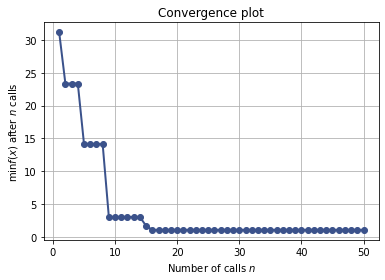

In [12]:
best_mean_squared_error = 9999999999999999
default_parameters =[0.7, 150, 9]
#dropout, filter_num, num_dense_layers
print_and_plot(default_parameters)